In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
n = tn + fp
fpr = fp / n if n > 0.0 else np.float64(0.0)

print("False positive rate = {:.3f}".format(fpr))

False positive rate = 0.552


In [16]:
print("Classifier got {} negative examples wrong".format(int(round(Y_test.sum() * fpr))))

Classifier got 39 negative examples wrong


# Global FPR

In [7]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fpr = sage.PermutationEstimator(imputer, 'fpr')
%time sage_values_fpr = estimator_fpr(test, Y_test, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

tn = 0, fp = 148, fn = 0, tp = 364
===> Iteration 0, Prev loss = 1.0 [outer loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 1, fp = 147, fn = 1, tp = 363
	Loss = 0.9932432432432432 [inner loop]
tn = 2, fp = 146, fn = 1, tp = 363
	Loss = 0.9864864864864865 [inner loop]
tn = 5, fp = 143, fn = 1, tp = 363
	Loss = 0.9662162162162162 [inner loop]
tn = 7, fp = 141, fn = 1, tp = 363
	Loss = 0.9527027027027027 [inner loop]
tn = 9, fp = 139, fn = 3, tp = 361
	Loss = 0.9391891891891891 [inner loop]
tn = 11, fp = 137, fn = 4, tp = 360
	Loss = 0.9256756756756757 [inner loop]
tn = 15, fp = 133, fn = 5, tp = 359
	Loss = 0.8986486486486487 [inner loop]
tn = 15, fp = 133, fn = 6, tp = 358
	Loss = 0.8986486486486487 [inner loop]
tn = 17, fp = 131, fn = 8, tp = 356
	Loss = 0.8851351351351351 [inner loop]
tn = 16, fp = 132, fn = 11, tp = 353
	Loss = 0.8918918918918919 [inner loop]
tn = 18, fp = 130, fn = 11, tp = 353
	Loss = 0.8783783783783784 [inner loop]
tn = 26, fp = 122, fn = 1

tn = 2, fp = 152, fn = 0, tp = 358
	Loss = 0.987012987012987 [inner loop]
tn = 6, fp = 148, fn = 1, tp = 357
	Loss = 0.961038961038961 [inner loop]
tn = 5, fp = 149, fn = 1, tp = 357
	Loss = 0.9675324675324676 [inner loop]
tn = 6, fp = 148, fn = 2, tp = 356
	Loss = 0.961038961038961 [inner loop]
tn = 9, fp = 145, fn = 5, tp = 353
	Loss = 0.9415584415584416 [inner loop]
tn = 13, fp = 141, fn = 6, tp = 352
	Loss = 0.9155844155844156 [inner loop]
tn = 17, fp = 137, fn = 6, tp = 352
	Loss = 0.8896103896103896 [inner loop]
tn = 23, fp = 131, fn = 6, tp = 352
	Loss = 0.8506493506493507 [inner loop]
tn = 30, fp = 124, fn = 6, tp = 352
	Loss = 0.8051948051948052 [inner loop]
tn = 32, fp = 122, fn = 8, tp = 350
	Loss = 0.7922077922077922 [inner loop]
tn = 38, fp = 116, fn = 9, tp = 349
	Loss = 0.7532467532467533 [inner loop]
tn = 40, fp = 114, fn = 10, tp = 348
	Loss = 0.7402597402597403 [inner loop]
tn = 42, fp = 112, fn = 10, tp = 348
	Loss = 0.7272727272727273 [inner loop]
tn = 49, fp = 105,

tn = 14, fp = 141, fn = 1, tp = 356
	Loss = 0.9096774193548387 [inner loop]
tn = 17, fp = 138, fn = 3, tp = 354
	Loss = 0.8903225806451613 [inner loop]
tn = 22, fp = 133, fn = 3, tp = 354
	Loss = 0.8580645161290322 [inner loop]
tn = 24, fp = 131, fn = 4, tp = 353
	Loss = 0.8451612903225807 [inner loop]
tn = 29, fp = 126, fn = 6, tp = 351
	Loss = 0.8129032258064516 [inner loop]
tn = 34, fp = 121, fn = 6, tp = 351
	Loss = 0.7806451612903226 [inner loop]
tn = 36, fp = 119, fn = 7, tp = 350
	Loss = 0.7677419354838709 [inner loop]
tn = 39, fp = 116, fn = 8, tp = 349
	Loss = 0.7483870967741936 [inner loop]
tn = 40, fp = 115, fn = 9, tp = 348
	Loss = 0.7419354838709677 [inner loop]
tn = 49, fp = 106, fn = 9, tp = 348
	Loss = 0.6838709677419355 [inner loop]
tn = 52, fp = 103, fn = 10, tp = 347
	Loss = 0.6645161290322581 [inner loop]
tn = 64, fp = 91, fn = 11, tp = 346
	Loss = 0.5870967741935483 [inner loop]
tn = 66, fp = 89, fn = 14, tp = 343
	Loss = 0.5741935483870968 [inner loop]
tn = 69, fp

tn = 14, fp = 136, fn = 4, tp = 358
	Loss = 0.9066666666666666 [inner loop]
tn = 13, fp = 137, fn = 5, tp = 357
	Loss = 0.9133333333333333 [inner loop]
tn = 21, fp = 129, fn = 4, tp = 358
	Loss = 0.86 [inner loop]
tn = 24, fp = 126, fn = 9, tp = 353
	Loss = 0.84 [inner loop]
tn = 33, fp = 117, fn = 13, tp = 349
	Loss = 0.78 [inner loop]
tn = 38, fp = 112, fn = 12, tp = 350
	Loss = 0.7466666666666667 [inner loop]
tn = 40, fp = 110, fn = 13, tp = 349
	Loss = 0.7333333333333333 [inner loop]
tn = 41, fp = 109, fn = 15, tp = 347
	Loss = 0.7266666666666667 [inner loop]
tn = 53, fp = 97, fn = 20, tp = 342
	Loss = 0.6466666666666666 [inner loop]
tn = 59, fp = 91, fn = 20, tp = 342
	Loss = 0.6066666666666667 [inner loop]
tn = 70, fp = 80, fn = 19, tp = 343
	Loss = 0.5333333333333333 [inner loop]
StdDev Ratio = 0.2103 (Converge at 0.1000)
tn = 0, fp = 145, fn = 0, tp = 367
===> Iteration 16, Prev loss = 1.0 [outer loop]
tn = 0, fp = 145, fn = 0, tp = 367
	Loss = 1.0 [inner loop]
tn = 2, fp = 143

tn = 34, fp = 121, fn = 6, tp = 351
	Loss = 0.7806451612903226 [inner loop]
tn = 37, fp = 118, fn = 13, tp = 344
	Loss = 0.7612903225806451 [inner loop]
tn = 42, fp = 113, fn = 13, tp = 344
	Loss = 0.7290322580645161 [inner loop]
tn = 52, fp = 103, fn = 12, tp = 345
	Loss = 0.6645161290322581 [inner loop]
tn = 53, fp = 102, fn = 14, tp = 343
	Loss = 0.6580645161290323 [inner loop]
tn = 56, fp = 99, fn = 16, tp = 341
	Loss = 0.6387096774193548 [inner loop]
tn = 62, fp = 93, fn = 15, tp = 342
	Loss = 0.6 [inner loop]
tn = 76, fp = 79, fn = 15, tp = 342
	Loss = 0.5096774193548387 [inner loop]
StdDev Ratio = 0.2383 (Converge at 0.1000)
tn = 0, fp = 159, fn = 0, tp = 353
===> Iteration 21, Prev loss = 1.0 [outer loop]
tn = 0, fp = 159, fn = 0, tp = 353
	Loss = 1.0 [inner loop]
tn = 0, fp = 159, fn = 0, tp = 353
	Loss = 1.0 [inner loop]
tn = 2, fp = 157, fn = 0, tp = 353
	Loss = 0.9874213836477987 [inner loop]
tn = 5, fp = 154, fn = 1, tp = 352
	Loss = 0.9685534591194969 [inner loop]
tn = 10

tn = 0, fp = 149, fn = 0, tp = 363
	Loss = 1.0 [inner loop]
tn = 1, fp = 148, fn = 0, tp = 363
	Loss = 0.9932885906040269 [inner loop]
tn = 2, fp = 147, fn = 0, tp = 363
	Loss = 0.9865771812080537 [inner loop]
tn = 2, fp = 147, fn = 1, tp = 362
	Loss = 0.9865771812080537 [inner loop]
tn = 3, fp = 146, fn = 1, tp = 362
	Loss = 0.9798657718120806 [inner loop]
tn = 4, fp = 145, fn = 1, tp = 362
	Loss = 0.9731543624161074 [inner loop]
tn = 6, fp = 143, fn = 1, tp = 362
	Loss = 0.959731543624161 [inner loop]
tn = 8, fp = 141, fn = 1, tp = 362
	Loss = 0.9463087248322147 [inner loop]
tn = 12, fp = 137, fn = 6, tp = 357
	Loss = 0.9194630872483222 [inner loop]
tn = 16, fp = 133, fn = 8, tp = 355
	Loss = 0.8926174496644296 [inner loop]
tn = 19, fp = 130, fn = 8, tp = 355
	Loss = 0.87248322147651 [inner loop]
tn = 27, fp = 122, fn = 9, tp = 354
	Loss = 0.8187919463087249 [inner loop]
tn = 35, fp = 114, fn = 9, tp = 354
	Loss = 0.7651006711409396 [inner loop]
tn = 38, fp = 111, fn = 10, tp = 353
	

tn = 6, fp = 148, fn = 2, tp = 356
	Loss = 0.961038961038961 [inner loop]
tn = 10, fp = 144, fn = 2, tp = 356
	Loss = 0.935064935064935 [inner loop]
tn = 17, fp = 137, fn = 2, tp = 356
	Loss = 0.8896103896103896 [inner loop]
tn = 21, fp = 133, fn = 5, tp = 353
	Loss = 0.8636363636363636 [inner loop]
tn = 23, fp = 131, fn = 5, tp = 353
	Loss = 0.8506493506493507 [inner loop]
tn = 27, fp = 127, fn = 6, tp = 352
	Loss = 0.8246753246753247 [inner loop]
tn = 31, fp = 123, fn = 6, tp = 352
	Loss = 0.7987012987012987 [inner loop]
tn = 34, fp = 120, fn = 6, tp = 352
	Loss = 0.7792207792207793 [inner loop]
tn = 36, fp = 118, fn = 10, tp = 348
	Loss = 0.7662337662337663 [inner loop]
tn = 41, fp = 113, fn = 13, tp = 345
	Loss = 0.7337662337662337 [inner loop]
tn = 47, fp = 107, fn = 12, tp = 346
	Loss = 0.6948051948051948 [inner loop]
tn = 51, fp = 103, fn = 13, tp = 345
	Loss = 0.6688311688311688 [inner loop]
tn = 52, fp = 102, fn = 11, tp = 347
	Loss = 0.6623376623376623 [inner loop]
tn = 51, f

tn = 9, fp = 125, fn = 2, tp = 376
	Loss = 0.9328358208955224 [inner loop]
tn = 14, fp = 120, fn = 3, tp = 375
	Loss = 0.8955223880597015 [inner loop]
tn = 14, fp = 120, fn = 4, tp = 374
	Loss = 0.8955223880597015 [inner loop]
tn = 17, fp = 117, fn = 5, tp = 373
	Loss = 0.8731343283582089 [inner loop]
tn = 18, fp = 116, fn = 7, tp = 371
	Loss = 0.8656716417910447 [inner loop]
tn = 23, fp = 111, fn = 10, tp = 368
	Loss = 0.8283582089552238 [inner loop]
tn = 24, fp = 110, fn = 11, tp = 367
	Loss = 0.8208955223880597 [inner loop]
tn = 27, fp = 107, fn = 14, tp = 364
	Loss = 0.7985074626865671 [inner loop]
tn = 32, fp = 102, fn = 14, tp = 364
	Loss = 0.7611940298507462 [inner loop]
tn = 39, fp = 95, fn = 14, tp = 364
	Loss = 0.7089552238805971 [inner loop]
tn = 40, fp = 94, fn = 18, tp = 360
	Loss = 0.7014925373134329 [inner loop]
tn = 47, fp = 87, fn = 20, tp = 358
	Loss = 0.6492537313432836 [inner loop]
tn = 51, fp = 83, fn = 18, tp = 360
	Loss = 0.6194029850746269 [inner loop]
StdDev Ra

tn = 18, fp = 123, fn = 7, tp = 364
	Loss = 0.8723404255319149 [inner loop]
tn = 24, fp = 117, fn = 8, tp = 363
	Loss = 0.8297872340425532 [inner loop]
tn = 26, fp = 115, fn = 7, tp = 364
	Loss = 0.8156028368794326 [inner loop]
tn = 31, fp = 110, fn = 12, tp = 359
	Loss = 0.7801418439716312 [inner loop]
tn = 37, fp = 104, fn = 16, tp = 355
	Loss = 0.7375886524822695 [inner loop]
tn = 43, fp = 98, fn = 17, tp = 354
	Loss = 0.6950354609929078 [inner loop]
tn = 55, fp = 86, fn = 20, tp = 351
	Loss = 0.6099290780141844 [inner loop]
tn = 57, fp = 84, fn = 18, tp = 353
	Loss = 0.5957446808510638 [inner loop]
tn = 59, fp = 82, fn = 15, tp = 356
	Loss = 0.5815602836879432 [inner loop]
StdDev Ratio = 0.2488 (Converge at 0.1000)
tn = 0, fp = 152, fn = 0, tp = 360
===> Iteration 44, Prev loss = 1.0 [outer loop]
tn = 0, fp = 152, fn = 0, tp = 360
	Loss = 1.0 [inner loop]
tn = 1, fp = 151, fn = 1, tp = 359
	Loss = 0.993421052631579 [inner loop]
tn = 3, fp = 149, fn = 0, tp = 360
	Loss = 0.980263157

tn = 0, fp = 147, fn = 0, tp = 365
	Loss = 1.0 [inner loop]
tn = 0, fp = 147, fn = 0, tp = 365
	Loss = 1.0 [inner loop]
tn = 1, fp = 146, fn = 1, tp = 364
	Loss = 0.9931972789115646 [inner loop]
tn = 3, fp = 144, fn = 1, tp = 364
	Loss = 0.9795918367346939 [inner loop]
tn = 3, fp = 144, fn = 1, tp = 364
	Loss = 0.9795918367346939 [inner loop]
tn = 4, fp = 143, fn = 0, tp = 365
	Loss = 0.9727891156462585 [inner loop]
tn = 4, fp = 143, fn = 2, tp = 363
	Loss = 0.9727891156462585 [inner loop]
tn = 7, fp = 140, fn = 4, tp = 361
	Loss = 0.9523809523809523 [inner loop]
tn = 8, fp = 139, fn = 4, tp = 361
	Loss = 0.9455782312925171 [inner loop]
tn = 17, fp = 130, fn = 7, tp = 358
	Loss = 0.8843537414965986 [inner loop]
tn = 18, fp = 129, fn = 8, tp = 357
	Loss = 0.8775510204081632 [inner loop]
tn = 21, fp = 126, fn = 10, tp = 355
	Loss = 0.8571428571428571 [inner loop]
tn = 20, fp = 127, fn = 11, tp = 354
	Loss = 0.8639455782312925 [inner loop]
tn = 27, fp = 120, fn = 14, tp = 351
	Loss = 0.81

tn = 5, fp = 143, fn = 2, tp = 362
	Loss = 0.9662162162162162 [inner loop]
tn = 7, fp = 141, fn = 4, tp = 360
	Loss = 0.9527027027027027 [inner loop]
tn = 8, fp = 140, fn = 5, tp = 359
	Loss = 0.9459459459459459 [inner loop]
tn = 10, fp = 138, fn = 6, tp = 358
	Loss = 0.9324324324324325 [inner loop]
tn = 12, fp = 136, fn = 7, tp = 357
	Loss = 0.918918918918919 [inner loop]
tn = 15, fp = 133, fn = 11, tp = 353
	Loss = 0.8986486486486487 [inner loop]
tn = 18, fp = 130, fn = 13, tp = 351
	Loss = 0.8783783783783784 [inner loop]
tn = 24, fp = 124, fn = 17, tp = 347
	Loss = 0.8378378378378378 [inner loop]
tn = 30, fp = 118, fn = 17, tp = 347
	Loss = 0.7972972972972973 [inner loop]
tn = 32, fp = 116, fn = 18, tp = 346
	Loss = 0.7837837837837838 [inner loop]
tn = 36, fp = 112, fn = 20, tp = 344
	Loss = 0.7567567567567568 [inner loop]
tn = 44, fp = 104, fn = 19, tp = 345
	Loss = 0.7027027027027027 [inner loop]
tn = 50, fp = 98, fn = 19, tp = 345
	Loss = 0.6621621621621622 [inner loop]
tn = 53, 

tn = 11, fp = 142, fn = 4, tp = 355
	Loss = 0.9281045751633987 [inner loop]
tn = 16, fp = 137, fn = 4, tp = 355
	Loss = 0.8954248366013072 [inner loop]
tn = 23, fp = 130, fn = 4, tp = 355
	Loss = 0.8496732026143791 [inner loop]
tn = 25, fp = 128, fn = 7, tp = 352
	Loss = 0.8366013071895425 [inner loop]
tn = 28, fp = 125, fn = 9, tp = 350
	Loss = 0.8169934640522876 [inner loop]
tn = 30, fp = 123, fn = 9, tp = 350
	Loss = 0.803921568627451 [inner loop]
tn = 35, fp = 118, fn = 12, tp = 347
	Loss = 0.7712418300653595 [inner loop]
tn = 42, fp = 111, fn = 15, tp = 344
	Loss = 0.7254901960784313 [inner loop]
tn = 42, fp = 111, fn = 15, tp = 344
	Loss = 0.7254901960784313 [inner loop]
tn = 54, fp = 99, fn = 17, tp = 342
	Loss = 0.6470588235294118 [inner loop]
tn = 61, fp = 92, fn = 20, tp = 339
	Loss = 0.6013071895424836 [inner loop]
tn = 64, fp = 89, fn = 22, tp = 337
	Loss = 0.5816993464052288 [inner loop]
tn = 67, fp = 86, fn = 20, tp = 339
	Loss = 0.5620915032679739 [inner loop]
StdDev Rat

tn = 18, fp = 127, fn = 12, tp = 355
	Loss = 0.8758620689655172 [inner loop]
tn = 17, fp = 128, fn = 11, tp = 356
	Loss = 0.8827586206896552 [inner loop]
tn = 24, fp = 121, fn = 11, tp = 356
	Loss = 0.8344827586206897 [inner loop]
tn = 31, fp = 114, fn = 11, tp = 356
	Loss = 0.7862068965517242 [inner loop]
tn = 32, fp = 113, fn = 17, tp = 350
	Loss = 0.7793103448275862 [inner loop]
tn = 40, fp = 105, fn = 20, tp = 347
	Loss = 0.7241379310344828 [inner loop]
tn = 40, fp = 105, fn = 23, tp = 344
	Loss = 0.7241379310344828 [inner loop]
tn = 45, fp = 100, fn = 20, tp = 347
	Loss = 0.6896551724137931 [inner loop]
tn = 50, fp = 95, fn = 19, tp = 348
	Loss = 0.6551724137931034 [inner loop]
tn = 56, fp = 89, fn = 18, tp = 349
	Loss = 0.6137931034482759 [inner loop]
StdDev Ratio = 0.1834 (Converge at 0.1000)
tn = 0, fp = 156, fn = 0, tp = 356
===> Iteration 67, Prev loss = 1.0 [outer loop]
tn = 0, fp = 156, fn = 0, tp = 356
	Loss = 1.0 [inner loop]
tn = 0, fp = 156, fn = 0, tp = 356
	Loss = 1.0

tn = 28, fp = 109, fn = 10, tp = 365
	Loss = 0.7956204379562044 [inner loop]
tn = 32, fp = 105, fn = 9, tp = 366
	Loss = 0.7664233576642335 [inner loop]
tn = 38, fp = 99, fn = 10, tp = 365
	Loss = 0.7226277372262774 [inner loop]
tn = 40, fp = 97, fn = 14, tp = 361
	Loss = 0.708029197080292 [inner loop]
tn = 48, fp = 89, fn = 19, tp = 356
	Loss = 0.6496350364963503 [inner loop]
tn = 51, fp = 86, fn = 19, tp = 356
	Loss = 0.6277372262773723 [inner loop]
tn = 51, fp = 86, fn = 20, tp = 355
	Loss = 0.6277372262773723 [inner loop]
tn = 61, fp = 76, fn = 18, tp = 357
	Loss = 0.5547445255474452 [inner loop]
StdDev Ratio = 0.1772 (Converge at 0.1000)
tn = 0, fp = 161, fn = 0, tp = 351
===> Iteration 72, Prev loss = 1.0 [outer loop]
tn = 0, fp = 161, fn = 0, tp = 351
	Loss = 1.0 [inner loop]
tn = 1, fp = 160, fn = 1, tp = 350
	Loss = 0.9937888198757764 [inner loop]
tn = 1, fp = 160, fn = 2, tp = 349
	Loss = 0.9937888198757764 [inner loop]
tn = 3, fp = 158, fn = 3, tp = 348
	Loss = 0.98136645962

tn = 37, fp = 124, fn = 12, tp = 339
	Loss = 0.7701863354037267 [inner loop]
tn = 39, fp = 122, fn = 15, tp = 336
	Loss = 0.7577639751552795 [inner loop]
tn = 42, fp = 119, fn = 16, tp = 335
	Loss = 0.7391304347826086 [inner loop]
tn = 54, fp = 107, fn = 15, tp = 336
	Loss = 0.6645962732919255 [inner loop]
tn = 61, fp = 100, fn = 16, tp = 335
	Loss = 0.6211180124223602 [inner loop]
tn = 70, fp = 91, fn = 15, tp = 336
	Loss = 0.5652173913043478 [inner loop]
StdDev Ratio = 0.1920 (Converge at 0.1000)
tn = 0, fp = 139, fn = 0, tp = 373
===> Iteration 77, Prev loss = 1.0 [outer loop]
tn = 0, fp = 139, fn = 0, tp = 373
	Loss = 1.0 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	Loss = 0.9928057553956835 [inner loop]
tn = 2, fp = 137, fn = 1, tp = 372
	Loss = 0.9856115107913669 [inner loop]
tn = 2, fp = 137, fn = 1, tp = 372
	Loss = 0.9856115107913669 [inner loop]
tn = 4, fp = 135, fn = 3, tp = 370
	Loss = 0.9712230215827338 [inner loop]
tn = 4, fp = 135, fn = 3, tp = 370
	Loss = 0.97122302

tn = 49, fp = 79, fn = 20, tp = 364
	Loss = 0.6171875 [inner loop]
tn = 56, fp = 72, fn = 17, tp = 367
	Loss = 0.5625 [inner loop]
StdDev Ratio = 0.1911 (Converge at 0.1000)
tn = 0, fp = 132, fn = 0, tp = 380
===> Iteration 82, Prev loss = 1.0 [outer loop]
tn = 0, fp = 132, fn = 0, tp = 380
	Loss = 1.0 [inner loop]
tn = 1, fp = 131, fn = 1, tp = 379
	Loss = 0.9924242424242424 [inner loop]
tn = 2, fp = 130, fn = 2, tp = 378
	Loss = 0.9848484848484849 [inner loop]
tn = 4, fp = 128, fn = 3, tp = 377
	Loss = 0.9696969696969697 [inner loop]
tn = 6, fp = 126, fn = 3, tp = 377
	Loss = 0.9545454545454546 [inner loop]
tn = 10, fp = 122, fn = 3, tp = 377
	Loss = 0.9242424242424242 [inner loop]
tn = 10, fp = 122, fn = 3, tp = 377
	Loss = 0.9242424242424242 [inner loop]
tn = 11, fp = 121, fn = 5, tp = 375
	Loss = 0.9166666666666666 [inner loop]
tn = 17, fp = 115, fn = 8, tp = 372
	Loss = 0.8712121212121212 [inner loop]
tn = 24, fp = 108, fn = 9, tp = 371
	Loss = 0.8181818181818182 [inner loop]
tn 

tn = 1, fp = 130, fn = 0, tp = 381
	Loss = 0.9923664122137404 [inner loop]
tn = 1, fp = 130, fn = 0, tp = 381
	Loss = 0.9923664122137404 [inner loop]
tn = 2, fp = 129, fn = 0, tp = 381
	Loss = 0.9847328244274809 [inner loop]
tn = 4, fp = 127, fn = 0, tp = 381
	Loss = 0.9694656488549618 [inner loop]
tn = 6, fp = 125, fn = 1, tp = 380
	Loss = 0.9541984732824428 [inner loop]
tn = 9, fp = 122, fn = 2, tp = 379
	Loss = 0.9312977099236641 [inner loop]
tn = 11, fp = 120, fn = 3, tp = 378
	Loss = 0.916030534351145 [inner loop]
tn = 13, fp = 118, fn = 4, tp = 377
	Loss = 0.9007633587786259 [inner loop]
tn = 19, fp = 112, fn = 3, tp = 378
	Loss = 0.8549618320610687 [inner loop]
tn = 21, fp = 110, fn = 4, tp = 377
	Loss = 0.8396946564885496 [inner loop]
tn = 25, fp = 106, fn = 5, tp = 376
	Loss = 0.8091603053435115 [inner loop]
tn = 31, fp = 100, fn = 6, tp = 375
	Loss = 0.7633587786259542 [inner loop]
tn = 31, fp = 100, fn = 9, tp = 372
	Loss = 0.7633587786259542 [inner loop]
tn = 33, fp = 98, f

tn = 9, fp = 141, fn = 2, tp = 360
	Loss = 0.94 [inner loop]
tn = 11, fp = 139, fn = 2, tp = 360
	Loss = 0.9266666666666666 [inner loop]
tn = 15, fp = 135, fn = 2, tp = 360
	Loss = 0.9 [inner loop]
tn = 17, fp = 133, fn = 4, tp = 358
	Loss = 0.8866666666666667 [inner loop]
tn = 21, fp = 129, fn = 5, tp = 357
	Loss = 0.86 [inner loop]
tn = 22, fp = 128, fn = 6, tp = 356
	Loss = 0.8533333333333334 [inner loop]
tn = 25, fp = 125, fn = 6, tp = 356
	Loss = 0.8333333333333334 [inner loop]
tn = 34, fp = 116, fn = 10, tp = 352
	Loss = 0.7733333333333333 [inner loop]
tn = 37, fp = 113, fn = 11, tp = 351
	Loss = 0.7533333333333333 [inner loop]
tn = 43, fp = 107, fn = 12, tp = 350
	Loss = 0.7133333333333334 [inner loop]
tn = 41, fp = 109, fn = 11, tp = 351
	Loss = 0.7266666666666667 [inner loop]
tn = 48, fp = 102, fn = 14, tp = 348
	Loss = 0.68 [inner loop]
tn = 51, fp = 99, fn = 14, tp = 348
	Loss = 0.66 [inner loop]
tn = 59, fp = 91, fn = 10, tp = 352
	Loss = 0.6066666666666667 [inner loop]
tn 

tn = 18, fp = 147, fn = 5, tp = 342
	Loss = 0.8909090909090909 [inner loop]
tn = 23, fp = 142, fn = 5, tp = 342
	Loss = 0.8606060606060606 [inner loop]
tn = 28, fp = 137, fn = 6, tp = 341
	Loss = 0.8303030303030303 [inner loop]
tn = 33, fp = 132, fn = 7, tp = 340
	Loss = 0.8 [inner loop]
tn = 36, fp = 129, fn = 8, tp = 339
	Loss = 0.7818181818181819 [inner loop]
tn = 41, fp = 124, fn = 10, tp = 337
	Loss = 0.7515151515151515 [inner loop]
tn = 43, fp = 122, fn = 10, tp = 337
	Loss = 0.7393939393939394 [inner loop]
tn = 46, fp = 119, fn = 12, tp = 335
	Loss = 0.7212121212121212 [inner loop]
tn = 41, fp = 124, fn = 12, tp = 335
	Loss = 0.7515151515151515 [inner loop]
tn = 45, fp = 120, fn = 12, tp = 335
	Loss = 0.7272727272727273 [inner loop]
tn = 52, fp = 113, fn = 16, tp = 331
	Loss = 0.6848484848484848 [inner loop]
tn = 66, fp = 99, fn = 16, tp = 331
	Loss = 0.6 [inner loop]
StdDev Ratio = 0.1662 (Converge at 0.1000)
tn = 0, fp = 142, fn = 0, tp = 370
===> Iteration 98, Prev loss = 1.0

tn = 34, fp = 113, fn = 10, tp = 355
	Loss = 0.7687074829931972 [inner loop]
tn = 35, fp = 112, fn = 14, tp = 351
	Loss = 0.7619047619047619 [inner loop]
tn = 45, fp = 102, fn = 15, tp = 350
	Loss = 0.6938775510204082 [inner loop]
tn = 53, fp = 94, fn = 16, tp = 349
	Loss = 0.6394557823129252 [inner loop]
tn = 60, fp = 87, fn = 18, tp = 347
	Loss = 0.5918367346938775 [inner loop]
tn = 62, fp = 85, fn = 18, tp = 347
	Loss = 0.5782312925170068 [inner loop]
tn = 65, fp = 82, fn = 19, tp = 346
	Loss = 0.5578231292517006 [inner loop]
tn = 62, fp = 85, fn = 21, tp = 344
	Loss = 0.5782312925170068 [inner loop]
tn = 70, fp = 77, fn = 22, tp = 343
	Loss = 0.5238095238095238 [inner loop]
StdDev Ratio = 0.1578 (Converge at 0.1000)
tn = 0, fp = 152, fn = 0, tp = 360
===> Iteration 103, Prev loss = 1.0 [outer loop]
tn = 0, fp = 152, fn = 0, tp = 360
	Loss = 1.0 [inner loop]
tn = 0, fp = 152, fn = 1, tp = 359
	Loss = 1.0 [inner loop]
tn = 0, fp = 152, fn = 1, tp = 359
	Loss = 1.0 [inner loop]
tn = 0

tn = 45, fp = 113, fn = 18, tp = 336
	Loss = 0.7151898734177216 [inner loop]
tn = 45, fp = 113, fn = 19, tp = 335
	Loss = 0.7151898734177216 [inner loop]
tn = 46, fp = 112, fn = 22, tp = 332
	Loss = 0.7088607594936709 [inner loop]
tn = 48, fp = 110, fn = 20, tp = 334
	Loss = 0.6962025316455697 [inner loop]
tn = 56, fp = 102, fn = 18, tp = 336
	Loss = 0.6455696202531646 [inner loop]
tn = 64, fp = 94, fn = 19, tp = 335
	Loss = 0.5949367088607594 [inner loop]
StdDev Ratio = 0.1590 (Converge at 0.1000)
tn = 0, fp = 146, fn = 0, tp = 366
===> Iteration 108, Prev loss = 1.0 [outer loop]
tn = 0, fp = 146, fn = 0, tp = 366
	Loss = 1.0 [inner loop]
tn = 0, fp = 146, fn = 0, tp = 366
	Loss = 1.0 [inner loop]
tn = 3, fp = 143, fn = 1, tp = 365
	Loss = 0.9794520547945206 [inner loop]
tn = 4, fp = 142, fn = 1, tp = 365
	Loss = 0.9726027397260274 [inner loop]
tn = 11, fp = 135, fn = 1, tp = 365
	Loss = 0.9246575342465754 [inner loop]
tn = 12, fp = 134, fn = 1, tp = 365
	Loss = 0.9178082191780822 [in

tn = 57, fp = 100, fn = 14, tp = 341
	Loss = 0.6369426751592356 [inner loop]
tn = 64, fp = 93, fn = 12, tp = 343
	Loss = 0.5923566878980892 [inner loop]
tn = 69, fp = 88, fn = 10, tp = 345
	Loss = 0.5605095541401274 [inner loop]
StdDev Ratio = 0.1623 (Converge at 0.1000)
tn = 0, fp = 124, fn = 0, tp = 388
===> Iteration 113, Prev loss = 1.0 [outer loop]
tn = 0, fp = 124, fn = 0, tp = 388
	Loss = 1.0 [inner loop]
tn = 0, fp = 124, fn = 0, tp = 388
	Loss = 1.0 [inner loop]
tn = 3, fp = 121, fn = 0, tp = 388
	Loss = 0.9758064516129032 [inner loop]
tn = 5, fp = 119, fn = 0, tp = 388
	Loss = 0.9596774193548387 [inner loop]
tn = 5, fp = 119, fn = 0, tp = 388
	Loss = 0.9596774193548387 [inner loop]
tn = 9, fp = 115, fn = 0, tp = 388
	Loss = 0.9274193548387096 [inner loop]
tn = 8, fp = 116, fn = 1, tp = 387
	Loss = 0.9354838709677419 [inner loop]
tn = 12, fp = 112, fn = 2, tp = 386
	Loss = 0.9032258064516129 [inner loop]
tn = 16, fp = 108, fn = 2, tp = 386
	Loss = 0.8709677419354839 [inner loo

tn = 70, fp = 82, fn = 20, tp = 340
	Loss = 0.5394736842105263 [inner loop]
StdDev Ratio = 0.1623 (Converge at 0.1000)
tn = 0, fp = 134, fn = 0, tp = 378
===> Iteration 118, Prev loss = 1.0 [outer loop]
tn = 0, fp = 134, fn = 0, tp = 378
	Loss = 1.0 [inner loop]
tn = 0, fp = 134, fn = 0, tp = 378
	Loss = 1.0 [inner loop]
tn = 2, fp = 132, fn = 0, tp = 378
	Loss = 0.9850746268656716 [inner loop]
tn = 3, fp = 131, fn = 1, tp = 377
	Loss = 0.9776119402985075 [inner loop]
tn = 4, fp = 130, fn = 2, tp = 376
	Loss = 0.9701492537313433 [inner loop]
tn = 6, fp = 128, fn = 3, tp = 375
	Loss = 0.9552238805970149 [inner loop]
tn = 7, fp = 127, fn = 5, tp = 373
	Loss = 0.9477611940298507 [inner loop]
tn = 7, fp = 127, fn = 5, tp = 373
	Loss = 0.9477611940298507 [inner loop]
tn = 11, fp = 123, fn = 7, tp = 371
	Loss = 0.917910447761194 [inner loop]
tn = 13, fp = 121, fn = 7, tp = 371
	Loss = 0.9029850746268657 [inner loop]
tn = 17, fp = 117, fn = 8, tp = 370
	Loss = 0.8731343283582089 [inner loop]


tn = 3, fp = 155, fn = 1, tp = 353
	Loss = 0.9810126582278481 [inner loop]
tn = 6, fp = 152, fn = 2, tp = 352
	Loss = 0.9620253164556962 [inner loop]
tn = 8, fp = 150, fn = 3, tp = 351
	Loss = 0.9493670886075949 [inner loop]
tn = 10, fp = 148, fn = 3, tp = 351
	Loss = 0.9367088607594937 [inner loop]
tn = 12, fp = 146, fn = 5, tp = 349
	Loss = 0.9240506329113924 [inner loop]
tn = 17, fp = 141, fn = 6, tp = 348
	Loss = 0.8924050632911392 [inner loop]
tn = 21, fp = 137, fn = 5, tp = 349
	Loss = 0.8670886075949367 [inner loop]
tn = 25, fp = 133, fn = 7, tp = 347
	Loss = 0.8417721518987342 [inner loop]
tn = 33, fp = 125, fn = 8, tp = 346
	Loss = 0.7911392405063291 [inner loop]
tn = 36, fp = 122, fn = 9, tp = 345
	Loss = 0.7721518987341772 [inner loop]
tn = 38, fp = 120, fn = 8, tp = 346
	Loss = 0.759493670886076 [inner loop]
tn = 42, fp = 116, fn = 8, tp = 346
	Loss = 0.7341772151898734 [inner loop]
tn = 47, fp = 111, fn = 10, tp = 344
	Loss = 0.7025316455696202 [inner loop]
tn = 50, fp = 1

tn = 3, fp = 158, fn = 6, tp = 345
	Loss = 0.9813664596273292 [inner loop]
tn = 9, fp = 152, fn = 5, tp = 346
	Loss = 0.9440993788819876 [inner loop]
tn = 10, fp = 151, fn = 5, tp = 346
	Loss = 0.937888198757764 [inner loop]
tn = 14, fp = 147, fn = 7, tp = 344
	Loss = 0.9130434782608695 [inner loop]
tn = 14, fp = 147, fn = 10, tp = 341
	Loss = 0.9130434782608695 [inner loop]
tn = 18, fp = 143, fn = 11, tp = 340
	Loss = 0.8881987577639752 [inner loop]
tn = 20, fp = 141, fn = 11, tp = 340
	Loss = 0.8757763975155279 [inner loop]
tn = 25, fp = 136, fn = 11, tp = 340
	Loss = 0.84472049689441 [inner loop]
tn = 32, fp = 129, fn = 11, tp = 340
	Loss = 0.8012422360248447 [inner loop]
tn = 37, fp = 124, fn = 11, tp = 340
	Loss = 0.7701863354037267 [inner loop]
tn = 44, fp = 117, fn = 15, tp = 336
	Loss = 0.7267080745341615 [inner loop]
tn = 51, fp = 110, fn = 17, tp = 334
	Loss = 0.6832298136645962 [inner loop]
tn = 55, fp = 106, fn = 20, tp = 331
	Loss = 0.6583850931677019 [inner loop]
tn = 64,

tn = 12, fp = 134, fn = 5, tp = 361
	Loss = 0.9178082191780822 [inner loop]
tn = 13, fp = 133, fn = 6, tp = 360
	Loss = 0.910958904109589 [inner loop]
tn = 17, fp = 129, fn = 5, tp = 361
	Loss = 0.8835616438356164 [inner loop]
tn = 21, fp = 125, fn = 5, tp = 361
	Loss = 0.8561643835616438 [inner loop]
tn = 23, fp = 123, fn = 6, tp = 360
	Loss = 0.8424657534246576 [inner loop]
tn = 26, fp = 120, fn = 6, tp = 360
	Loss = 0.821917808219178 [inner loop]
tn = 30, fp = 116, fn = 5, tp = 361
	Loss = 0.7945205479452054 [inner loop]
tn = 43, fp = 103, fn = 7, tp = 359
	Loss = 0.7054794520547946 [inner loop]
tn = 45, fp = 101, fn = 9, tp = 357
	Loss = 0.6917808219178082 [inner loop]
tn = 49, fp = 97, fn = 8, tp = 358
	Loss = 0.6643835616438356 [inner loop]
tn = 56, fp = 90, fn = 8, tp = 358
	Loss = 0.6164383561643836 [inner loop]
tn = 64, fp = 82, fn = 12, tp = 354
	Loss = 0.5616438356164384 [inner loop]
tn = 70, fp = 76, fn = 11, tp = 355
	Loss = 0.5205479452054794 [inner loop]
StdDev Ratio = 0

tn = 21, fp = 129, fn = 6, tp = 356
	Loss = 0.86 [inner loop]
tn = 30, fp = 120, fn = 7, tp = 355
	Loss = 0.8 [inner loop]
tn = 33, fp = 117, fn = 8, tp = 354
	Loss = 0.78 [inner loop]
tn = 35, fp = 115, fn = 8, tp = 354
	Loss = 0.7666666666666667 [inner loop]
tn = 43, fp = 107, fn = 10, tp = 352
	Loss = 0.7133333333333334 [inner loop]
tn = 48, fp = 102, fn = 11, tp = 351
	Loss = 0.68 [inner loop]
tn = 50, fp = 100, fn = 12, tp = 350
	Loss = 0.6666666666666666 [inner loop]
tn = 54, fp = 96, fn = 11, tp = 351
	Loss = 0.64 [inner loop]
tn = 55, fp = 95, fn = 12, tp = 350
	Loss = 0.6333333333333333 [inner loop]
tn = 61, fp = 89, fn = 11, tp = 351
	Loss = 0.5933333333333334 [inner loop]
StdDev Ratio = 0.1387 (Converge at 0.1000)
tn = 0, fp = 135, fn = 0, tp = 377
===> Iteration 139, Prev loss = 1.0 [outer loop]
tn = 0, fp = 135, fn = 0, tp = 377
	Loss = 1.0 [inner loop]
tn = 0, fp = 135, fn = 0, tp = 377
	Loss = 1.0 [inner loop]
tn = 3, fp = 132, fn = 0, tp = 377
	Loss = 0.9777777777777777

tn = 39, fp = 114, fn = 8, tp = 351
	Loss = 0.7450980392156863 [inner loop]
tn = 47, fp = 106, fn = 12, tp = 347
	Loss = 0.6928104575163399 [inner loop]
tn = 48, fp = 105, fn = 11, tp = 348
	Loss = 0.6862745098039216 [inner loop]
tn = 52, fp = 101, fn = 15, tp = 344
	Loss = 0.6601307189542484 [inner loop]
tn = 54, fp = 99, fn = 16, tp = 343
	Loss = 0.6470588235294118 [inner loop]
tn = 60, fp = 93, fn = 15, tp = 344
	Loss = 0.6078431372549019 [inner loop]
StdDev Ratio = 0.1357 (Converge at 0.1000)
tn = 0, fp = 154, fn = 0, tp = 358
===> Iteration 144, Prev loss = 1.0 [outer loop]
tn = 0, fp = 154, fn = 0, tp = 358
	Loss = 1.0 [inner loop]
tn = 0, fp = 154, fn = 0, tp = 358
	Loss = 1.0 [inner loop]
tn = 0, fp = 154, fn = 0, tp = 358
	Loss = 1.0 [inner loop]
tn = 2, fp = 152, fn = 0, tp = 358
	Loss = 0.987012987012987 [inner loop]
tn = 5, fp = 149, fn = 2, tp = 356
	Loss = 0.9675324675324676 [inner loop]
tn = 10, fp = 144, fn = 3, tp = 355
	Loss = 0.935064935064935 [inner loop]
tn = 15, f

tn = 66, fp = 95, fn = 26, tp = 325
	Loss = 0.5900621118012422 [inner loop]
tn = 74, fp = 87, fn = 27, tp = 324
	Loss = 0.5403726708074534 [inner loop]
tn = 77, fp = 84, fn = 26, tp = 325
	Loss = 0.5217391304347826 [inner loop]
StdDev Ratio = 0.1306 (Converge at 0.1000)
tn = 0, fp = 149, fn = 0, tp = 363
===> Iteration 149, Prev loss = 1.0 [outer loop]
tn = 0, fp = 149, fn = 0, tp = 363
	Loss = 1.0 [inner loop]
tn = 2, fp = 147, fn = 0, tp = 363
	Loss = 0.9865771812080537 [inner loop]
tn = 2, fp = 147, fn = 0, tp = 363
	Loss = 0.9865771812080537 [inner loop]
tn = 5, fp = 144, fn = 0, tp = 363
	Loss = 0.9664429530201343 [inner loop]
tn = 6, fp = 143, fn = 1, tp = 362
	Loss = 0.959731543624161 [inner loop]
tn = 12, fp = 137, fn = 1, tp = 362
	Loss = 0.9194630872483222 [inner loop]
tn = 14, fp = 135, fn = 1, tp = 362
	Loss = 0.9060402684563759 [inner loop]
tn = 22, fp = 127, fn = 1, tp = 362
	Loss = 0.8523489932885906 [inner loop]
tn = 25, fp = 124, fn = 1, tp = 362
	Loss = 0.832214765100

tn = 59, fp = 93, fn = 18, tp = 342
	Loss = 0.6118421052631579 [inner loop]
tn = 60, fp = 92, fn = 15, tp = 345
	Loss = 0.6052631578947368 [inner loop]
tn = 65, fp = 87, fn = 17, tp = 343
	Loss = 0.5723684210526315 [inner loop]
StdDev Ratio = 0.1236 (Converge at 0.1000)
tn = 0, fp = 170, fn = 0, tp = 342
===> Iteration 157, Prev loss = 1.0 [outer loop]
tn = 0, fp = 170, fn = 0, tp = 342
	Loss = 1.0 [inner loop]
tn = 2, fp = 168, fn = 0, tp = 342
	Loss = 0.9882352941176471 [inner loop]
tn = 3, fp = 167, fn = 0, tp = 342
	Loss = 0.9823529411764705 [inner loop]
tn = 5, fp = 165, fn = 0, tp = 342
	Loss = 0.9705882352941176 [inner loop]
tn = 9, fp = 161, fn = 0, tp = 342
	Loss = 0.9470588235294117 [inner loop]
tn = 11, fp = 159, fn = 1, tp = 341
	Loss = 0.9352941176470588 [inner loop]
tn = 13, fp = 157, fn = 2, tp = 340
	Loss = 0.9235294117647059 [inner loop]
tn = 15, fp = 155, fn = 3, tp = 339
	Loss = 0.9117647058823529 [inner loop]
tn = 17, fp = 153, fn = 2, tp = 340
	Loss = 0.9 [inner lo

tn = 70, fp = 92, fn = 16, tp = 334
	Loss = 0.5679012345679012 [inner loop]
StdDev Ratio = 0.1246 (Converge at 0.1000)
tn = 0, fp = 154, fn = 0, tp = 358
===> Iteration 162, Prev loss = 1.0 [outer loop]
tn = 0, fp = 154, fn = 0, tp = 358
	Loss = 1.0 [inner loop]
tn = 0, fp = 154, fn = 0, tp = 358
	Loss = 1.0 [inner loop]
tn = 1, fp = 153, fn = 1, tp = 357
	Loss = 0.9935064935064936 [inner loop]
tn = 1, fp = 153, fn = 3, tp = 355
	Loss = 0.9935064935064936 [inner loop]
tn = 4, fp = 150, fn = 3, tp = 355
	Loss = 0.974025974025974 [inner loop]
tn = 6, fp = 148, fn = 6, tp = 352
	Loss = 0.961038961038961 [inner loop]
tn = 8, fp = 146, fn = 3, tp = 355
	Loss = 0.948051948051948 [inner loop]
tn = 9, fp = 145, fn = 6, tp = 352
	Loss = 0.9415584415584416 [inner loop]
tn = 19, fp = 135, fn = 6, tp = 352
	Loss = 0.8766233766233766 [inner loop]
tn = 23, fp = 131, fn = 6, tp = 352
	Loss = 0.8506493506493507 [inner loop]
tn = 24, fp = 130, fn = 9, tp = 349
	Loss = 0.8441558441558441 [inner loop]
tn

tn = 0, fp = 140, fn = 0, tp = 372
	Loss = 1.0 [inner loop]
tn = 0, fp = 140, fn = 0, tp = 372
	Loss = 1.0 [inner loop]
tn = 0, fp = 140, fn = 0, tp = 372
	Loss = 1.0 [inner loop]
tn = 2, fp = 138, fn = 1, tp = 371
	Loss = 0.9857142857142858 [inner loop]
tn = 2, fp = 138, fn = 2, tp = 370
	Loss = 0.9857142857142858 [inner loop]
tn = 5, fp = 135, fn = 2, tp = 370
	Loss = 0.9642857142857143 [inner loop]
tn = 9, fp = 131, fn = 2, tp = 370
	Loss = 0.9357142857142857 [inner loop]
tn = 13, fp = 127, fn = 3, tp = 369
	Loss = 0.9071428571428571 [inner loop]
tn = 14, fp = 126, fn = 2, tp = 370
	Loss = 0.9 [inner loop]
tn = 17, fp = 123, fn = 3, tp = 369
	Loss = 0.8785714285714286 [inner loop]
tn = 21, fp = 119, fn = 4, tp = 368
	Loss = 0.85 [inner loop]
tn = 26, fp = 114, fn = 4, tp = 368
	Loss = 0.8142857142857143 [inner loop]
tn = 28, fp = 112, fn = 5, tp = 367
	Loss = 0.8 [inner loop]
tn = 35, fp = 105, fn = 6, tp = 366
	Loss = 0.75 [inner loop]
tn = 35, fp = 105, fn = 9, tp = 363
	Loss = 0.

tn = 10, fp = 137, fn = 1, tp = 364
	Loss = 0.9319727891156463 [inner loop]
tn = 13, fp = 134, fn = 3, tp = 362
	Loss = 0.9115646258503401 [inner loop]
tn = 15, fp = 132, fn = 4, tp = 361
	Loss = 0.8979591836734694 [inner loop]
tn = 19, fp = 128, fn = 5, tp = 360
	Loss = 0.8707482993197279 [inner loop]
tn = 24, fp = 123, fn = 4, tp = 361
	Loss = 0.8367346938775511 [inner loop]
tn = 26, fp = 121, fn = 6, tp = 359
	Loss = 0.8231292517006803 [inner loop]
tn = 27, fp = 120, fn = 8, tp = 357
	Loss = 0.8163265306122449 [inner loop]
tn = 31, fp = 116, fn = 8, tp = 357
	Loss = 0.7891156462585034 [inner loop]
tn = 33, fp = 114, fn = 6, tp = 359
	Loss = 0.7755102040816326 [inner loop]
tn = 36, fp = 111, fn = 6, tp = 359
	Loss = 0.7551020408163265 [inner loop]
tn = 44, fp = 103, fn = 6, tp = 359
	Loss = 0.7006802721088435 [inner loop]
tn = 45, fp = 102, fn = 8, tp = 357
	Loss = 0.6938775510204082 [inner loop]
tn = 54, fp = 93, fn = 11, tp = 354
	Loss = 0.6326530612244898 [inner loop]
tn = 58, fp 

tn = 14, fp = 143, fn = 6, tp = 349
	Loss = 0.910828025477707 [inner loop]
tn = 15, fp = 142, fn = 7, tp = 348
	Loss = 0.9044585987261147 [inner loop]
tn = 18, fp = 139, fn = 10, tp = 345
	Loss = 0.8853503184713376 [inner loop]
tn = 27, fp = 130, fn = 11, tp = 344
	Loss = 0.8280254777070064 [inner loop]
tn = 33, fp = 124, fn = 11, tp = 344
	Loss = 0.7898089171974523 [inner loop]
tn = 41, fp = 116, fn = 13, tp = 342
	Loss = 0.7388535031847133 [inner loop]
tn = 44, fp = 113, fn = 11, tp = 344
	Loss = 0.7197452229299363 [inner loop]
tn = 44, fp = 113, fn = 11, tp = 344
	Loss = 0.7197452229299363 [inner loop]
tn = 53, fp = 104, fn = 16, tp = 339
	Loss = 0.6624203821656051 [inner loop]
tn = 57, fp = 100, fn = 19, tp = 336
	Loss = 0.6369426751592356 [inner loop]
tn = 66, fp = 91, fn = 19, tp = 336
	Loss = 0.5796178343949044 [inner loop]
tn = 72, fp = 85, fn = 16, tp = 339
	Loss = 0.5414012738853503 [inner loop]
StdDev Ratio = 0.1297 (Converge at 0.1000)
tn = 0, fp = 142, fn = 0, tp = 370
===

tn = 18, fp = 122, fn = 7, tp = 365
	Loss = 0.8714285714285714 [inner loop]
tn = 21, fp = 119, fn = 6, tp = 366
	Loss = 0.85 [inner loop]
tn = 26, fp = 114, fn = 8, tp = 364
	Loss = 0.8142857142857143 [inner loop]
tn = 32, fp = 108, fn = 9, tp = 363
	Loss = 0.7714285714285715 [inner loop]
tn = 40, fp = 100, fn = 8, tp = 364
	Loss = 0.7142857142857143 [inner loop]
tn = 46, fp = 94, fn = 8, tp = 364
	Loss = 0.6714285714285714 [inner loop]
tn = 48, fp = 92, fn = 12, tp = 360
	Loss = 0.6571428571428571 [inner loop]
tn = 55, fp = 85, fn = 9, tp = 363
	Loss = 0.6071428571428571 [inner loop]
tn = 62, fp = 78, fn = 10, tp = 362
	Loss = 0.5571428571428572 [inner loop]
tn = 67, fp = 73, fn = 11, tp = 361
	Loss = 0.5214285714285715 [inner loop]
StdDev Ratio = 0.1240 (Converge at 0.1000)
tn = 0, fp = 151, fn = 0, tp = 361
===> Iteration 183, Prev loss = 1.0 [outer loop]
tn = 0, fp = 151, fn = 0, tp = 361
	Loss = 1.0 [inner loop]
tn = 0, fp = 151, fn = 0, tp = 361
	Loss = 1.0 [inner loop]
tn = 3, f

tn = 32, fp = 120, fn = 10, tp = 350
	Loss = 0.7894736842105263 [inner loop]
tn = 34, fp = 118, fn = 10, tp = 350
	Loss = 0.7763157894736842 [inner loop]
tn = 35, fp = 117, fn = 13, tp = 347
	Loss = 0.7697368421052632 [inner loop]
tn = 41, fp = 111, fn = 14, tp = 346
	Loss = 0.7302631578947368 [inner loop]
tn = 43, fp = 109, fn = 16, tp = 344
	Loss = 0.7171052631578947 [inner loop]
tn = 50, fp = 102, fn = 20, tp = 340
	Loss = 0.6710526315789473 [inner loop]
tn = 56, fp = 96, fn = 16, tp = 344
	Loss = 0.631578947368421 [inner loop]
tn = 65, fp = 87, fn = 15, tp = 345
	Loss = 0.5723684210526315 [inner loop]
StdDev Ratio = 0.1191 (Converge at 0.1000)
tn = 0, fp = 163, fn = 0, tp = 349
===> Iteration 188, Prev loss = 1.0 [outer loop]
tn = 0, fp = 163, fn = 0, tp = 349
	Loss = 1.0 [inner loop]
tn = 1, fp = 162, fn = 0, tp = 349
	Loss = 0.9938650306748467 [inner loop]
tn = 3, fp = 160, fn = 0, tp = 349
	Loss = 0.9815950920245399 [inner loop]
tn = 3, fp = 160, fn = 1, tp = 348
	Loss = 0.98159

tn = 37, fp = 102, fn = 13, tp = 360
	Loss = 0.7338129496402878 [inner loop]
tn = 47, fp = 92, fn = 14, tp = 359
	Loss = 0.6618705035971223 [inner loop]
tn = 48, fp = 91, fn = 14, tp = 359
	Loss = 0.6546762589928058 [inner loop]
tn = 50, fp = 89, fn = 19, tp = 354
	Loss = 0.6402877697841727 [inner loop]
tn = 51, fp = 88, fn = 20, tp = 353
	Loss = 0.6330935251798561 [inner loop]
tn = 57, fp = 82, fn = 19, tp = 354
	Loss = 0.5899280575539568 [inner loop]
StdDev Ratio = 0.1154 (Converge at 0.1000)
tn = 0, fp = 155, fn = 0, tp = 357
===> Iteration 193, Prev loss = 1.0 [outer loop]
tn = 0, fp = 155, fn = 0, tp = 357
	Loss = 1.0 [inner loop]
tn = 2, fp = 153, fn = 0, tp = 357
	Loss = 0.9870967741935484 [inner loop]
tn = 3, fp = 152, fn = 1, tp = 356
	Loss = 0.9806451612903225 [inner loop]
tn = 6, fp = 149, fn = 1, tp = 356
	Loss = 0.9612903225806452 [inner loop]
tn = 8, fp = 147, fn = 1, tp = 356
	Loss = 0.9483870967741935 [inner loop]
tn = 10, fp = 145, fn = 1, tp = 356
	Loss = 0.9354838709

tn = 49, fp = 97, fn = 17, tp = 349
	Loss = 0.6643835616438356 [inner loop]
tn = 57, fp = 89, fn = 18, tp = 348
	Loss = 0.6095890410958904 [inner loop]
tn = 62, fp = 84, fn = 22, tp = 344
	Loss = 0.5753424657534246 [inner loop]
tn = 71, fp = 75, fn = 22, tp = 344
	Loss = 0.5136986301369864 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
tn = 0, fp = 150, fn = 0, tp = 362
===> Iteration 198, Prev loss = 1.0 [outer loop]
tn = 0, fp = 150, fn = 0, tp = 362
	Loss = 1.0 [inner loop]
tn = 1, fp = 149, fn = 0, tp = 362
	Loss = 0.9933333333333333 [inner loop]
tn = 3, fp = 147, fn = 0, tp = 362
	Loss = 0.98 [inner loop]
tn = 4, fp = 146, fn = 0, tp = 362
	Loss = 0.9733333333333334 [inner loop]
tn = 7, fp = 143, fn = 1, tp = 361
	Loss = 0.9533333333333334 [inner loop]
tn = 8, fp = 142, fn = 1, tp = 361
	Loss = 0.9466666666666667 [inner loop]
tn = 11, fp = 139, fn = 0, tp = 362
	Loss = 0.9266666666666666 [inner loop]
tn = 15, fp = 135, fn = 2, tp = 360
	Loss = 0.9 [inner loop]
tn = 20, fp

tn = 28, fp = 138, fn = 4, tp = 342
	Loss = 0.8313253012048193 [inner loop]
tn = 31, fp = 135, fn = 7, tp = 339
	Loss = 0.8132530120481928 [inner loop]
tn = 35, fp = 131, fn = 10, tp = 336
	Loss = 0.7891566265060241 [inner loop]
tn = 40, fp = 126, fn = 13, tp = 333
	Loss = 0.7590361445783133 [inner loop]
tn = 47, fp = 119, fn = 14, tp = 332
	Loss = 0.7168674698795181 [inner loop]
tn = 56, fp = 110, fn = 16, tp = 330
	Loss = 0.6626506024096386 [inner loop]
tn = 57, fp = 109, fn = 17, tp = 329
	Loss = 0.6566265060240963 [inner loop]
tn = 66, fp = 100, fn = 17, tp = 329
	Loss = 0.6024096385542169 [inner loop]
tn = 75, fp = 91, fn = 16, tp = 330
	Loss = 0.5481927710843374 [inner loop]
StdDev Ratio = 0.1089 (Converge at 0.1000)
tn = 0, fp = 146, fn = 0, tp = 366
===> Iteration 206, Prev loss = 1.0 [outer loop]
tn = 0, fp = 146, fn = 0, tp = 366
	Loss = 1.0 [inner loop]
tn = 0, fp = 146, fn = 0, tp = 366
	Loss = 1.0 [inner loop]
tn = 2, fp = 144, fn = 0, tp = 366
	Loss = 0.9863013698630136 [

tn = 36, fp = 102, fn = 26, tp = 348
	Loss = 0.7391304347826086 [inner loop]
tn = 41, fp = 97, fn = 24, tp = 350
	Loss = 0.7028985507246377 [inner loop]
tn = 41, fp = 97, fn = 24, tp = 350
	Loss = 0.7028985507246377 [inner loop]
tn = 44, fp = 94, fn = 24, tp = 350
	Loss = 0.6811594202898551 [inner loop]
tn = 53, fp = 85, fn = 25, tp = 349
	Loss = 0.6159420289855072 [inner loop]
tn = 57, fp = 81, fn = 27, tp = 347
	Loss = 0.5869565217391305 [inner loop]
StdDev Ratio = 0.1050 (Converge at 0.1000)
tn = 0, fp = 162, fn = 0, tp = 350
===> Iteration 211, Prev loss = 1.0 [outer loop]
tn = 0, fp = 162, fn = 0, tp = 350
	Loss = 1.0 [inner loop]
tn = 3, fp = 159, fn = 0, tp = 350
	Loss = 0.9814814814814815 [inner loop]
tn = 3, fp = 159, fn = 0, tp = 350
	Loss = 0.9814814814814815 [inner loop]
tn = 5, fp = 157, fn = 0, tp = 350
	Loss = 0.9691358024691358 [inner loop]
tn = 6, fp = 156, fn = 0, tp = 350
	Loss = 0.9629629629629629 [inner loop]
tn = 10, fp = 152, fn = 1, tp = 349
	Loss = 0.9382716049

tn = 8, fp = 139, fn = 4, tp = 361
	Loss = 0.9455782312925171 [inner loop]
tn = 13, fp = 134, fn = 5, tp = 360
	Loss = 0.9115646258503401 [inner loop]
tn = 16, fp = 131, fn = 9, tp = 356
	Loss = 0.891156462585034 [inner loop]
tn = 20, fp = 127, fn = 10, tp = 355
	Loss = 0.8639455782312925 [inner loop]
tn = 25, fp = 122, fn = 10, tp = 355
	Loss = 0.8299319727891157 [inner loop]
tn = 30, fp = 117, fn = 9, tp = 356
	Loss = 0.7959183673469388 [inner loop]
tn = 35, fp = 112, fn = 11, tp = 354
	Loss = 0.7619047619047619 [inner loop]
tn = 38, fp = 109, fn = 7, tp = 358
	Loss = 0.7414965986394558 [inner loop]
tn = 43, fp = 104, fn = 9, tp = 356
	Loss = 0.7074829931972789 [inner loop]
tn = 49, fp = 98, fn = 14, tp = 351
	Loss = 0.6666666666666666 [inner loop]
tn = 50, fp = 97, fn = 15, tp = 350
	Loss = 0.6598639455782312 [inner loop]
tn = 55, fp = 92, fn = 13, tp = 352
	Loss = 0.6258503401360545 [inner loop]
StdDev Ratio = 0.1131 (Converge at 0.1000)
tn = 0, fp = 162, fn = 0, tp = 350
===> Iter

tn = 28, fp = 110, fn = 8, tp = 366
	Loss = 0.7971014492753623 [inner loop]
tn = 30, fp = 108, fn = 12, tp = 362
	Loss = 0.782608695652174 [inner loop]
tn = 34, fp = 104, fn = 14, tp = 360
	Loss = 0.7536231884057971 [inner loop]
tn = 38, fp = 100, fn = 15, tp = 359
	Loss = 0.7246376811594203 [inner loop]
tn = 43, fp = 95, fn = 19, tp = 355
	Loss = 0.6884057971014492 [inner loop]
tn = 52, fp = 86, fn = 18, tp = 356
	Loss = 0.6231884057971014 [inner loop]
tn = 56, fp = 82, fn = 17, tp = 357
	Loss = 0.5942028985507246 [inner loop]
tn = 62, fp = 76, fn = 17, tp = 357
	Loss = 0.5507246376811594 [inner loop]
StdDev Ratio = 0.1117 (Converge at 0.1000)
tn = 0, fp = 151, fn = 0, tp = 361
===> Iteration 225, Prev loss = 1.0 [outer loop]
tn = 0, fp = 151, fn = 0, tp = 361
	Loss = 1.0 [inner loop]
tn = 1, fp = 150, fn = 0, tp = 361
	Loss = 0.9933774834437086 [inner loop]
tn = 1, fp = 150, fn = 0, tp = 361
	Loss = 0.9933774834437086 [inner loop]
tn = 3, fp = 148, fn = 0, tp = 361
	Loss = 0.98013245

tn = 32, fp = 90, fn = 16, tp = 374
	Loss = 0.7377049180327869 [inner loop]
tn = 35, fp = 87, fn = 17, tp = 373
	Loss = 0.7131147540983607 [inner loop]
tn = 39, fp = 83, fn = 19, tp = 371
	Loss = 0.680327868852459 [inner loop]
tn = 39, fp = 83, fn = 20, tp = 370
	Loss = 0.680327868852459 [inner loop]
tn = 35, fp = 87, fn = 23, tp = 367
	Loss = 0.7131147540983607 [inner loop]
tn = 43, fp = 79, fn = 22, tp = 368
	Loss = 0.6475409836065574 [inner loop]
StdDev Ratio = 0.1087 (Converge at 0.1000)
tn = 0, fp = 143, fn = 0, tp = 369
===> Iteration 230, Prev loss = 1.0 [outer loop]
tn = 0, fp = 143, fn = 0, tp = 369
	Loss = 1.0 [inner loop]
tn = 0, fp = 143, fn = 0, tp = 369
	Loss = 1.0 [inner loop]
tn = 1, fp = 142, fn = 0, tp = 369
	Loss = 0.993006993006993 [inner loop]
tn = 2, fp = 141, fn = 0, tp = 369
	Loss = 0.986013986013986 [inner loop]
tn = 5, fp = 138, fn = 3, tp = 366
	Loss = 0.965034965034965 [inner loop]
tn = 7, fp = 136, fn = 2, tp = 367
	Loss = 0.951048951048951 [inner loop]
tn 

tn = 53, fp = 86, fn = 11, tp = 362
	Loss = 0.6187050359712231 [inner loop]
tn = 55, fp = 84, fn = 10, tp = 363
	Loss = 0.60431654676259 [inner loop]
tn = 54, fp = 85, fn = 11, tp = 362
	Loss = 0.6115107913669064 [inner loop]
tn = 57, fp = 82, fn = 14, tp = 359
	Loss = 0.5899280575539568 [inner loop]
StdDev Ratio = 0.1087 (Converge at 0.1000)
tn = 0, fp = 141, fn = 0, tp = 371
===> Iteration 235, Prev loss = 1.0 [outer loop]
tn = 0, fp = 141, fn = 0, tp = 371
	Loss = 1.0 [inner loop]
tn = 0, fp = 141, fn = 0, tp = 371
	Loss = 1.0 [inner loop]
tn = 0, fp = 141, fn = 2, tp = 369
	Loss = 1.0 [inner loop]
tn = 0, fp = 141, fn = 3, tp = 368
	Loss = 1.0 [inner loop]
tn = 0, fp = 141, fn = 3, tp = 368
	Loss = 1.0 [inner loop]
tn = 2, fp = 139, fn = 3, tp = 368
	Loss = 0.9858156028368794 [inner loop]
tn = 6, fp = 135, fn = 5, tp = 366
	Loss = 0.9574468085106383 [inner loop]
tn = 7, fp = 134, fn = 5, tp = 366
	Loss = 0.950354609929078 [inner loop]
tn = 13, fp = 128, fn = 5, tp = 366
	Loss = 0.9

tn = 56, fp = 81, fn = 12, tp = 363
	Loss = 0.5912408759124088 [inner loop]
StdDev Ratio = 0.1111 (Converge at 0.1000)
tn = 0, fp = 153, fn = 0, tp = 359
===> Iteration 240, Prev loss = 1.0 [outer loop]
tn = 0, fp = 153, fn = 0, tp = 359
	Loss = 1.0 [inner loop]
tn = 0, fp = 153, fn = 1, tp = 358
	Loss = 1.0 [inner loop]
tn = 1, fp = 152, fn = 2, tp = 357
	Loss = 0.9934640522875817 [inner loop]
tn = 3, fp = 150, fn = 2, tp = 357
	Loss = 0.9803921568627451 [inner loop]
tn = 5, fp = 148, fn = 2, tp = 357
	Loss = 0.9673202614379085 [inner loop]
tn = 7, fp = 146, fn = 3, tp = 356
	Loss = 0.954248366013072 [inner loop]
tn = 8, fp = 145, fn = 3, tp = 356
	Loss = 0.9477124183006536 [inner loop]
tn = 10, fp = 143, fn = 5, tp = 354
	Loss = 0.934640522875817 [inner loop]
tn = 15, fp = 138, fn = 7, tp = 352
	Loss = 0.9019607843137255 [inner loop]
tn = 17, fp = 136, fn = 8, tp = 351
	Loss = 0.8888888888888888 [inner loop]
tn = 23, fp = 130, fn = 10, tp = 349
	Loss = 0.8496732026143791 [inner loop]

tn = 0, fp = 161, fn = 0, tp = 351
	Loss = 1.0 [inner loop]
tn = 0, fp = 161, fn = 1, tp = 350
	Loss = 1.0 [inner loop]
tn = 1, fp = 160, fn = 1, tp = 350
	Loss = 0.9937888198757764 [inner loop]
tn = 3, fp = 158, fn = 2, tp = 349
	Loss = 0.9813664596273292 [inner loop]
tn = 8, fp = 153, fn = 3, tp = 348
	Loss = 0.9503105590062112 [inner loop]
tn = 9, fp = 152, fn = 4, tp = 347
	Loss = 0.9440993788819876 [inner loop]
tn = 13, fp = 148, fn = 6, tp = 345
	Loss = 0.9192546583850931 [inner loop]
tn = 15, fp = 146, fn = 8, tp = 343
	Loss = 0.906832298136646 [inner loop]
tn = 16, fp = 145, fn = 6, tp = 345
	Loss = 0.9006211180124224 [inner loop]
tn = 19, fp = 142, fn = 5, tp = 346
	Loss = 0.8819875776397516 [inner loop]
tn = 23, fp = 138, fn = 5, tp = 346
	Loss = 0.8571428571428571 [inner loop]
tn = 24, fp = 137, fn = 6, tp = 345
	Loss = 0.8509316770186336 [inner loop]
tn = 30, fp = 131, fn = 7, tp = 344
	Loss = 0.8136645962732919 [inner loop]
tn = 39, fp = 122, fn = 8, tp = 343
	Loss = 0.757

tn = 3, fp = 152, fn = 2, tp = 355
	Loss = 0.9806451612903225 [inner loop]
tn = 4, fp = 151, fn = 3, tp = 354
	Loss = 0.9741935483870968 [inner loop]
tn = 7, fp = 148, fn = 3, tp = 354
	Loss = 0.9548387096774194 [inner loop]
tn = 11, fp = 144, fn = 7, tp = 350
	Loss = 0.9290322580645162 [inner loop]
tn = 16, fp = 139, fn = 8, tp = 349
	Loss = 0.896774193548387 [inner loop]
tn = 19, fp = 136, fn = 9, tp = 348
	Loss = 0.8774193548387097 [inner loop]
tn = 20, fp = 135, fn = 11, tp = 346
	Loss = 0.8709677419354839 [inner loop]
tn = 23, fp = 132, fn = 12, tp = 345
	Loss = 0.8516129032258064 [inner loop]
tn = 26, fp = 129, fn = 12, tp = 345
	Loss = 0.832258064516129 [inner loop]
tn = 28, fp = 127, fn = 13, tp = 344
	Loss = 0.8193548387096774 [inner loop]
tn = 35, fp = 120, fn = 15, tp = 342
	Loss = 0.7741935483870968 [inner loop]
tn = 39, fp = 116, fn = 16, tp = 341
	Loss = 0.7483870967741936 [inner loop]
tn = 44, fp = 111, fn = 18, tp = 339
	Loss = 0.7161290322580646 [inner loop]
tn = 47, f

tn = 7, fp = 123, fn = 2, tp = 380
	Loss = 0.9461538461538461 [inner loop]
tn = 10, fp = 120, fn = 6, tp = 376
	Loss = 0.9230769230769231 [inner loop]
tn = 11, fp = 119, fn = 8, tp = 374
	Loss = 0.9153846153846154 [inner loop]
tn = 17, fp = 113, fn = 8, tp = 374
	Loss = 0.8692307692307693 [inner loop]
tn = 19, fp = 111, fn = 8, tp = 374
	Loss = 0.8538461538461538 [inner loop]
tn = 23, fp = 107, fn = 8, tp = 374
	Loss = 0.823076923076923 [inner loop]
tn = 30, fp = 100, fn = 9, tp = 373
	Loss = 0.7692307692307693 [inner loop]
tn = 35, fp = 95, fn = 9, tp = 373
	Loss = 0.7307692307692307 [inner loop]
tn = 38, fp = 92, fn = 12, tp = 370
	Loss = 0.7076923076923077 [inner loop]
tn = 43, fp = 87, fn = 11, tp = 371
	Loss = 0.6692307692307692 [inner loop]
tn = 46, fp = 84, fn = 9, tp = 373
	Loss = 0.6461538461538462 [inner loop]
tn = 50, fp = 80, fn = 10, tp = 372
	Loss = 0.6153846153846154 [inner loop]
tn = 55, fp = 75, fn = 7, tp = 375
	Loss = 0.5769230769230769 [inner loop]
StdDev Ratio = 0.

tn = 22, fp = 131, fn = 3, tp = 356
	Loss = 0.8562091503267973 [inner loop]
tn = 30, fp = 123, fn = 2, tp = 357
	Loss = 0.803921568627451 [inner loop]
tn = 30, fp = 123, fn = 3, tp = 356
	Loss = 0.803921568627451 [inner loop]
tn = 35, fp = 118, fn = 3, tp = 356
	Loss = 0.7712418300653595 [inner loop]
tn = 38, fp = 115, fn = 4, tp = 355
	Loss = 0.7516339869281046 [inner loop]
tn = 42, fp = 111, fn = 4, tp = 355
	Loss = 0.7254901960784313 [inner loop]
tn = 46, fp = 107, fn = 7, tp = 352
	Loss = 0.6993464052287581 [inner loop]
tn = 54, fp = 99, fn = 8, tp = 351
	Loss = 0.6470588235294118 [inner loop]
tn = 57, fp = 96, fn = 11, tp = 348
	Loss = 0.6274509803921569 [inner loop]
tn = 64, fp = 89, fn = 10, tp = 349
	Loss = 0.5816993464052288 [inner loop]
tn = 73, fp = 80, fn = 11, tp = 348
	Loss = 0.5228758169934641 [inner loop]
StdDev Ratio = 0.1103 (Converge at 0.1000)
tn = 0, fp = 148, fn = 0, tp = 364
===> Iteration 261, Prev loss = 1.0 [outer loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss

tn = 23, fp = 119, fn = 12, tp = 358
	Loss = 0.8380281690140845 [inner loop]
tn = 26, fp = 116, fn = 15, tp = 355
	Loss = 0.8169014084507042 [inner loop]
tn = 31, fp = 111, fn = 14, tp = 356
	Loss = 0.7816901408450704 [inner loop]
tn = 40, fp = 102, fn = 10, tp = 360
	Loss = 0.7183098591549296 [inner loop]
tn = 42, fp = 100, fn = 10, tp = 360
	Loss = 0.704225352112676 [inner loop]
tn = 46, fp = 96, fn = 13, tp = 357
	Loss = 0.676056338028169 [inner loop]
tn = 51, fp = 91, fn = 17, tp = 353
	Loss = 0.6408450704225352 [inner loop]
tn = 58, fp = 84, fn = 13, tp = 357
	Loss = 0.5915492957746479 [inner loop]
tn = 60, fp = 82, fn = 13, tp = 357
	Loss = 0.5774647887323944 [inner loop]
StdDev Ratio = 0.1094 (Converge at 0.1000)
tn = 0, fp = 142, fn = 0, tp = 370
===> Iteration 266, Prev loss = 1.0 [outer loop]
tn = 0, fp = 142, fn = 0, tp = 370
	Loss = 1.0 [inner loop]
tn = 2, fp = 140, fn = 0, tp = 370
	Loss = 0.9859154929577465 [inner loop]
tn = 2, fp = 140, fn = 0, tp = 370
	Loss = 0.985915

tn = 29, fp = 121, fn = 8, tp = 354
	Loss = 0.8066666666666666 [inner loop]
tn = 38, fp = 112, fn = 10, tp = 352
	Loss = 0.7466666666666667 [inner loop]
tn = 46, fp = 104, fn = 12, tp = 350
	Loss = 0.6933333333333334 [inner loop]
tn = 54, fp = 96, fn = 16, tp = 346
	Loss = 0.64 [inner loop]
tn = 59, fp = 91, fn = 19, tp = 343
	Loss = 0.6066666666666667 [inner loop]
tn = 66, fp = 84, fn = 19, tp = 343
	Loss = 0.56 [inner loop]
tn = 73, fp = 77, fn = 19, tp = 343
	Loss = 0.5133333333333333 [inner loop]
StdDev Ratio = 0.1135 (Converge at 0.1000)
tn = 0, fp = 148, fn = 0, tp = 364
===> Iteration 271, Prev loss = 1.0 [outer loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 1, fp = 147, fn = 0, tp = 364
	Loss = 0.9932432432432432 [inner loop]
tn = 2, fp = 146, fn = 1, tp = 363
	Loss = 0.9864864864864865 [inner loop]
tn = 4, fp = 144, fn = 2, tp = 362
	L

tn = 67, fp = 76, fn = 19, tp = 350
	Loss = 0.5314685314685315 [inner loop]
StdDev Ratio = 0.1095 (Converge at 0.1000)
tn = 0, fp = 169, fn = 0, tp = 343
===> Iteration 276, Prev loss = 1.0 [outer loop]
tn = 0, fp = 169, fn = 0, tp = 343
	Loss = 1.0 [inner loop]
tn = 0, fp = 169, fn = 0, tp = 343
	Loss = 1.0 [inner loop]
tn = 1, fp = 168, fn = 0, tp = 343
	Loss = 0.9940828402366864 [inner loop]
tn = 6, fp = 163, fn = 0, tp = 343
	Loss = 0.9644970414201184 [inner loop]
tn = 9, fp = 160, fn = 0, tp = 343
	Loss = 0.9467455621301775 [inner loop]
tn = 13, fp = 156, fn = 1, tp = 342
	Loss = 0.9230769230769231 [inner loop]
tn = 17, fp = 152, fn = 2, tp = 341
	Loss = 0.8994082840236687 [inner loop]
tn = 19, fp = 150, fn = 2, tp = 341
	Loss = 0.8875739644970414 [inner loop]
tn = 24, fp = 145, fn = 3, tp = 340
	Loss = 0.8579881656804734 [inner loop]
tn = 25, fp = 144, fn = 5, tp = 338
	Loss = 0.8520710059171598 [inner loop]
tn = 34, fp = 135, fn = 6, tp = 337
	Loss = 0.7988165680473372 [inner lo

tn = 0, fp = 146, fn = 0, tp = 366
	Loss = 1.0 [inner loop]
tn = 1, fp = 145, fn = 1, tp = 365
	Loss = 0.9931506849315068 [inner loop]
tn = 1, fp = 145, fn = 2, tp = 364
	Loss = 0.9931506849315068 [inner loop]
tn = 4, fp = 142, fn = 2, tp = 364
	Loss = 0.9726027397260274 [inner loop]
tn = 6, fp = 140, fn = 2, tp = 364
	Loss = 0.958904109589041 [inner loop]
tn = 8, fp = 138, fn = 3, tp = 363
	Loss = 0.9452054794520548 [inner loop]
tn = 8, fp = 138, fn = 3, tp = 363
	Loss = 0.9452054794520548 [inner loop]
tn = 10, fp = 136, fn = 4, tp = 362
	Loss = 0.9315068493150684 [inner loop]
tn = 12, fp = 134, fn = 4, tp = 362
	Loss = 0.9178082191780822 [inner loop]
tn = 15, fp = 131, fn = 5, tp = 361
	Loss = 0.8972602739726028 [inner loop]
tn = 18, fp = 128, fn = 5, tp = 361
	Loss = 0.8767123287671232 [inner loop]
tn = 24, fp = 122, fn = 5, tp = 361
	Loss = 0.8356164383561644 [inner loop]
tn = 27, fp = 119, fn = 6, tp = 360
	Loss = 0.815068493150685 [inner loop]
tn = 27, fp = 119, fn = 10, tp = 356

tn = 0, fp = 165, fn = 1, tp = 346
	Loss = 1.0 [inner loop]
tn = 2, fp = 163, fn = 1, tp = 346
	Loss = 0.9878787878787879 [inner loop]
tn = 6, fp = 159, fn = 2, tp = 345
	Loss = 0.9636363636363636 [inner loop]
tn = 14, fp = 151, fn = 2, tp = 345
	Loss = 0.9151515151515152 [inner loop]
tn = 16, fp = 149, fn = 1, tp = 346
	Loss = 0.9030303030303031 [inner loop]
tn = 15, fp = 150, fn = 2, tp = 345
	Loss = 0.9090909090909091 [inner loop]
tn = 17, fp = 148, fn = 2, tp = 345
	Loss = 0.896969696969697 [inner loop]
tn = 22, fp = 143, fn = 5, tp = 342
	Loss = 0.8666666666666667 [inner loop]
tn = 23, fp = 142, fn = 7, tp = 340
	Loss = 0.8606060606060606 [inner loop]
tn = 27, fp = 138, fn = 6, tp = 341
	Loss = 0.8363636363636363 [inner loop]
tn = 34, fp = 131, fn = 8, tp = 339
	Loss = 0.793939393939394 [inner loop]
tn = 40, fp = 125, fn = 8, tp = 339
	Loss = 0.7575757575757576 [inner loop]
tn = 47, fp = 118, fn = 8, tp = 339
	Loss = 0.7151515151515152 [inner loop]
tn = 52, fp = 113, fn = 9, tp = 

tn = 4, fp = 129, fn = 3, tp = 376
	Loss = 0.9699248120300752 [inner loop]
tn = 10, fp = 123, fn = 3, tp = 376
	Loss = 0.924812030075188 [inner loop]
tn = 11, fp = 122, fn = 3, tp = 376
	Loss = 0.9172932330827067 [inner loop]
tn = 14, fp = 119, fn = 3, tp = 376
	Loss = 0.8947368421052632 [inner loop]
tn = 19, fp = 114, fn = 4, tp = 375
	Loss = 0.8571428571428571 [inner loop]
tn = 24, fp = 109, fn = 5, tp = 374
	Loss = 0.8195488721804511 [inner loop]
tn = 30, fp = 103, fn = 4, tp = 375
	Loss = 0.7744360902255639 [inner loop]
tn = 36, fp = 97, fn = 5, tp = 374
	Loss = 0.7293233082706767 [inner loop]
tn = 40, fp = 93, fn = 7, tp = 372
	Loss = 0.6992481203007519 [inner loop]
tn = 45, fp = 88, fn = 9, tp = 370
	Loss = 0.6616541353383458 [inner loop]
tn = 53, fp = 80, fn = 10, tp = 369
	Loss = 0.6015037593984962 [inner loop]
tn = 57, fp = 76, fn = 10, tp = 369
	Loss = 0.5714285714285714 [inner loop]
tn = 56, fp = 77, fn = 9, tp = 370
	Loss = 0.5789473684210527 [inner loop]
tn = 57, fp = 76, 

tn = 11, fp = 136, fn = 1, tp = 364
	Loss = 0.9251700680272109 [inner loop]
tn = 17, fp = 130, fn = 2, tp = 363
	Loss = 0.8843537414965986 [inner loop]
tn = 21, fp = 126, fn = 7, tp = 358
	Loss = 0.8571428571428571 [inner loop]
tn = 23, fp = 124, fn = 10, tp = 355
	Loss = 0.8435374149659864 [inner loop]
tn = 28, fp = 119, fn = 12, tp = 353
	Loss = 0.8095238095238095 [inner loop]
tn = 32, fp = 115, fn = 12, tp = 353
	Loss = 0.782312925170068 [inner loop]
tn = 38, fp = 109, fn = 15, tp = 350
	Loss = 0.7414965986394558 [inner loop]
tn = 41, fp = 106, fn = 17, tp = 348
	Loss = 0.7210884353741497 [inner loop]
tn = 48, fp = 99, fn = 19, tp = 346
	Loss = 0.673469387755102 [inner loop]
tn = 57, fp = 90, fn = 18, tp = 347
	Loss = 0.6122448979591837 [inner loop]
tn = 63, fp = 84, fn = 17, tp = 348
	Loss = 0.5714285714285714 [inner loop]
tn = 65, fp = 82, fn = 21, tp = 344
	Loss = 0.5578231292517006 [inner loop]
tn = 73, fp = 74, fn = 21, tp = 344
	Loss = 0.5034013605442177 [inner loop]
StdDev Ra

tn = 25, fp = 121, fn = 8, tp = 358
	Loss = 0.8287671232876712 [inner loop]
tn = 28, fp = 118, fn = 10, tp = 356
	Loss = 0.8082191780821918 [inner loop]
tn = 30, fp = 116, fn = 14, tp = 352
	Loss = 0.7945205479452054 [inner loop]
tn = 38, fp = 108, fn = 18, tp = 348
	Loss = 0.7397260273972602 [inner loop]
tn = 47, fp = 99, fn = 18, tp = 348
	Loss = 0.678082191780822 [inner loop]
tn = 56, fp = 90, fn = 18, tp = 348
	Loss = 0.6164383561643836 [inner loop]
tn = 58, fp = 88, fn = 19, tp = 347
	Loss = 0.6027397260273972 [inner loop]
tn = 60, fp = 86, fn = 19, tp = 347
	Loss = 0.589041095890411 [inner loop]
tn = 63, fp = 83, fn = 19, tp = 347
	Loss = 0.5684931506849316 [inner loop]
tn = 70, fp = 76, fn = 19, tp = 347
	Loss = 0.5205479452054794 [inner loop]
StdDev Ratio = 0.1057 (Converge at 0.1000)
tn = 0, fp = 160, fn = 0, tp = 352
===> Iteration 302, Prev loss = 1.0 [outer loop]
tn = 0, fp = 160, fn = 0, tp = 352
	Loss = 1.0 [inner loop]
tn = 1, fp = 159, fn = 0, tp = 352
	Loss = 0.99375 [

tn = 57, fp = 97, fn = 13, tp = 345
	Loss = 0.6298701298701299 [inner loop]
tn = 63, fp = 91, fn = 14, tp = 344
	Loss = 0.5909090909090909 [inner loop]
tn = 68, fp = 86, fn = 15, tp = 343
	Loss = 0.5584415584415584 [inner loop]
tn = 73, fp = 81, fn = 16, tp = 342
	Loss = 0.525974025974026 [inner loop]
tn = 77, fp = 77, fn = 17, tp = 341
	Loss = 0.5 [inner loop]
StdDev Ratio = 0.1044 (Converge at 0.1000)
tn = 0, fp = 158, fn = 0, tp = 354
===> Iteration 307, Prev loss = 1.0 [outer loop]
tn = 0, fp = 158, fn = 0, tp = 354
	Loss = 1.0 [inner loop]
tn = 0, fp = 158, fn = 0, tp = 354
	Loss = 1.0 [inner loop]
tn = 2, fp = 156, fn = 0, tp = 354
	Loss = 0.9873417721518988 [inner loop]
tn = 4, fp = 154, fn = 0, tp = 354
	Loss = 0.9746835443037974 [inner loop]
tn = 7, fp = 151, fn = 1, tp = 353
	Loss = 0.9556962025316456 [inner loop]
tn = 10, fp = 148, fn = 1, tp = 353
	Loss = 0.9367088607594937 [inner loop]
tn = 12, fp = 146, fn = 1, tp = 353
	Loss = 0.9240506329113924 [inner loop]
tn = 13, fp 

tn = 53, fp = 105, fn = 17, tp = 337
	Loss = 0.6645569620253164 [inner loop]
tn = 62, fp = 96, fn = 16, tp = 338
	Loss = 0.6075949367088608 [inner loop]
tn = 70, fp = 88, fn = 16, tp = 338
	Loss = 0.5569620253164557 [inner loop]
StdDev Ratio = 0.1025 (Converge at 0.1000)
tn = 0, fp = 165, fn = 0, tp = 347
===> Iteration 312, Prev loss = 1.0 [outer loop]
tn = 0, fp = 165, fn = 0, tp = 347
	Loss = 1.0 [inner loop]
tn = 0, fp = 165, fn = 1, tp = 346
	Loss = 1.0 [inner loop]
tn = 0, fp = 165, fn = 2, tp = 345
	Loss = 1.0 [inner loop]
tn = 2, fp = 163, fn = 2, tp = 345
	Loss = 0.9878787878787879 [inner loop]
tn = 2, fp = 163, fn = 3, tp = 344
	Loss = 0.9878787878787879 [inner loop]
tn = 8, fp = 157, fn = 5, tp = 342
	Loss = 0.9515151515151515 [inner loop]
tn = 9, fp = 156, fn = 10, tp = 337
	Loss = 0.9454545454545454 [inner loop]
tn = 11, fp = 154, fn = 12, tp = 335
	Loss = 0.9333333333333333 [inner loop]
tn = 17, fp = 148, fn = 13, tp = 334
	Loss = 0.896969696969697 [inner loop]
tn = 22, f

tn = 64, fp = 72, fn = 21, tp = 355
	Loss = 0.5294117647058824 [inner loop]
StdDev Ratio = 0.0999 (Converge at 0.1000)
Detected convergence
CPU times: user 2h 34min 10s, sys: 2min 26s, total: 2h 36min 37s
Wall time: 3h 30min 45s
SAGE values using false positive rate as loss: SAGE Explanation(
  (Mean): [0.02 0.02 0.02 ... 0.02 0.02 0.02]
  (Std):  [4.87e-05 4.84e-05 4.87e-05 ... 4.85e-05 4.84e-05 4.85e-05]
)


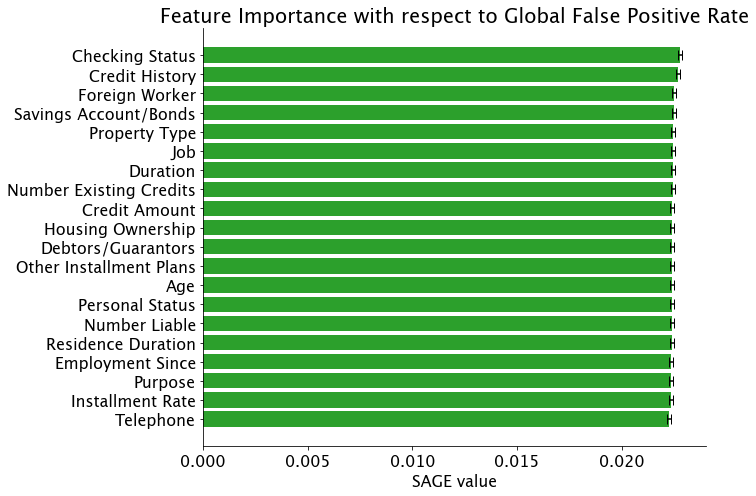

In [8]:
sage_values_fpr.plot(feature_names, title='Feature Importance with respect to Global False Positive Rate')

# Young group FPR

In [9]:
age_col = feature_names.index("Age")

In [10]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [11]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fpr = sage.PermutationEstimator(imputer_young, 'fpr')
%time sage_values_young_fpr = estimator_young_fpr(test_young, Y_test_young, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_young_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

tn = 0, fp = 191, fn = 0, tp = 321
===> Iteration 0, Prev loss = 1.0 [outer loop]
tn = 0, fp = 191, fn = 0, tp = 321
	Loss = 1.0 [inner loop]
tn = 0, fp = 191, fn = 0, tp = 321
	Loss = 1.0 [inner loop]
tn = 1, fp = 190, fn = 0, tp = 321
	Loss = 0.9947643979057592 [inner loop]
tn = 3, fp = 188, fn = 0, tp = 321
	Loss = 0.9842931937172775 [inner loop]
tn = 5, fp = 186, fn = 0, tp = 321
	Loss = 0.9738219895287958 [inner loop]
tn = 7, fp = 184, fn = 0, tp = 321
	Loss = 0.9633507853403142 [inner loop]
tn = 8, fp = 183, fn = 3, tp = 318
	Loss = 0.9581151832460733 [inner loop]
tn = 13, fp = 178, fn = 1, tp = 320
	Loss = 0.9319371727748691 [inner loop]
tn = 16, fp = 175, fn = 1, tp = 320
	Loss = 0.9162303664921466 [inner loop]
tn = 19, fp = 172, fn = 1, tp = 320
	Loss = 0.900523560209424 [inner loop]
tn = 25, fp = 166, fn = 0, tp = 321
	Loss = 0.8691099476439791 [inner loop]
tn = 33, fp = 158, fn = 0, tp = 321
	Loss = 0.8272251308900523 [inner loop]
tn = 41, fp = 150, fn = 2, tp = 319
	Loss = 

tn = 0, fp = 216, fn = 0, tp = 296
	Loss = 1.0 [inner loop]
tn = 0, fp = 216, fn = 0, tp = 296
	Loss = 1.0 [inner loop]
tn = 2, fp = 214, fn = 0, tp = 296
	Loss = 0.9907407407407407 [inner loop]
tn = 7, fp = 209, fn = 0, tp = 296
	Loss = 0.9675925925925926 [inner loop]
tn = 10, fp = 206, fn = 0, tp = 296
	Loss = 0.9537037037037037 [inner loop]
tn = 14, fp = 202, fn = 0, tp = 296
	Loss = 0.9351851851851852 [inner loop]
tn = 20, fp = 196, fn = 1, tp = 295
	Loss = 0.9074074074074074 [inner loop]
tn = 22, fp = 194, fn = 1, tp = 295
	Loss = 0.8981481481481481 [inner loop]
tn = 35, fp = 181, fn = 1, tp = 295
	Loss = 0.8379629629629629 [inner loop]
tn = 38, fp = 178, fn = 0, tp = 296
	Loss = 0.8240740740740741 [inner loop]
tn = 46, fp = 170, fn = 1, tp = 295
	Loss = 0.7870370370370371 [inner loop]
tn = 54, fp = 162, fn = 1, tp = 295
	Loss = 0.75 [inner loop]
tn = 56, fp = 160, fn = 2, tp = 294
	Loss = 0.7407407407407407 [inner loop]
tn = 65, fp = 151, fn = 1, tp = 295
	Loss = 0.69907407407407

tn = 8, fp = 212, fn = 1, tp = 291
	Loss = 0.9636363636363636 [inner loop]
tn = 16, fp = 204, fn = 2, tp = 290
	Loss = 0.9272727272727272 [inner loop]
tn = 22, fp = 198, fn = 2, tp = 290
	Loss = 0.9 [inner loop]
tn = 25, fp = 195, fn = 2, tp = 290
	Loss = 0.8863636363636364 [inner loop]
tn = 26, fp = 194, fn = 4, tp = 288
	Loss = 0.8818181818181818 [inner loop]
tn = 33, fp = 187, fn = 3, tp = 289
	Loss = 0.85 [inner loop]
tn = 40, fp = 180, fn = 3, tp = 289
	Loss = 0.8181818181818182 [inner loop]
tn = 43, fp = 177, fn = 4, tp = 288
	Loss = 0.8045454545454546 [inner loop]
tn = 48, fp = 172, fn = 3, tp = 289
	Loss = 0.7818181818181819 [inner loop]
tn = 52, fp = 168, fn = 3, tp = 289
	Loss = 0.7636363636363637 [inner loop]
tn = 63, fp = 157, fn = 2, tp = 290
	Loss = 0.7136363636363636 [inner loop]
tn = 69, fp = 151, fn = 2, tp = 290
	Loss = 0.6863636363636364 [inner loop]
tn = 80, fp = 140, fn = 0, tp = 292
	Loss = 0.6363636363636364 [inner loop]
tn = 93, fp = 127, fn = 1, tp = 291
	Loss 

tn = 18, fp = 189, fn = 0, tp = 305
	Loss = 0.9130434782608695 [inner loop]
tn = 20, fp = 187, fn = 2, tp = 303
	Loss = 0.9033816425120773 [inner loop]
tn = 20, fp = 187, fn = 2, tp = 303
	Loss = 0.9033816425120773 [inner loop]
tn = 26, fp = 181, fn = 3, tp = 302
	Loss = 0.8743961352657005 [inner loop]
tn = 31, fp = 176, fn = 2, tp = 303
	Loss = 0.8502415458937198 [inner loop]
tn = 37, fp = 170, fn = 2, tp = 303
	Loss = 0.821256038647343 [inner loop]
tn = 42, fp = 165, fn = 1, tp = 304
	Loss = 0.7971014492753623 [inner loop]
tn = 52, fp = 155, fn = 2, tp = 303
	Loss = 0.748792270531401 [inner loop]
tn = 59, fp = 148, fn = 1, tp = 304
	Loss = 0.714975845410628 [inner loop]
tn = 66, fp = 141, fn = 3, tp = 302
	Loss = 0.6811594202898551 [inner loop]
tn = 77, fp = 130, fn = 3, tp = 302
	Loss = 0.6280193236714976 [inner loop]
tn = 91, fp = 116, fn = 1, tp = 304
	Loss = 0.5603864734299517 [inner loop]
tn = 112, fp = 95, fn = 0, tp = 305
	Loss = 0.45893719806763283 [inner loop]
StdDev Ratio =

tn = 34, fp = 171, fn = 5, tp = 302
	Loss = 0.8341463414634146 [inner loop]
tn = 38, fp = 167, fn = 7, tp = 300
	Loss = 0.8146341463414634 [inner loop]
tn = 50, fp = 155, fn = 7, tp = 300
	Loss = 0.7560975609756098 [inner loop]
tn = 59, fp = 146, fn = 5, tp = 302
	Loss = 0.7121951219512195 [inner loop]
tn = 65, fp = 140, fn = 4, tp = 303
	Loss = 0.6829268292682927 [inner loop]
tn = 72, fp = 133, fn = 2, tp = 305
	Loss = 0.6487804878048781 [inner loop]
tn = 81, fp = 124, fn = 4, tp = 303
	Loss = 0.6048780487804878 [inner loop]
tn = 88, fp = 117, fn = 2, tp = 305
	Loss = 0.5707317073170731 [inner loop]
tn = 96, fp = 109, fn = 1, tp = 306
	Loss = 0.5317073170731708 [inner loop]
tn = 104, fp = 101, fn = 0, tp = 307
	Loss = 0.4926829268292683 [inner loop]
StdDev Ratio = 0.2946 (Converge at 0.1000)
tn = 0, fp = 192, fn = 0, tp = 320
===> Iteration 21, Prev loss = 1.0 [outer loop]
tn = 0, fp = 192, fn = 0, tp = 320
	Loss = 1.0 [inner loop]
tn = 1, fp = 191, fn = 0, tp = 320
	Loss = 0.99479166

tn = 54, fp = 167, fn = 1, tp = 290
	Loss = 0.755656108597285 [inner loop]
tn = 59, fp = 162, fn = 0, tp = 291
	Loss = 0.7330316742081447 [inner loop]
tn = 71, fp = 150, fn = 1, tp = 290
	Loss = 0.6787330316742082 [inner loop]
tn = 85, fp = 136, fn = 1, tp = 290
	Loss = 0.6153846153846154 [inner loop]
tn = 93, fp = 128, fn = 0, tp = 291
	Loss = 0.579185520361991 [inner loop]
tn = 110, fp = 111, fn = 0, tp = 291
	Loss = 0.502262443438914 [inner loop]
tn = 124, fp = 97, fn = 0, tp = 291
	Loss = 0.43891402714932126 [inner loop]
StdDev Ratio = 0.2753 (Converge at 0.1000)
tn = 0, fp = 202, fn = 0, tp = 310
===> Iteration 26, Prev loss = 1.0 [outer loop]
tn = 0, fp = 202, fn = 0, tp = 310
	Loss = 1.0 [inner loop]
tn = 1, fp = 201, fn = 1, tp = 309
	Loss = 0.995049504950495 [inner loop]
tn = 3, fp = 199, fn = 1, tp = 309
	Loss = 0.9851485148514851 [inner loop]
tn = 3, fp = 199, fn = 1, tp = 309
	Loss = 0.9851485148514851 [inner loop]
tn = 7, fp = 195, fn = 1, tp = 309
	Loss = 0.96534653465346

tn = 72, fp = 144, fn = 4, tp = 292
	Loss = 0.6666666666666666 [inner loop]
tn = 84, fp = 132, fn = 2, tp = 294
	Loss = 0.6111111111111112 [inner loop]
tn = 95, fp = 121, fn = 2, tp = 294
	Loss = 0.5601851851851852 [inner loop]
tn = 108, fp = 108, fn = 1, tp = 295
	Loss = 0.5 [inner loop]
tn = 113, fp = 103, fn = 0, tp = 296
	Loss = 0.47685185185185186 [inner loop]
StdDev Ratio = 0.2798 (Converge at 0.1000)
tn = 0, fp = 228, fn = 0, tp = 284
===> Iteration 31, Prev loss = 1.0 [outer loop]
tn = 0, fp = 228, fn = 0, tp = 284
	Loss = 1.0 [inner loop]
tn = 0, fp = 228, fn = 1, tp = 283
	Loss = 1.0 [inner loop]
tn = 3, fp = 225, fn = 1, tp = 283
	Loss = 0.9868421052631579 [inner loop]
tn = 6, fp = 222, fn = 1, tp = 283
	Loss = 0.9736842105263158 [inner loop]
tn = 10, fp = 218, fn = 2, tp = 282
	Loss = 0.956140350877193 [inner loop]
tn = 13, fp = 215, fn = 2, tp = 282
	Loss = 0.9429824561403509 [inner loop]
tn = 18, fp = 210, fn = 2, tp = 282
	Loss = 0.9210526315789473 [inner loop]
tn = 20, 

tn = 89, fp = 122, fn = 1, tp = 300
	Loss = 0.5781990521327014 [inner loop]
tn = 103, fp = 108, fn = 1, tp = 300
	Loss = 0.5118483412322274 [inner loop]
tn = 115, fp = 96, fn = 0, tp = 301
	Loss = 0.4549763033175355 [inner loop]
StdDev Ratio = 0.2549 (Converge at 0.1000)
tn = 0, fp = 206, fn = 0, tp = 306
===> Iteration 36, Prev loss = 1.0 [outer loop]
tn = 0, fp = 206, fn = 0, tp = 306
	Loss = 1.0 [inner loop]
tn = 1, fp = 205, fn = 0, tp = 306
	Loss = 0.9951456310679612 [inner loop]
tn = 2, fp = 204, fn = 0, tp = 306
	Loss = 0.9902912621359223 [inner loop]
tn = 6, fp = 200, fn = 1, tp = 305
	Loss = 0.970873786407767 [inner loop]
tn = 6, fp = 200, fn = 1, tp = 305
	Loss = 0.970873786407767 [inner loop]
tn = 8, fp = 198, fn = 1, tp = 305
	Loss = 0.9611650485436893 [inner loop]
tn = 12, fp = 194, fn = 1, tp = 305
	Loss = 0.941747572815534 [inner loop]
tn = 18, fp = 188, fn = 1, tp = 305
	Loss = 0.912621359223301 [inner loop]
tn = 25, fp = 181, fn = 1, tp = 305
	Loss = 0.8786407766990292

tn = 101, fp = 95, fn = 0, tp = 316
	Loss = 0.4846938775510204 [inner loop]
StdDev Ratio = 0.2711 (Converge at 0.1000)
tn = 0, fp = 221, fn = 0, tp = 291
===> Iteration 41, Prev loss = 1.0 [outer loop]
tn = 0, fp = 221, fn = 0, tp = 291
	Loss = 1.0 [inner loop]
tn = 0, fp = 221, fn = 0, tp = 291
	Loss = 1.0 [inner loop]
tn = 0, fp = 221, fn = 0, tp = 291
	Loss = 1.0 [inner loop]
tn = 1, fp = 220, fn = 1, tp = 290
	Loss = 0.995475113122172 [inner loop]
tn = 3, fp = 218, fn = 1, tp = 290
	Loss = 0.9864253393665159 [inner loop]
tn = 4, fp = 217, fn = 3, tp = 288
	Loss = 0.9819004524886877 [inner loop]
tn = 8, fp = 213, fn = 4, tp = 287
	Loss = 0.9638009049773756 [inner loop]
tn = 15, fp = 206, fn = 5, tp = 286
	Loss = 0.9321266968325792 [inner loop]
tn = 21, fp = 200, fn = 6, tp = 285
	Loss = 0.9049773755656109 [inner loop]
tn = 24, fp = 197, fn = 6, tp = 285
	Loss = 0.8914027149321267 [inner loop]
tn = 27, fp = 194, fn = 5, tp = 286
	Loss = 0.8778280542986425 [inner loop]
tn = 34, fp = 1

tn = 0, fp = 220, fn = 0, tp = 292
	Loss = 1.0 [inner loop]
tn = 0, fp = 220, fn = 1, tp = 291
	Loss = 1.0 [inner loop]
tn = 2, fp = 218, fn = 2, tp = 290
	Loss = 0.990909090909091 [inner loop]
tn = 4, fp = 216, fn = 2, tp = 290
	Loss = 0.9818181818181818 [inner loop]
tn = 5, fp = 215, fn = 2, tp = 290
	Loss = 0.9772727272727273 [inner loop]
tn = 9, fp = 211, fn = 3, tp = 289
	Loss = 0.9590909090909091 [inner loop]
tn = 18, fp = 202, fn = 3, tp = 289
	Loss = 0.9181818181818182 [inner loop]
tn = 23, fp = 197, fn = 2, tp = 290
	Loss = 0.8954545454545455 [inner loop]
tn = 25, fp = 195, fn = 2, tp = 290
	Loss = 0.8863636363636364 [inner loop]
tn = 27, fp = 193, fn = 0, tp = 292
	Loss = 0.8772727272727273 [inner loop]
tn = 32, fp = 188, fn = 2, tp = 290
	Loss = 0.8545454545454545 [inner loop]
tn = 38, fp = 182, fn = 2, tp = 290
	Loss = 0.8272727272727273 [inner loop]
tn = 43, fp = 177, fn = 2, tp = 290
	Loss = 0.8045454545454546 [inner loop]
tn = 49, fp = 171, fn = 2, tp = 290
	Loss = 0.777

tn = 5, fp = 211, fn = 1, tp = 295
	Loss = 0.9768518518518519 [inner loop]
tn = 10, fp = 206, fn = 1, tp = 295
	Loss = 0.9537037037037037 [inner loop]
tn = 11, fp = 205, fn = 1, tp = 295
	Loss = 0.9490740740740741 [inner loop]
tn = 15, fp = 201, fn = 1, tp = 295
	Loss = 0.9305555555555556 [inner loop]
tn = 24, fp = 192, fn = 1, tp = 295
	Loss = 0.8888888888888888 [inner loop]
tn = 30, fp = 186, fn = 1, tp = 295
	Loss = 0.8611111111111112 [inner loop]
tn = 32, fp = 184, fn = 1, tp = 295
	Loss = 0.8518518518518519 [inner loop]
tn = 38, fp = 178, fn = 2, tp = 294
	Loss = 0.8240740740740741 [inner loop]
tn = 46, fp = 170, fn = 1, tp = 295
	Loss = 0.7870370370370371 [inner loop]
tn = 49, fp = 167, fn = 3, tp = 293
	Loss = 0.7731481481481481 [inner loop]
tn = 55, fp = 161, fn = 7, tp = 289
	Loss = 0.7453703703703703 [inner loop]
tn = 66, fp = 150, fn = 5, tp = 291
	Loss = 0.6944444444444444 [inner loop]
tn = 73, fp = 143, fn = 4, tp = 292
	Loss = 0.6620370370370371 [inner loop]
tn = 82, fp =

tn = 12, fp = 213, fn = 0, tp = 287
	Loss = 0.9466666666666667 [inner loop]
tn = 16, fp = 209, fn = 1, tp = 286
	Loss = 0.9288888888888889 [inner loop]
tn = 25, fp = 200, fn = 2, tp = 285
	Loss = 0.8888888888888888 [inner loop]
tn = 29, fp = 196, fn = 3, tp = 284
	Loss = 0.8711111111111111 [inner loop]
tn = 34, fp = 191, fn = 3, tp = 284
	Loss = 0.8488888888888889 [inner loop]
tn = 37, fp = 188, fn = 3, tp = 284
	Loss = 0.8355555555555556 [inner loop]
tn = 43, fp = 182, fn = 4, tp = 283
	Loss = 0.8088888888888889 [inner loop]
tn = 55, fp = 170, fn = 4, tp = 283
	Loss = 0.7555555555555555 [inner loop]
tn = 62, fp = 163, fn = 4, tp = 283
	Loss = 0.7244444444444444 [inner loop]
tn = 70, fp = 155, fn = 3, tp = 284
	Loss = 0.6888888888888889 [inner loop]
tn = 83, fp = 142, fn = 2, tp = 285
	Loss = 0.6311111111111111 [inner loop]
tn = 88, fp = 137, fn = 3, tp = 284
	Loss = 0.6088888888888889 [inner loop]
tn = 101, fp = 124, fn = 3, tp = 284
	Loss = 0.5511111111111111 [inner loop]
tn = 115, f

tn = 13, fp = 202, fn = 3, tp = 294
	Loss = 0.9395348837209302 [inner loop]
tn = 17, fp = 198, fn = 3, tp = 294
	Loss = 0.9209302325581395 [inner loop]
tn = 23, fp = 192, fn = 2, tp = 295
	Loss = 0.8930232558139535 [inner loop]
tn = 33, fp = 182, fn = 0, tp = 297
	Loss = 0.8465116279069768 [inner loop]
tn = 38, fp = 177, fn = 1, tp = 296
	Loss = 0.8232558139534883 [inner loop]
tn = 43, fp = 172, fn = 4, tp = 293
	Loss = 0.8 [inner loop]
tn = 53, fp = 162, fn = 3, tp = 294
	Loss = 0.7534883720930232 [inner loop]
tn = 56, fp = 159, fn = 2, tp = 295
	Loss = 0.7395348837209302 [inner loop]
tn = 62, fp = 153, fn = 1, tp = 296
	Loss = 0.7116279069767442 [inner loop]
tn = 68, fp = 147, fn = 2, tp = 295
	Loss = 0.6837209302325581 [inner loop]
tn = 88, fp = 127, fn = 2, tp = 295
	Loss = 0.5906976744186047 [inner loop]
tn = 99, fp = 116, fn = 0, tp = 297
	Loss = 0.5395348837209303 [inner loop]
tn = 110, fp = 105, fn = 0, tp = 297
	Loss = 0.4883720930232558 [inner loop]
StdDev Ratio = 0.1592 (Con

tn = 26, fp = 189, fn = 2, tp = 295
	Loss = 0.8790697674418605 [inner loop]
tn = 31, fp = 184, fn = 3, tp = 294
	Loss = 0.8558139534883721 [inner loop]
tn = 40, fp = 175, fn = 2, tp = 295
	Loss = 0.813953488372093 [inner loop]
tn = 49, fp = 166, fn = 3, tp = 294
	Loss = 0.772093023255814 [inner loop]
tn = 56, fp = 159, fn = 2, tp = 295
	Loss = 0.7395348837209302 [inner loop]
tn = 64, fp = 151, fn = 4, tp = 293
	Loss = 0.7023255813953488 [inner loop]
tn = 74, fp = 141, fn = 3, tp = 294
	Loss = 0.6558139534883721 [inner loop]
tn = 80, fp = 135, fn = 2, tp = 295
	Loss = 0.627906976744186 [inner loop]
tn = 94, fp = 121, fn = 0, tp = 297
	Loss = 0.5627906976744186 [inner loop]
tn = 103, fp = 112, fn = 0, tp = 297
	Loss = 0.5209302325581395 [inner loop]
StdDev Ratio = 0.1531 (Converge at 0.1000)
tn = 0, fp = 210, fn = 0, tp = 302
===> Iteration 67, Prev loss = 1.0 [outer loop]
tn = 0, fp = 210, fn = 0, tp = 302
	Loss = 1.0 [inner loop]
tn = 1, fp = 209, fn = 0, tp = 302
	Loss = 0.99523809523

tn = 51, fp = 182, fn = 5, tp = 274
	Loss = 0.7811158798283262 [inner loop]
tn = 59, fp = 174, fn = 5, tp = 274
	Loss = 0.7467811158798283 [inner loop]
tn = 69, fp = 164, fn = 5, tp = 274
	Loss = 0.703862660944206 [inner loop]
tn = 76, fp = 157, fn = 4, tp = 275
	Loss = 0.6738197424892703 [inner loop]
tn = 82, fp = 151, fn = 5, tp = 274
	Loss = 0.648068669527897 [inner loop]
tn = 96, fp = 137, fn = 5, tp = 274
	Loss = 0.5879828326180258 [inner loop]
tn = 105, fp = 128, fn = 1, tp = 278
	Loss = 0.5493562231759657 [inner loop]
tn = 116, fp = 117, fn = 0, tp = 279
	Loss = 0.5021459227467812 [inner loop]
StdDev Ratio = 0.1447 (Converge at 0.1000)
tn = 0, fp = 187, fn = 0, tp = 325
===> Iteration 72, Prev loss = 1.0 [outer loop]
tn = 0, fp = 187, fn = 0, tp = 325
	Loss = 1.0 [inner loop]
tn = 0, fp = 187, fn = 0, tp = 325
	Loss = 1.0 [inner loop]
tn = 2, fp = 185, fn = 0, tp = 325
	Loss = 0.9893048128342246 [inner loop]
tn = 6, fp = 181, fn = 0, tp = 325
	Loss = 0.9679144385026738 [inner lo

tn = 63, fp = 164, fn = 4, tp = 281
	Loss = 0.7224669603524229 [inner loop]
tn = 73, fp = 154, fn = 3, tp = 282
	Loss = 0.6784140969162996 [inner loop]
tn = 79, fp = 148, fn = 1, tp = 284
	Loss = 0.6519823788546255 [inner loop]
tn = 90, fp = 137, fn = 0, tp = 285
	Loss = 0.6035242290748899 [inner loop]
tn = 104, fp = 123, fn = 0, tp = 285
	Loss = 0.5418502202643172 [inner loop]
tn = 114, fp = 113, fn = 0, tp = 285
	Loss = 0.4977973568281938 [inner loop]
StdDev Ratio = 0.1509 (Converge at 0.1000)
tn = 0, fp = 237, fn = 0, tp = 275
===> Iteration 77, Prev loss = 1.0 [outer loop]
tn = 0, fp = 237, fn = 0, tp = 275
	Loss = 1.0 [inner loop]
tn = 1, fp = 236, fn = 1, tp = 274
	Loss = 0.9957805907172996 [inner loop]
tn = 2, fp = 235, fn = 1, tp = 274
	Loss = 0.9915611814345991 [inner loop]
tn = 5, fp = 232, fn = 1, tp = 274
	Loss = 0.9789029535864979 [inner loop]
tn = 8, fp = 229, fn = 1, tp = 274
	Loss = 0.9662447257383966 [inner loop]
tn = 12, fp = 225, fn = 1, tp = 274
	Loss = 0.9493670886

tn = 69, fp = 135, fn = 2, tp = 306
	Loss = 0.6617647058823529 [inner loop]
tn = 79, fp = 125, fn = 2, tp = 306
	Loss = 0.6127450980392157 [inner loop]
tn = 94, fp = 110, fn = 0, tp = 308
	Loss = 0.5392156862745098 [inner loop]
tn = 106, fp = 98, fn = 0, tp = 308
	Loss = 0.4803921568627451 [inner loop]
StdDev Ratio = 0.1456 (Converge at 0.1000)
tn = 0, fp = 219, fn = 0, tp = 293
===> Iteration 82, Prev loss = 1.0 [outer loop]
tn = 0, fp = 219, fn = 0, tp = 293
	Loss = 1.0 [inner loop]
tn = 0, fp = 219, fn = 0, tp = 293
	Loss = 1.0 [inner loop]
tn = 1, fp = 218, fn = 1, tp = 292
	Loss = 0.9954337899543378 [inner loop]
tn = 3, fp = 216, fn = 1, tp = 292
	Loss = 0.9863013698630136 [inner loop]
tn = 5, fp = 214, fn = 1, tp = 292
	Loss = 0.9771689497716894 [inner loop]
tn = 12, fp = 207, fn = 2, tp = 291
	Loss = 0.9452054794520548 [inner loop]
tn = 14, fp = 205, fn = 2, tp = 291
	Loss = 0.9360730593607306 [inner loop]
tn = 18, fp = 201, fn = 2, tp = 291
	Loss = 0.9178082191780822 [inner loo

tn = 5, fp = 198, fn = 0, tp = 309
	Loss = 0.9753694581280788 [inner loop]
tn = 8, fp = 195, fn = 1, tp = 308
	Loss = 0.9605911330049262 [inner loop]
tn = 13, fp = 190, fn = 0, tp = 309
	Loss = 0.9359605911330049 [inner loop]
tn = 17, fp = 186, fn = 0, tp = 309
	Loss = 0.916256157635468 [inner loop]
tn = 22, fp = 181, fn = 1, tp = 308
	Loss = 0.8916256157635468 [inner loop]
tn = 25, fp = 178, fn = 1, tp = 308
	Loss = 0.8768472906403941 [inner loop]
tn = 26, fp = 177, fn = 2, tp = 307
	Loss = 0.8719211822660099 [inner loop]
tn = 36, fp = 167, fn = 3, tp = 306
	Loss = 0.8226600985221675 [inner loop]
tn = 43, fp = 160, fn = 1, tp = 308
	Loss = 0.7881773399014779 [inner loop]
tn = 49, fp = 154, fn = 1, tp = 308
	Loss = 0.7586206896551724 [inner loop]
tn = 57, fp = 146, fn = 2, tp = 307
	Loss = 0.7192118226600985 [inner loop]
tn = 67, fp = 136, fn = 2, tp = 307
	Loss = 0.6699507389162561 [inner loop]
tn = 72, fp = 131, fn = 3, tp = 306
	Loss = 0.645320197044335 [inner loop]
tn = 79, fp = 12

tn = 10, fp = 177, fn = 2, tp = 323
	Loss = 0.946524064171123 [inner loop]
tn = 14, fp = 173, fn = 4, tp = 321
	Loss = 0.9251336898395722 [inner loop]
tn = 14, fp = 173, fn = 3, tp = 322
	Loss = 0.9251336898395722 [inner loop]
tn = 22, fp = 165, fn = 2, tp = 323
	Loss = 0.8823529411764706 [inner loop]
tn = 22, fp = 165, fn = 2, tp = 323
	Loss = 0.8823529411764706 [inner loop]
tn = 27, fp = 160, fn = 1, tp = 324
	Loss = 0.8556149732620321 [inner loop]
tn = 31, fp = 156, fn = 1, tp = 324
	Loss = 0.8342245989304813 [inner loop]
tn = 38, fp = 149, fn = 1, tp = 324
	Loss = 0.7967914438502673 [inner loop]
tn = 43, fp = 144, fn = 3, tp = 322
	Loss = 0.7700534759358288 [inner loop]
tn = 55, fp = 132, fn = 4, tp = 321
	Loss = 0.7058823529411765 [inner loop]
tn = 60, fp = 127, fn = 2, tp = 323
	Loss = 0.679144385026738 [inner loop]
tn = 72, fp = 115, fn = 0, tp = 325
	Loss = 0.6149732620320856 [inner loop]
tn = 82, fp = 105, fn = 0, tp = 325
	Loss = 0.5614973262032086 [inner loop]
tn = 91, fp = 

tn = 23, fp = 173, fn = 0, tp = 316
	Loss = 0.8826530612244898 [inner loop]
tn = 31, fp = 165, fn = 1, tp = 315
	Loss = 0.8418367346938775 [inner loop]
tn = 37, fp = 159, fn = 1, tp = 315
	Loss = 0.8112244897959183 [inner loop]
tn = 39, fp = 157, fn = 2, tp = 314
	Loss = 0.8010204081632653 [inner loop]
tn = 40, fp = 156, fn = 0, tp = 316
	Loss = 0.7959183673469388 [inner loop]
tn = 51, fp = 145, fn = 3, tp = 313
	Loss = 0.7397959183673469 [inner loop]
tn = 60, fp = 136, fn = 3, tp = 313
	Loss = 0.6938775510204082 [inner loop]
tn = 69, fp = 127, fn = 6, tp = 310
	Loss = 0.6479591836734694 [inner loop]
tn = 78, fp = 118, fn = 2, tp = 314
	Loss = 0.6020408163265306 [inner loop]
tn = 90, fp = 106, fn = 1, tp = 315
	Loss = 0.5408163265306123 [inner loop]
tn = 101, fp = 95, fn = 0, tp = 316
	Loss = 0.4846938775510204 [inner loop]
StdDev Ratio = 0.1379 (Converge at 0.1000)
tn = 0, fp = 217, fn = 0, tp = 295
===> Iteration 98, Prev loss = 1.0 [outer loop]
tn = 0, fp = 217, fn = 0, tp = 295
	Lo

tn = 40, fp = 164, fn = 6, tp = 302
	Loss = 0.803921568627451 [inner loop]
tn = 51, fp = 153, fn = 4, tp = 304
	Loss = 0.75 [inner loop]
tn = 57, fp = 147, fn = 3, tp = 305
	Loss = 0.7205882352941176 [inner loop]
tn = 57, fp = 147, fn = 3, tp = 305
	Loss = 0.7205882352941176 [inner loop]
tn = 69, fp = 135, fn = 2, tp = 306
	Loss = 0.6617647058823529 [inner loop]
tn = 74, fp = 130, fn = 2, tp = 306
	Loss = 0.6372549019607843 [inner loop]
tn = 83, fp = 121, fn = 1, tp = 307
	Loss = 0.5931372549019608 [inner loop]
tn = 91, fp = 113, fn = 0, tp = 308
	Loss = 0.553921568627451 [inner loop]
tn = 103, fp = 101, fn = 0, tp = 308
	Loss = 0.4950980392156863 [inner loop]
StdDev Ratio = 0.1345 (Converge at 0.1000)
tn = 0, fp = 221, fn = 0, tp = 291
===> Iteration 103, Prev loss = 1.0 [outer loop]
tn = 0, fp = 221, fn = 0, tp = 291
	Loss = 1.0 [inner loop]
tn = 0, fp = 221, fn = 0, tp = 291
	Loss = 1.0 [inner loop]
tn = 1, fp = 220, fn = 1, tp = 290
	Loss = 0.995475113122172 [inner loop]
tn = 3, fp

tn = 49, fp = 162, fn = 3, tp = 298
	Loss = 0.7677725118483413 [inner loop]
tn = 60, fp = 151, fn = 1, tp = 300
	Loss = 0.7156398104265402 [inner loop]
tn = 66, fp = 145, fn = 2, tp = 299
	Loss = 0.6872037914691943 [inner loop]
tn = 74, fp = 137, fn = 2, tp = 299
	Loss = 0.6492890995260664 [inner loop]
tn = 90, fp = 121, fn = 1, tp = 300
	Loss = 0.5734597156398105 [inner loop]
tn = 103, fp = 108, fn = 2, tp = 299
	Loss = 0.5118483412322274 [inner loop]
tn = 111, fp = 100, fn = 0, tp = 301
	Loss = 0.47393364928909953 [inner loop]
StdDev Ratio = 0.1351 (Converge at 0.1000)
tn = 0, fp = 241, fn = 0, tp = 271
===> Iteration 108, Prev loss = 1.0 [outer loop]
tn = 0, fp = 241, fn = 0, tp = 271
	Loss = 1.0 [inner loop]
tn = 1, fp = 240, fn = 0, tp = 271
	Loss = 0.995850622406639 [inner loop]
tn = 4, fp = 237, fn = 0, tp = 271
	Loss = 0.983402489626556 [inner loop]
tn = 4, fp = 237, fn = 0, tp = 271
	Loss = 0.983402489626556 [inner loop]
tn = 9, fp = 232, fn = 0, tp = 271
	Loss = 0.96265560165

tn = 76, fp = 140, fn = 1, tp = 295
	Loss = 0.6481481481481481 [inner loop]
tn = 82, fp = 134, fn = 1, tp = 295
	Loss = 0.6203703703703703 [inner loop]
tn = 97, fp = 119, fn = 1, tp = 295
	Loss = 0.5509259259259259 [inner loop]
tn = 109, fp = 107, fn = 0, tp = 296
	Loss = 0.49537037037037035 [inner loop]
tn = 116, fp = 100, fn = 0, tp = 296
	Loss = 0.46296296296296297 [inner loop]
StdDev Ratio = 0.1322 (Converge at 0.1000)
tn = 0, fp = 190, fn = 0, tp = 322
===> Iteration 113, Prev loss = 1.0 [outer loop]
tn = 0, fp = 190, fn = 0, tp = 322
	Loss = 1.0 [inner loop]
tn = 0, fp = 190, fn = 0, tp = 322
	Loss = 1.0 [inner loop]
tn = 0, fp = 190, fn = 0, tp = 322
	Loss = 1.0 [inner loop]
tn = 2, fp = 188, fn = 0, tp = 322
	Loss = 0.9894736842105263 [inner loop]
tn = 7, fp = 183, fn = 0, tp = 322
	Loss = 0.9631578947368421 [inner loop]
tn = 10, fp = 180, fn = 0, tp = 322
	Loss = 0.9473684210526315 [inner loop]
tn = 13, fp = 177, fn = 2, tp = 320
	Loss = 0.9315789473684211 [inner loop]
tn = 18

tn = 96, fp = 99, fn = 0, tp = 317
	Loss = 0.5076923076923077 [inner loop]
tn = 104, fp = 91, fn = 0, tp = 317
	Loss = 0.4666666666666667 [inner loop]
StdDev Ratio = 0.1341 (Converge at 0.1000)
tn = 0, fp = 201, fn = 0, tp = 311
===> Iteration 118, Prev loss = 1.0 [outer loop]
tn = 0, fp = 201, fn = 0, tp = 311
	Loss = 1.0 [inner loop]
tn = 1, fp = 200, fn = 0, tp = 311
	Loss = 0.9950248756218906 [inner loop]
tn = 1, fp = 200, fn = 1, tp = 310
	Loss = 0.9950248756218906 [inner loop]
tn = 5, fp = 196, fn = 2, tp = 309
	Loss = 0.9751243781094527 [inner loop]
tn = 5, fp = 196, fn = 2, tp = 309
	Loss = 0.9751243781094527 [inner loop]
tn = 10, fp = 191, fn = 2, tp = 309
	Loss = 0.9502487562189055 [inner loop]
tn = 13, fp = 188, fn = 2, tp = 309
	Loss = 0.9353233830845771 [inner loop]
tn = 16, fp = 185, fn = 2, tp = 309
	Loss = 0.9203980099502488 [inner loop]
tn = 24, fp = 177, fn = 4, tp = 307
	Loss = 0.8805970149253731 [inner loop]
tn = 30, fp = 171, fn = 4, tp = 307
	Loss = 0.850746268656

tn = 0, fp = 200, fn = 0, tp = 312
===> Iteration 123, Prev loss = 1.0 [outer loop]
tn = 0, fp = 200, fn = 0, tp = 312
	Loss = 1.0 [inner loop]
tn = 0, fp = 200, fn = 0, tp = 312
	Loss = 1.0 [inner loop]
tn = 2, fp = 198, fn = 0, tp = 312
	Loss = 0.99 [inner loop]
tn = 3, fp = 197, fn = 0, tp = 312
	Loss = 0.985 [inner loop]
tn = 4, fp = 196, fn = 0, tp = 312
	Loss = 0.98 [inner loop]
tn = 6, fp = 194, fn = 0, tp = 312
	Loss = 0.97 [inner loop]
tn = 9, fp = 191, fn = 1, tp = 311
	Loss = 0.955 [inner loop]
tn = 14, fp = 186, fn = 1, tp = 311
	Loss = 0.93 [inner loop]
tn = 18, fp = 182, fn = 1, tp = 311
	Loss = 0.91 [inner loop]
tn = 22, fp = 178, fn = 1, tp = 311
	Loss = 0.89 [inner loop]
tn = 29, fp = 171, fn = 3, tp = 309
	Loss = 0.855 [inner loop]
tn = 36, fp = 164, fn = 5, tp = 307
	Loss = 0.82 [inner loop]
tn = 47, fp = 153, fn = 3, tp = 309
	Loss = 0.765 [inner loop]
tn = 49, fp = 151, fn = 3, tp = 309
	Loss = 0.755 [inner loop]
tn = 61, fp = 139, fn = 1, tp = 311
	Loss = 0.695 [i

tn = 9, fp = 198, fn = 0, tp = 305
	Loss = 0.9565217391304348 [inner loop]
tn = 12, fp = 195, fn = 0, tp = 305
	Loss = 0.9420289855072463 [inner loop]
tn = 16, fp = 191, fn = 0, tp = 305
	Loss = 0.9227053140096618 [inner loop]
tn = 22, fp = 185, fn = 0, tp = 305
	Loss = 0.893719806763285 [inner loop]
tn = 28, fp = 179, fn = 0, tp = 305
	Loss = 0.8647342995169082 [inner loop]
tn = 34, fp = 173, fn = 2, tp = 303
	Loss = 0.8357487922705314 [inner loop]
tn = 41, fp = 166, fn = 2, tp = 303
	Loss = 0.8019323671497585 [inner loop]
tn = 38, fp = 169, fn = 1, tp = 304
	Loss = 0.8164251207729468 [inner loop]
tn = 49, fp = 158, fn = 0, tp = 305
	Loss = 0.7632850241545893 [inner loop]
tn = 58, fp = 149, fn = 3, tp = 302
	Loss = 0.7198067632850241 [inner loop]
tn = 67, fp = 140, fn = 2, tp = 303
	Loss = 0.6763285024154589 [inner loop]
tn = 73, fp = 134, fn = 2, tp = 303
	Loss = 0.6473429951690821 [inner loop]
tn = 84, fp = 123, fn = 1, tp = 304
	Loss = 0.5942028985507246 [inner loop]
tn = 92, fp = 

tn = 16, fp = 215, fn = 2, tp = 279
	Loss = 0.9307359307359307 [inner loop]
tn = 23, fp = 208, fn = 1, tp = 280
	Loss = 0.9004329004329005 [inner loop]
tn = 34, fp = 197, fn = 1, tp = 280
	Loss = 0.8528138528138528 [inner loop]
tn = 39, fp = 192, fn = 3, tp = 278
	Loss = 0.8311688311688312 [inner loop]
tn = 41, fp = 190, fn = 4, tp = 277
	Loss = 0.8225108225108225 [inner loop]
tn = 48, fp = 183, fn = 5, tp = 276
	Loss = 0.7922077922077922 [inner loop]
tn = 60, fp = 171, fn = 6, tp = 275
	Loss = 0.7402597402597403 [inner loop]
tn = 67, fp = 164, fn = 5, tp = 276
	Loss = 0.70995670995671 [inner loop]
tn = 80, fp = 151, fn = 2, tp = 279
	Loss = 0.6536796536796536 [inner loop]
tn = 95, fp = 136, fn = 4, tp = 277
	Loss = 0.5887445887445888 [inner loop]
tn = 102, fp = 129, fn = 2, tp = 279
	Loss = 0.5584415584415584 [inner loop]
tn = 116, fp = 115, fn = 0, tp = 281
	Loss = 0.49783549783549785 [inner loop]
tn = 125, fp = 106, fn = 0, tp = 281
	Loss = 0.4588744588744589 [inner loop]
StdDev Rat

tn = 29, fp = 187, fn = 3, tp = 293
	Loss = 0.8657407407407407 [inner loop]
tn = 34, fp = 182, fn = 4, tp = 292
	Loss = 0.8425925925925926 [inner loop]
tn = 43, fp = 173, fn = 5, tp = 291
	Loss = 0.8009259259259259 [inner loop]
tn = 53, fp = 163, fn = 5, tp = 291
	Loss = 0.7546296296296297 [inner loop]
tn = 62, fp = 154, fn = 4, tp = 292
	Loss = 0.7129629629629629 [inner loop]
tn = 71, fp = 145, fn = 3, tp = 293
	Loss = 0.6712962962962963 [inner loop]
tn = 79, fp = 137, fn = 4, tp = 292
	Loss = 0.6342592592592593 [inner loop]
tn = 89, fp = 127, fn = 3, tp = 293
	Loss = 0.5879629629629629 [inner loop]
tn = 97, fp = 119, fn = 3, tp = 293
	Loss = 0.5509259259259259 [inner loop]
tn = 103, fp = 113, fn = 1, tp = 295
	Loss = 0.5231481481481481 [inner loop]
tn = 117, fp = 99, fn = 0, tp = 296
	Loss = 0.4583333333333333 [inner loop]
StdDev Ratio = 0.1261 (Converge at 0.1000)
tn = 0, fp = 205, fn = 0, tp = 307
===> Iteration 139, Prev loss = 1.0 [outer loop]
tn = 0, fp = 205, fn = 0, tp = 307
	

tn = 32, fp = 187, fn = 2, tp = 291
	Loss = 0.8538812785388128 [inner loop]
tn = 39, fp = 180, fn = 1, tp = 292
	Loss = 0.821917808219178 [inner loop]
tn = 45, fp = 174, fn = 1, tp = 292
	Loss = 0.7945205479452054 [inner loop]
tn = 53, fp = 166, fn = 2, tp = 291
	Loss = 0.7579908675799086 [inner loop]
tn = 59, fp = 160, fn = 3, tp = 290
	Loss = 0.730593607305936 [inner loop]
tn = 71, fp = 148, fn = 1, tp = 292
	Loss = 0.6757990867579908 [inner loop]
tn = 85, fp = 134, fn = 1, tp = 292
	Loss = 0.6118721461187214 [inner loop]
tn = 93, fp = 126, fn = 0, tp = 293
	Loss = 0.5753424657534246 [inner loop]
tn = 108, fp = 111, fn = 0, tp = 293
	Loss = 0.5068493150684932 [inner loop]
StdDev Ratio = 0.1271 (Converge at 0.1000)
tn = 0, fp = 225, fn = 0, tp = 287
===> Iteration 144, Prev loss = 1.0 [outer loop]
tn = 0, fp = 225, fn = 0, tp = 287
	Loss = 1.0 [inner loop]
tn = 0, fp = 225, fn = 0, tp = 287
	Loss = 1.0 [inner loop]
tn = 2, fp = 223, fn = 0, tp = 287
	Loss = 0.9911111111111112 [inner l

tn = 62, fp = 149, fn = 2, tp = 299
	Loss = 0.7061611374407583 [inner loop]
tn = 66, fp = 145, fn = 4, tp = 297
	Loss = 0.6872037914691943 [inner loop]
tn = 79, fp = 132, fn = 1, tp = 300
	Loss = 0.6255924170616114 [inner loop]
tn = 88, fp = 123, fn = 1, tp = 300
	Loss = 0.5829383886255924 [inner loop]
tn = 99, fp = 112, fn = 0, tp = 301
	Loss = 0.5308056872037915 [inner loop]
tn = 114, fp = 97, fn = 0, tp = 301
	Loss = 0.4597156398104265 [inner loop]
StdDev Ratio = 0.1267 (Converge at 0.1000)
tn = 0, fp = 199, fn = 0, tp = 313
===> Iteration 149, Prev loss = 1.0 [outer loop]
tn = 0, fp = 199, fn = 0, tp = 313
	Loss = 1.0 [inner loop]
tn = 0, fp = 199, fn = 0, tp = 313
	Loss = 1.0 [inner loop]
tn = 0, fp = 199, fn = 0, tp = 313
	Loss = 1.0 [inner loop]
tn = 2, fp = 197, fn = 0, tp = 313
	Loss = 0.9899497487437185 [inner loop]
tn = 7, fp = 192, fn = 0, tp = 313
	Loss = 0.964824120603015 [inner loop]
tn = 9, fp = 190, fn = 0, tp = 313
	Loss = 0.9547738693467337 [inner loop]
tn = 12, fp =

tn = 71, fp = 137, fn = 6, tp = 298
	Loss = 0.6586538461538461 [inner loop]
tn = 80, fp = 128, fn = 3, tp = 301
	Loss = 0.6153846153846154 [inner loop]
tn = 94, fp = 114, fn = 2, tp = 302
	Loss = 0.5480769230769231 [inner loop]
tn = 105, fp = 103, fn = 0, tp = 304
	Loss = 0.4951923076923077 [inner loop]
StdDev Ratio = 0.1317 (Converge at 0.1000)
tn = 0, fp = 227, fn = 0, tp = 285
===> Iteration 154, Prev loss = 1.0 [outer loop]
tn = 0, fp = 227, fn = 0, tp = 285
	Loss = 1.0 [inner loop]
tn = 1, fp = 226, fn = 0, tp = 285
	Loss = 0.9955947136563876 [inner loop]
tn = 3, fp = 224, fn = 0, tp = 285
	Loss = 0.986784140969163 [inner loop]
tn = 4, fp = 223, fn = 0, tp = 285
	Loss = 0.9823788546255506 [inner loop]
tn = 5, fp = 222, fn = 1, tp = 284
	Loss = 0.9779735682819384 [inner loop]
tn = 10, fp = 217, fn = 3, tp = 282
	Loss = 0.9559471365638766 [inner loop]
tn = 12, fp = 215, fn = 3, tp = 282
	Loss = 0.947136563876652 [inner loop]
tn = 17, fp = 210, fn = 4, tp = 281
	Loss = 0.925110132158

tn = 114, fp = 117, fn = 1, tp = 280
	Loss = 0.5064935064935064 [inner loop]
tn = 122, fp = 109, fn = 0, tp = 281
	Loss = 0.47186147186147187 [inner loop]
StdDev Ratio = 0.1277 (Converge at 0.1000)
tn = 0, fp = 200, fn = 0, tp = 312
===> Iteration 159, Prev loss = 1.0 [outer loop]
tn = 0, fp = 200, fn = 0, tp = 312
	Loss = 1.0 [inner loop]
tn = 1, fp = 199, fn = 0, tp = 312
	Loss = 0.995 [inner loop]
tn = 5, fp = 195, fn = 0, tp = 312
	Loss = 0.975 [inner loop]
tn = 6, fp = 194, fn = 0, tp = 312
	Loss = 0.97 [inner loop]
tn = 8, fp = 192, fn = 0, tp = 312
	Loss = 0.96 [inner loop]
tn = 10, fp = 190, fn = 0, tp = 312
	Loss = 0.95 [inner loop]
tn = 15, fp = 185, fn = 1, tp = 311
	Loss = 0.925 [inner loop]
tn = 20, fp = 180, fn = 1, tp = 311
	Loss = 0.9 [inner loop]
tn = 22, fp = 178, fn = 0, tp = 312
	Loss = 0.89 [inner loop]
tn = 26, fp = 174, fn = 0, tp = 312
	Loss = 0.87 [inner loop]
tn = 36, fp = 164, fn = 1, tp = 311
	Loss = 0.82 [inner loop]
tn = 42, fp = 158, fn = 2, tp = 310
	Los

tn = 2, fp = 208, fn = 0, tp = 302
	Loss = 0.9904761904761905 [inner loop]
tn = 4, fp = 206, fn = 1, tp = 301
	Loss = 0.9809523809523809 [inner loop]
tn = 6, fp = 204, fn = 2, tp = 300
	Loss = 0.9714285714285714 [inner loop]
tn = 10, fp = 200, fn = 3, tp = 299
	Loss = 0.9523809523809523 [inner loop]
tn = 11, fp = 199, fn = 3, tp = 299
	Loss = 0.9476190476190476 [inner loop]
tn = 12, fp = 198, fn = 2, tp = 300
	Loss = 0.9428571428571428 [inner loop]
tn = 16, fp = 194, fn = 2, tp = 300
	Loss = 0.9238095238095239 [inner loop]
tn = 21, fp = 189, fn = 4, tp = 298
	Loss = 0.9 [inner loop]
tn = 32, fp = 178, fn = 4, tp = 298
	Loss = 0.8476190476190476 [inner loop]
tn = 43, fp = 167, fn = 3, tp = 299
	Loss = 0.7952380952380952 [inner loop]
tn = 46, fp = 164, fn = 2, tp = 300
	Loss = 0.780952380952381 [inner loop]
tn = 52, fp = 158, fn = 1, tp = 301
	Loss = 0.7523809523809524 [inner loop]
tn = 61, fp = 149, fn = 1, tp = 301
	Loss = 0.7095238095238096 [inner loop]
tn = 69, fp = 141, fn = 1, tp =

tn = 9, fp = 205, fn = 2, tp = 296
	Loss = 0.9579439252336449 [inner loop]
tn = 13, fp = 201, fn = 1, tp = 297
	Loss = 0.9392523364485982 [inner loop]
tn = 14, fp = 200, fn = 0, tp = 298
	Loss = 0.9345794392523364 [inner loop]
tn = 18, fp = 196, fn = 1, tp = 297
	Loss = 0.9158878504672897 [inner loop]
tn = 21, fp = 193, fn = 2, tp = 296
	Loss = 0.9018691588785047 [inner loop]
tn = 26, fp = 188, fn = 2, tp = 296
	Loss = 0.8785046728971962 [inner loop]
tn = 28, fp = 186, fn = 2, tp = 296
	Loss = 0.8691588785046729 [inner loop]
tn = 36, fp = 178, fn = 4, tp = 294
	Loss = 0.8317757009345794 [inner loop]
tn = 49, fp = 165, fn = 4, tp = 294
	Loss = 0.7710280373831776 [inner loop]
tn = 60, fp = 154, fn = 5, tp = 293
	Loss = 0.719626168224299 [inner loop]
tn = 65, fp = 149, fn = 5, tp = 293
	Loss = 0.6962616822429907 [inner loop]
tn = 72, fp = 142, fn = 3, tp = 295
	Loss = 0.6635514018691588 [inner loop]
tn = 82, fp = 132, fn = 3, tp = 295
	Loss = 0.616822429906542 [inner loop]
tn = 97, fp = 1

tn = 8, fp = 230, fn = 0, tp = 274
	Loss = 0.9663865546218487 [inner loop]
tn = 15, fp = 223, fn = 0, tp = 274
	Loss = 0.9369747899159664 [inner loop]
tn = 16, fp = 222, fn = 0, tp = 274
	Loss = 0.9327731092436975 [inner loop]
tn = 18, fp = 220, fn = 0, tp = 274
	Loss = 0.9243697478991597 [inner loop]
tn = 26, fp = 212, fn = 0, tp = 274
	Loss = 0.8907563025210085 [inner loop]
tn = 32, fp = 206, fn = 1, tp = 273
	Loss = 0.865546218487395 [inner loop]
tn = 40, fp = 198, fn = 2, tp = 272
	Loss = 0.8319327731092437 [inner loop]
tn = 50, fp = 188, fn = 2, tp = 272
	Loss = 0.7899159663865546 [inner loop]
tn = 57, fp = 181, fn = 2, tp = 272
	Loss = 0.7605042016806722 [inner loop]
tn = 67, fp = 171, fn = 3, tp = 271
	Loss = 0.7184873949579832 [inner loop]
tn = 80, fp = 158, fn = 0, tp = 274
	Loss = 0.6638655462184874 [inner loop]
tn = 93, fp = 145, fn = 0, tp = 274
	Loss = 0.6092436974789915 [inner loop]
tn = 106, fp = 132, fn = 0, tp = 274
	Loss = 0.5546218487394958 [inner loop]
tn = 121, fp 

tn = 22, fp = 201, fn = 3, tp = 286
	Loss = 0.9013452914798207 [inner loop]
tn = 28, fp = 195, fn = 3, tp = 286
	Loss = 0.874439461883408 [inner loop]
tn = 35, fp = 188, fn = 4, tp = 285
	Loss = 0.8430493273542601 [inner loop]
tn = 49, fp = 174, fn = 5, tp = 284
	Loss = 0.7802690582959642 [inner loop]
tn = 60, fp = 163, fn = 1, tp = 288
	Loss = 0.7309417040358744 [inner loop]
tn = 64, fp = 159, fn = 2, tp = 287
	Loss = 0.7130044843049327 [inner loop]
tn = 68, fp = 155, fn = 2, tp = 287
	Loss = 0.695067264573991 [inner loop]
tn = 75, fp = 148, fn = 1, tp = 288
	Loss = 0.6636771300448431 [inner loop]
tn = 91, fp = 132, fn = 1, tp = 288
	Loss = 0.5919282511210763 [inner loop]
tn = 100, fp = 123, fn = 1, tp = 288
	Loss = 0.5515695067264574 [inner loop]
tn = 108, fp = 115, fn = 1, tp = 288
	Loss = 0.515695067264574 [inner loop]
tn = 115, fp = 108, fn = 0, tp = 289
	Loss = 0.484304932735426 [inner loop]
StdDev Ratio = 0.1257 (Converge at 0.1000)
tn = 0, fp = 208, fn = 0, tp = 304
===> Iterat

tn = 32, fp = 172, fn = 2, tp = 306
	Loss = 0.8431372549019608 [inner loop]
tn = 35, fp = 169, fn = 3, tp = 305
	Loss = 0.8284313725490197 [inner loop]
tn = 45, fp = 159, fn = 3, tp = 305
	Loss = 0.7794117647058824 [inner loop]
tn = 49, fp = 155, fn = 1, tp = 307
	Loss = 0.7598039215686274 [inner loop]
tn = 52, fp = 152, fn = 4, tp = 304
	Loss = 0.7450980392156863 [inner loop]
tn = 58, fp = 146, fn = 3, tp = 305
	Loss = 0.7156862745098039 [inner loop]
tn = 67, fp = 137, fn = 3, tp = 305
	Loss = 0.6715686274509803 [inner loop]
tn = 77, fp = 127, fn = 1, tp = 307
	Loss = 0.6225490196078431 [inner loop]
tn = 90, fp = 114, fn = 1, tp = 307
	Loss = 0.5588235294117647 [inner loop]
tn = 104, fp = 100, fn = 2, tp = 306
	Loss = 0.49019607843137253 [inner loop]
tn = 108, fp = 96, fn = 0, tp = 308
	Loss = 0.47058823529411764 [inner loop]
StdDev Ratio = 0.1203 (Converge at 0.1000)
tn = 0, fp = 216, fn = 0, tp = 296
===> Iteration 185, Prev loss = 1.0 [outer loop]
tn = 0, fp = 216, fn = 0, tp = 296

tn = 57, fp = 175, fn = 2, tp = 278
	Loss = 0.7543103448275862 [inner loop]
tn = 66, fp = 166, fn = 1, tp = 279
	Loss = 0.7155172413793104 [inner loop]
tn = 71, fp = 161, fn = 1, tp = 279
	Loss = 0.6939655172413793 [inner loop]
tn = 81, fp = 151, fn = 1, tp = 279
	Loss = 0.6508620689655172 [inner loop]
tn = 96, fp = 136, fn = 0, tp = 280
	Loss = 0.5862068965517241 [inner loop]
tn = 107, fp = 125, fn = 0, tp = 280
	Loss = 0.5387931034482759 [inner loop]
StdDev Ratio = 0.1174 (Converge at 0.1000)
tn = 0, fp = 230, fn = 0, tp = 282
===> Iteration 190, Prev loss = 1.0 [outer loop]
tn = 0, fp = 230, fn = 0, tp = 282
	Loss = 1.0 [inner loop]
tn = 1, fp = 229, fn = 0, tp = 282
	Loss = 0.9956521739130435 [inner loop]
tn = 1, fp = 229, fn = 1, tp = 281
	Loss = 0.9956521739130435 [inner loop]
tn = 7, fp = 223, fn = 1, tp = 281
	Loss = 0.9695652173913043 [inner loop]
tn = 10, fp = 220, fn = 1, tp = 281
	Loss = 0.9565217391304348 [inner loop]
tn = 14, fp = 216, fn = 2, tp = 280
	Loss = 0.939130434

tn = 74, fp = 116, fn = 2, tp = 320
	Loss = 0.6105263157894737 [inner loop]
tn = 80, fp = 110, fn = 1, tp = 321
	Loss = 0.5789473684210527 [inner loop]
tn = 89, fp = 101, fn = 0, tp = 322
	Loss = 0.531578947368421 [inner loop]
tn = 102, fp = 88, fn = 0, tp = 322
	Loss = 0.4631578947368421 [inner loop]
tn = 112, fp = 78, fn = 0, tp = 322
	Loss = 0.4105263157894737 [inner loop]
StdDev Ratio = 0.1175 (Converge at 0.1000)
tn = 0, fp = 218, fn = 0, tp = 294
===> Iteration 195, Prev loss = 1.0 [outer loop]
tn = 0, fp = 218, fn = 0, tp = 294
	Loss = 1.0 [inner loop]
tn = 0, fp = 218, fn = 0, tp = 294
	Loss = 1.0 [inner loop]
tn = 4, fp = 214, fn = 0, tp = 294
	Loss = 0.981651376146789 [inner loop]
tn = 4, fp = 214, fn = 1, tp = 293
	Loss = 0.981651376146789 [inner loop]
tn = 8, fp = 210, fn = 1, tp = 293
	Loss = 0.963302752293578 [inner loop]
tn = 12, fp = 206, fn = 2, tp = 292
	Loss = 0.944954128440367 [inner loop]
tn = 15, fp = 203, fn = 1, tp = 293
	Loss = 0.9311926605504587 [inner loop]
t

tn = 0, fp = 206, fn = 0, tp = 306
===> Iteration 200, Prev loss = 1.0 [outer loop]
tn = 0, fp = 206, fn = 0, tp = 306
	Loss = 1.0 [inner loop]
tn = 1, fp = 205, fn = 0, tp = 306
	Loss = 0.9951456310679612 [inner loop]
tn = 1, fp = 205, fn = 0, tp = 306
	Loss = 0.9951456310679612 [inner loop]
tn = 2, fp = 204, fn = 0, tp = 306
	Loss = 0.9902912621359223 [inner loop]
tn = 7, fp = 199, fn = 1, tp = 305
	Loss = 0.9660194174757282 [inner loop]
tn = 10, fp = 196, fn = 3, tp = 303
	Loss = 0.9514563106796117 [inner loop]
tn = 14, fp = 192, fn = 3, tp = 303
	Loss = 0.9320388349514563 [inner loop]
tn = 16, fp = 190, fn = 2, tp = 304
	Loss = 0.9223300970873787 [inner loop]
tn = 22, fp = 184, fn = 5, tp = 301
	Loss = 0.8932038834951457 [inner loop]
tn = 31, fp = 175, fn = 4, tp = 302
	Loss = 0.8495145631067961 [inner loop]
tn = 35, fp = 171, fn = 4, tp = 302
	Loss = 0.8300970873786407 [inner loop]
tn = 39, fp = 167, fn = 5, tp = 301
	Loss = 0.8106796116504854 [inner loop]
tn = 45, fp = 161, fn = 

tn = 0, fp = 205, fn = 0, tp = 307
	Loss = 1.0 [inner loop]
tn = 0, fp = 205, fn = 0, tp = 307
	Loss = 1.0 [inner loop]
tn = 1, fp = 204, fn = 0, tp = 307
	Loss = 0.9951219512195122 [inner loop]
tn = 5, fp = 200, fn = 0, tp = 307
	Loss = 0.975609756097561 [inner loop]
tn = 10, fp = 195, fn = 0, tp = 307
	Loss = 0.9512195121951219 [inner loop]
tn = 12, fp = 193, fn = 0, tp = 307
	Loss = 0.9414634146341463 [inner loop]
tn = 17, fp = 188, fn = 0, tp = 307
	Loss = 0.9170731707317074 [inner loop]
tn = 22, fp = 183, fn = 0, tp = 307
	Loss = 0.8926829268292683 [inner loop]
tn = 24, fp = 181, fn = 0, tp = 307
	Loss = 0.8829268292682927 [inner loop]
tn = 28, fp = 177, fn = 0, tp = 307
	Loss = 0.8634146341463415 [inner loop]
tn = 36, fp = 169, fn = 1, tp = 306
	Loss = 0.824390243902439 [inner loop]
tn = 41, fp = 164, fn = 3, tp = 304
	Loss = 0.8 [inner loop]
tn = 55, fp = 150, fn = 2, tp = 305
	Loss = 0.7317073170731707 [inner loop]
tn = 57, fp = 148, fn = 3, tp = 304
	Loss = 0.7219512195121951 

tn = 6, fp = 232, fn = 0, tp = 274
	Loss = 0.9747899159663865 [inner loop]
tn = 8, fp = 230, fn = 1, tp = 273
	Loss = 0.9663865546218487 [inner loop]
tn = 11, fp = 227, fn = 1, tp = 273
	Loss = 0.9537815126050421 [inner loop]
tn = 18, fp = 220, fn = 1, tp = 273
	Loss = 0.9243697478991597 [inner loop]
tn = 20, fp = 218, fn = 1, tp = 273
	Loss = 0.9159663865546218 [inner loop]
tn = 25, fp = 213, fn = 1, tp = 273
	Loss = 0.8949579831932774 [inner loop]
tn = 29, fp = 209, fn = 1, tp = 273
	Loss = 0.8781512605042017 [inner loop]
tn = 38, fp = 200, fn = 1, tp = 273
	Loss = 0.8403361344537815 [inner loop]
tn = 49, fp = 189, fn = 0, tp = 274
	Loss = 0.7941176470588235 [inner loop]
tn = 55, fp = 183, fn = 1, tp = 273
	Loss = 0.7689075630252101 [inner loop]
tn = 64, fp = 174, fn = 1, tp = 273
	Loss = 0.7310924369747899 [inner loop]
tn = 69, fp = 169, fn = 3, tp = 271
	Loss = 0.7100840336134454 [inner loop]
tn = 79, fp = 159, fn = 1, tp = 273
	Loss = 0.6680672268907563 [inner loop]
tn = 90, fp = 

tn = 9, fp = 203, fn = 0, tp = 300
	Loss = 0.9575471698113207 [inner loop]
tn = 16, fp = 196, fn = 0, tp = 300
	Loss = 0.9245283018867925 [inner loop]
tn = 18, fp = 194, fn = 1, tp = 299
	Loss = 0.9150943396226415 [inner loop]
tn = 20, fp = 192, fn = 0, tp = 300
	Loss = 0.9056603773584906 [inner loop]
tn = 22, fp = 190, fn = 0, tp = 300
	Loss = 0.8962264150943396 [inner loop]
tn = 29, fp = 183, fn = 0, tp = 300
	Loss = 0.8632075471698113 [inner loop]
tn = 34, fp = 178, fn = 0, tp = 300
	Loss = 0.839622641509434 [inner loop]
tn = 41, fp = 171, fn = 1, tp = 299
	Loss = 0.8066037735849056 [inner loop]
tn = 45, fp = 167, fn = 1, tp = 299
	Loss = 0.7877358490566038 [inner loop]
tn = 54, fp = 158, fn = 2, tp = 298
	Loss = 0.7452830188679245 [inner loop]
tn = 60, fp = 152, fn = 3, tp = 297
	Loss = 0.7169811320754716 [inner loop]
tn = 77, fp = 135, fn = 3, tp = 297
	Loss = 0.6367924528301887 [inner loop]
tn = 88, fp = 124, fn = 0, tp = 300
	Loss = 0.5849056603773585 [inner loop]
tn = 100, fp =

tn = 12, fp = 198, fn = 0, tp = 302
	Loss = 0.9428571428571428 [inner loop]
tn = 17, fp = 193, fn = 0, tp = 302
	Loss = 0.919047619047619 [inner loop]
tn = 23, fp = 187, fn = 0, tp = 302
	Loss = 0.8904761904761904 [inner loop]
tn = 31, fp = 179, fn = 0, tp = 302
	Loss = 0.8523809523809524 [inner loop]
tn = 42, fp = 168, fn = 0, tp = 302
	Loss = 0.8 [inner loop]
tn = 46, fp = 164, fn = 0, tp = 302
	Loss = 0.780952380952381 [inner loop]
tn = 53, fp = 157, fn = 0, tp = 302
	Loss = 0.7476190476190476 [inner loop]
tn = 64, fp = 146, fn = 1, tp = 301
	Loss = 0.6952380952380952 [inner loop]
tn = 67, fp = 143, fn = 1, tp = 301
	Loss = 0.680952380952381 [inner loop]
tn = 77, fp = 133, fn = 1, tp = 301
	Loss = 0.6333333333333333 [inner loop]
tn = 93, fp = 117, fn = 0, tp = 302
	Loss = 0.5571428571428572 [inner loop]
tn = 100, fp = 110, fn = 0, tp = 302
	Loss = 0.5238095238095238 [inner loop]
tn = 107, fp = 103, fn = 0, tp = 302
	Loss = 0.49047619047619045 [inner loop]
StdDev Ratio = 0.1148 (Conv

tn = 31, fp = 199, fn = 1, tp = 281
	Loss = 0.8652173913043478 [inner loop]
tn = 36, fp = 194, fn = 3, tp = 279
	Loss = 0.8434782608695652 [inner loop]
tn = 42, fp = 188, fn = 9, tp = 273
	Loss = 0.8173913043478261 [inner loop]
tn = 47, fp = 183, fn = 9, tp = 273
	Loss = 0.7956521739130434 [inner loop]
tn = 49, fp = 181, fn = 9, tp = 273
	Loss = 0.7869565217391304 [inner loop]
tn = 54, fp = 176, fn = 9, tp = 273
	Loss = 0.7652173913043478 [inner loop]
tn = 62, fp = 168, fn = 8, tp = 274
	Loss = 0.7304347826086957 [inner loop]
tn = 72, fp = 158, fn = 4, tp = 278
	Loss = 0.6869565217391305 [inner loop]
tn = 94, fp = 136, fn = 4, tp = 278
	Loss = 0.591304347826087 [inner loop]
tn = 109, fp = 121, fn = 1, tp = 281
	Loss = 0.5260869565217391 [inner loop]
tn = 121, fp = 109, fn = 0, tp = 282
	Loss = 0.47391304347826085 [inner loop]
StdDev Ratio = 0.1114 (Converge at 0.1000)
tn = 0, fp = 215, fn = 0, tp = 297
===> Iteration 226, Prev loss = 1.0 [outer loop]
tn = 0, fp = 215, fn = 0, tp = 297


tn = 44, fp = 170, fn = 1, tp = 297
	Loss = 0.794392523364486 [inner loop]
tn = 55, fp = 159, fn = 1, tp = 297
	Loss = 0.7429906542056075 [inner loop]
tn = 62, fp = 152, fn = 4, tp = 294
	Loss = 0.7102803738317757 [inner loop]
tn = 71, fp = 143, fn = 3, tp = 295
	Loss = 0.6682242990654206 [inner loop]
tn = 86, fp = 128, fn = 4, tp = 294
	Loss = 0.5981308411214953 [inner loop]
tn = 95, fp = 119, fn = 3, tp = 295
	Loss = 0.5560747663551402 [inner loop]
tn = 109, fp = 105, fn = 1, tp = 297
	Loss = 0.49065420560747663 [inner loop]
tn = 115, fp = 99, fn = 1, tp = 297
	Loss = 0.46261682242990654 [inner loop]
tn = 131, fp = 83, fn = 0, tp = 298
	Loss = 0.3878504672897196 [inner loop]
StdDev Ratio = 0.1105 (Converge at 0.1000)
tn = 0, fp = 230, fn = 0, tp = 282
===> Iteration 231, Prev loss = 1.0 [outer loop]
tn = 0, fp = 230, fn = 0, tp = 282
	Loss = 1.0 [inner loop]
tn = 2, fp = 228, fn = 0, tp = 282
	Loss = 0.991304347826087 [inner loop]
tn = 3, fp = 227, fn = 0, tp = 282
	Loss = 0.98695652

tn = 58, fp = 176, fn = 0, tp = 278
	Loss = 0.7521367521367521 [inner loop]
tn = 70, fp = 164, fn = 0, tp = 278
	Loss = 0.7008547008547008 [inner loop]
tn = 76, fp = 158, fn = 0, tp = 278
	Loss = 0.6752136752136753 [inner loop]
tn = 90, fp = 144, fn = 0, tp = 278
	Loss = 0.6153846153846154 [inner loop]
tn = 100, fp = 134, fn = 0, tp = 278
	Loss = 0.5726495726495726 [inner loop]
tn = 107, fp = 127, fn = 0, tp = 278
	Loss = 0.5427350427350427 [inner loop]
tn = 123, fp = 111, fn = 0, tp = 278
	Loss = 0.47435897435897434 [inner loop]
StdDev Ratio = 0.1114 (Converge at 0.1000)
tn = 0, fp = 225, fn = 0, tp = 287
===> Iteration 236, Prev loss = 1.0 [outer loop]
tn = 0, fp = 225, fn = 0, tp = 287
	Loss = 1.0 [inner loop]
tn = 0, fp = 225, fn = 2, tp = 285
	Loss = 1.0 [inner loop]
tn = 2, fp = 223, fn = 2, tp = 285
	Loss = 0.9911111111111112 [inner loop]
tn = 4, fp = 221, fn = 2, tp = 285
	Loss = 0.9822222222222222 [inner loop]
tn = 7, fp = 218, fn = 3, tp = 284
	Loss = 0.9688888888888889 [inne

tn = 83, fp = 121, fn = 3, tp = 305
	Loss = 0.5931372549019608 [inner loop]
tn = 87, fp = 117, fn = 1, tp = 307
	Loss = 0.5735294117647058 [inner loop]
tn = 101, fp = 103, fn = 1, tp = 307
	Loss = 0.5049019607843137 [inner loop]
tn = 118, fp = 86, fn = 0, tp = 308
	Loss = 0.4215686274509804 [inner loop]
StdDev Ratio = 0.1051 (Converge at 0.1000)
tn = 0, fp = 217, fn = 0, tp = 295
===> Iteration 241, Prev loss = 1.0 [outer loop]
tn = 0, fp = 217, fn = 0, tp = 295
	Loss = 1.0 [inner loop]
tn = 1, fp = 216, fn = 0, tp = 295
	Loss = 0.9953917050691244 [inner loop]
tn = 3, fp = 214, fn = 0, tp = 295
	Loss = 0.9861751152073732 [inner loop]
tn = 6, fp = 211, fn = 0, tp = 295
	Loss = 0.9723502304147466 [inner loop]
tn = 12, fp = 205, fn = 0, tp = 295
	Loss = 0.9447004608294931 [inner loop]
tn = 15, fp = 202, fn = 0, tp = 295
	Loss = 0.9308755760368663 [inner loop]
tn = 19, fp = 198, fn = 0, tp = 295
	Loss = 0.9124423963133641 [inner loop]
tn = 19, fp = 198, fn = 1, tp = 294
	Loss = 0.912442396

tn = 100, fp = 117, fn = 1, tp = 294
	Loss = 0.5391705069124424 [inner loop]
tn = 112, fp = 105, fn = 1, tp = 294
	Loss = 0.4838709677419355 [inner loop]
tn = 121, fp = 96, fn = 0, tp = 295
	Loss = 0.4423963133640553 [inner loop]
StdDev Ratio = 0.1050 (Converge at 0.1000)
tn = 0, fp = 196, fn = 0, tp = 316
===> Iteration 246, Prev loss = 1.0 [outer loop]
tn = 0, fp = 196, fn = 0, tp = 316
	Loss = 1.0 [inner loop]
tn = 1, fp = 195, fn = 1, tp = 315
	Loss = 0.9948979591836735 [inner loop]
tn = 5, fp = 191, fn = 2, tp = 314
	Loss = 0.9744897959183674 [inner loop]
tn = 5, fp = 191, fn = 2, tp = 314
	Loss = 0.9744897959183674 [inner loop]
tn = 8, fp = 188, fn = 1, tp = 315
	Loss = 0.9591836734693877 [inner loop]
tn = 11, fp = 185, fn = 2, tp = 314
	Loss = 0.9438775510204082 [inner loop]
tn = 15, fp = 181, fn = 3, tp = 313
	Loss = 0.923469387755102 [inner loop]
tn = 21, fp = 175, fn = 2, tp = 314
	Loss = 0.8928571428571429 [inner loop]
tn = 26, fp = 170, fn = 2, tp = 314
	Loss = 0.8673469387

tn = 105, fp = 98, fn = 0, tp = 309
	Loss = 0.4827586206896552 [inner loop]
StdDev Ratio = 0.1042 (Converge at 0.1000)
tn = 0, fp = 227, fn = 0, tp = 285
===> Iteration 251, Prev loss = 1.0 [outer loop]
tn = 0, fp = 227, fn = 0, tp = 285
	Loss = 1.0 [inner loop]
tn = 0, fp = 227, fn = 0, tp = 285
	Loss = 1.0 [inner loop]
tn = 1, fp = 226, fn = 0, tp = 285
	Loss = 0.9955947136563876 [inner loop]
tn = 2, fp = 225, fn = 0, tp = 285
	Loss = 0.9911894273127754 [inner loop]
tn = 4, fp = 223, fn = 0, tp = 285
	Loss = 0.9823788546255506 [inner loop]
tn = 6, fp = 221, fn = 1, tp = 284
	Loss = 0.973568281938326 [inner loop]
tn = 8, fp = 219, fn = 1, tp = 284
	Loss = 0.9647577092511013 [inner loop]
tn = 14, fp = 213, fn = 2, tp = 283
	Loss = 0.9383259911894273 [inner loop]
tn = 21, fp = 206, fn = 1, tp = 284
	Loss = 0.9074889867841409 [inner loop]
tn = 27, fp = 200, fn = 2, tp = 283
	Loss = 0.8810572687224669 [inner loop]
tn = 33, fp = 194, fn = 3, tp = 282
	Loss = 0.8546255506607929 [inner loop]

tn = 0, fp = 203, fn = 0, tp = 309
	Loss = 1.0 [inner loop]
tn = 0, fp = 203, fn = 1, tp = 308
	Loss = 1.0 [inner loop]
tn = 0, fp = 203, fn = 1, tp = 308
	Loss = 1.0 [inner loop]
tn = 0, fp = 203, fn = 1, tp = 308
	Loss = 1.0 [inner loop]
tn = 2, fp = 201, fn = 1, tp = 308
	Loss = 0.9901477832512315 [inner loop]
tn = 6, fp = 197, fn = 1, tp = 308
	Loss = 0.9704433497536946 [inner loop]
tn = 11, fp = 192, fn = 1, tp = 308
	Loss = 0.9458128078817734 [inner loop]
tn = 13, fp = 190, fn = 2, tp = 307
	Loss = 0.9359605911330049 [inner loop]
tn = 20, fp = 183, fn = 2, tp = 307
	Loss = 0.9014778325123153 [inner loop]
tn = 25, fp = 178, fn = 2, tp = 307
	Loss = 0.8768472906403941 [inner loop]
tn = 33, fp = 170, fn = 2, tp = 307
	Loss = 0.8374384236453202 [inner loop]
tn = 41, fp = 162, fn = 2, tp = 307
	Loss = 0.7980295566502463 [inner loop]
tn = 46, fp = 157, fn = 2, tp = 307
	Loss = 0.7733990147783252 [inner loop]
tn = 53, fp = 150, fn = 1, tp = 308
	Loss = 0.7389162561576355 [inner loop]
tn

tn = 2, fp = 218, fn = 2, tp = 290
	Loss = 0.990909090909091 [inner loop]
tn = 3, fp = 217, fn = 2, tp = 290
	Loss = 0.9863636363636363 [inner loop]
tn = 6, fp = 214, fn = 3, tp = 289
	Loss = 0.9727272727272728 [inner loop]
tn = 12, fp = 208, fn = 4, tp = 288
	Loss = 0.9454545454545454 [inner loop]
tn = 15, fp = 205, fn = 2, tp = 290
	Loss = 0.9318181818181818 [inner loop]
tn = 18, fp = 202, fn = 3, tp = 289
	Loss = 0.9181818181818182 [inner loop]
tn = 27, fp = 193, fn = 3, tp = 289
	Loss = 0.8772727272727273 [inner loop]
tn = 34, fp = 186, fn = 2, tp = 290
	Loss = 0.8454545454545455 [inner loop]
tn = 43, fp = 177, fn = 1, tp = 291
	Loss = 0.8045454545454546 [inner loop]
tn = 52, fp = 168, fn = 0, tp = 292
	Loss = 0.7636363636363637 [inner loop]
tn = 62, fp = 158, fn = 1, tp = 291
	Loss = 0.7181818181818181 [inner loop]
tn = 72, fp = 148, fn = 2, tp = 290
	Loss = 0.6727272727272727 [inner loop]
tn = 83, fp = 137, fn = 0, tp = 292
	Loss = 0.6227272727272727 [inner loop]
tn = 97, fp = 12

tn = 11, fp = 199, fn = 2, tp = 300
	Loss = 0.9476190476190476 [inner loop]
tn = 11, fp = 199, fn = 2, tp = 300
	Loss = 0.9476190476190476 [inner loop]
tn = 13, fp = 197, fn = 2, tp = 300
	Loss = 0.9380952380952381 [inner loop]
tn = 18, fp = 192, fn = 2, tp = 300
	Loss = 0.9142857142857143 [inner loop]
tn = 21, fp = 189, fn = 3, tp = 299
	Loss = 0.9 [inner loop]
tn = 29, fp = 181, fn = 4, tp = 298
	Loss = 0.861904761904762 [inner loop]
tn = 38, fp = 172, fn = 2, tp = 300
	Loss = 0.819047619047619 [inner loop]
tn = 46, fp = 164, fn = 5, tp = 297
	Loss = 0.780952380952381 [inner loop]
tn = 56, fp = 154, fn = 5, tp = 297
	Loss = 0.7333333333333333 [inner loop]
tn = 66, fp = 144, fn = 5, tp = 297
	Loss = 0.6857142857142857 [inner loop]
tn = 74, fp = 136, fn = 6, tp = 296
	Loss = 0.6476190476190476 [inner loop]
tn = 81, fp = 129, fn = 5, tp = 297
	Loss = 0.6142857142857143 [inner loop]
tn = 95, fp = 115, fn = 5, tp = 297
	Loss = 0.5476190476190477 [inner loop]
tn = 101, fp = 109, fn = 1, tp

tn = 18, fp = 184, fn = 2, tp = 308
	Loss = 0.9108910891089109 [inner loop]
tn = 22, fp = 180, fn = 4, tp = 306
	Loss = 0.8910891089108911 [inner loop]
tn = 22, fp = 180, fn = 3, tp = 307
	Loss = 0.8910891089108911 [inner loop]
tn = 31, fp = 171, fn = 3, tp = 307
	Loss = 0.8465346534653465 [inner loop]
tn = 34, fp = 168, fn = 3, tp = 307
	Loss = 0.8316831683168316 [inner loop]
tn = 40, fp = 162, fn = 2, tp = 308
	Loss = 0.801980198019802 [inner loop]
tn = 50, fp = 152, fn = 1, tp = 309
	Loss = 0.7524752475247525 [inner loop]
tn = 64, fp = 138, fn = 1, tp = 309
	Loss = 0.6831683168316832 [inner loop]
tn = 71, fp = 131, fn = 1, tp = 309
	Loss = 0.6485148514851485 [inner loop]
tn = 84, fp = 118, fn = 1, tp = 309
	Loss = 0.5841584158415841 [inner loop]
tn = 90, fp = 112, fn = 1, tp = 309
	Loss = 0.5544554455445545 [inner loop]
tn = 110, fp = 92, fn = 0, tp = 310
	Loss = 0.45544554455445546 [inner loop]
tn = 121, fp = 81, fn = 0, tp = 310
	Loss = 0.400990099009901 [inner loop]
StdDev Ratio 

tn = 24, fp = 189, fn = 3, tp = 296
	Loss = 0.8873239436619719 [inner loop]
tn = 30, fp = 183, fn = 3, tp = 296
	Loss = 0.8591549295774648 [inner loop]
tn = 37, fp = 176, fn = 3, tp = 296
	Loss = 0.8262910798122066 [inner loop]
tn = 45, fp = 168, fn = 4, tp = 295
	Loss = 0.7887323943661971 [inner loop]
tn = 50, fp = 163, fn = 4, tp = 295
	Loss = 0.7652582159624414 [inner loop]
tn = 58, fp = 155, fn = 4, tp = 295
	Loss = 0.7276995305164319 [inner loop]
tn = 61, fp = 152, fn = 4, tp = 295
	Loss = 0.7136150234741784 [inner loop]
tn = 71, fp = 142, fn = 2, tp = 297
	Loss = 0.6666666666666666 [inner loop]
tn = 84, fp = 129, fn = 3, tp = 296
	Loss = 0.6056338028169014 [inner loop]
tn = 93, fp = 120, fn = 2, tp = 297
	Loss = 0.5633802816901409 [inner loop]
tn = 105, fp = 108, fn = 0, tp = 299
	Loss = 0.5070422535211268 [inner loop]
StdDev Ratio = 0.1017 (Converge at 0.1000)
tn = 0, fp = 222, fn = 0, tp = 290
===> Iteration 277, Prev loss = 1.0 [outer loop]
tn = 0, fp = 222, fn = 0, tp = 290
	

tn = 51, fp = 179, fn = 3, tp = 279
	Loss = 0.7782608695652173 [inner loop]
tn = 62, fp = 168, fn = 2, tp = 280
	Loss = 0.7304347826086957 [inner loop]
tn = 69, fp = 161, fn = 4, tp = 278
	Loss = 0.7 [inner loop]
tn = 73, fp = 157, fn = 2, tp = 280
	Loss = 0.6826086956521739 [inner loop]
tn = 86, fp = 144, fn = 2, tp = 280
	Loss = 0.6260869565217392 [inner loop]
tn = 95, fp = 135, fn = 0, tp = 282
	Loss = 0.5869565217391305 [inner loop]
tn = 109, fp = 121, fn = 1, tp = 281
	Loss = 0.5260869565217391 [inner loop]
tn = 124, fp = 106, fn = 0, tp = 282
	Loss = 0.4608695652173913 [inner loop]
tn = 138, fp = 92, fn = 0, tp = 282
	Loss = 0.4 [inner loop]
StdDev Ratio = 0.1021 (Converge at 0.1000)
tn = 0, fp = 232, fn = 0, tp = 280
===> Iteration 282, Prev loss = 1.0 [outer loop]
tn = 0, fp = 232, fn = 0, tp = 280
	Loss = 1.0 [inner loop]
tn = 1, fp = 231, fn = 0, tp = 280
	Loss = 0.9956896551724138 [inner loop]
tn = 2, fp = 230, fn = 0, tp = 280
	Loss = 0.9913793103448276 [inner loop]
tn = 5,

tn = 85, fp = 117, fn = 4, tp = 306
	Loss = 0.5792079207920792 [inner loop]
tn = 97, fp = 105, fn = 2, tp = 308
	Loss = 0.5198019801980198 [inner loop]
tn = 114, fp = 88, fn = 2, tp = 308
	Loss = 0.43564356435643564 [inner loop]
tn = 126, fp = 76, fn = 0, tp = 310
	Loss = 0.37623762376237624 [inner loop]
StdDev Ratio = 0.1009 (Converge at 0.1000)
tn = 0, fp = 220, fn = 0, tp = 292
===> Iteration 287, Prev loss = 1.0 [outer loop]
tn = 0, fp = 220, fn = 0, tp = 292
	Loss = 1.0 [inner loop]
tn = 0, fp = 220, fn = 0, tp = 292
	Loss = 1.0 [inner loop]
tn = 1, fp = 219, fn = 0, tp = 292
	Loss = 0.9954545454545455 [inner loop]
tn = 1, fp = 219, fn = 0, tp = 292
	Loss = 0.9954545454545455 [inner loop]
tn = 5, fp = 215, fn = 0, tp = 292
	Loss = 0.9772727272727273 [inner loop]
tn = 7, fp = 213, fn = 0, tp = 292
	Loss = 0.9681818181818181 [inner loop]
tn = 13, fp = 207, fn = 1, tp = 291
	Loss = 0.9409090909090909 [inner loop]
tn = 20, fp = 200, fn = 1, tp = 291
	Loss = 0.9090909090909091 [inner l

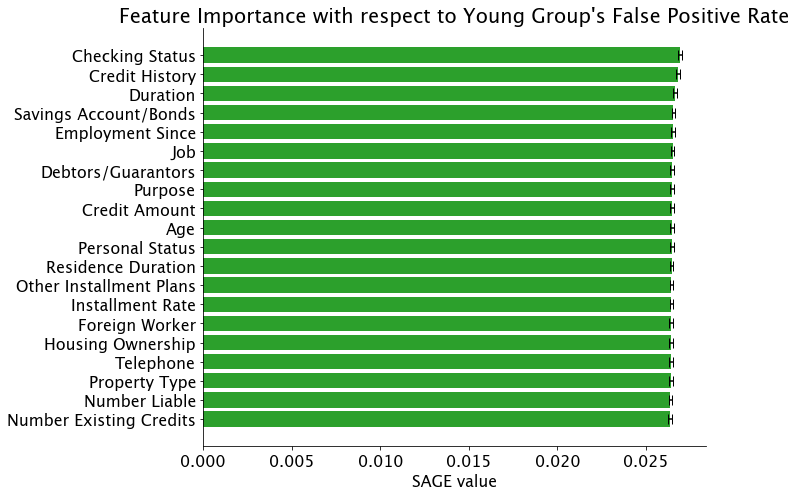

In [12]:
sage_values_young_fpr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Positive Rate')

# Old group FPR

In [13]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [14]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fpr = sage.PermutationEstimator(imputer_old, 'fpr')
%time sage_values_old_fpr = estimator_old_fpr(test_old, Y_test_old, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_old_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

tn = 0, fp = 113, fn = 0, tp = 399
===> Iteration 0, Prev loss = 1.0 [outer loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 2, fp = 111, fn = 0, tp = 399
	Loss = 0.9823008849557522 [inner loop]
tn = 3, fp = 110, fn = 1, tp = 398
	Loss = 0.9734513274336283 [inner loop]
tn = 7, fp = 106, fn = 1, tp = 398
	Loss = 0.9380530973451328 [inner loop]
tn = 5, fp = 108, fn = 1, tp = 398
	Loss = 0.9557522123893806 [inner loop]
tn = 5, fp = 108, fn = 2, tp = 397
	Loss = 0.9557522123893806 [inner loop]
tn = 9, fp = 104, fn = 2, tp = 397
	Loss = 0.9203539823008849 [inner loop]
tn = 14, fp = 99, fn = 3, tp = 396
	Loss = 0.8761061946902655 [inner loop]
tn = 15, fp = 98, fn = 4, tp = 395
	Loss = 0.8672566371681416 [inner loop]
tn = 21, fp = 92, fn = 7, tp = 392
	Loss = 0.8141592920353983 [inner loop]
tn = 25, fp = 88, fn = 7, tp = 392
	Loss = 0.7787610619469026 [inner loop]
tn = 30, fp = 83, fn = 10, tp = 389
	Loss = 0.73

tn = 3, fp = 124, fn = 1, tp = 384
	Loss = 0.9763779527559056 [inner loop]
tn = 3, fp = 124, fn = 2, tp = 383
	Loss = 0.9763779527559056 [inner loop]
tn = 4, fp = 123, fn = 3, tp = 382
	Loss = 0.968503937007874 [inner loop]
tn = 6, fp = 121, fn = 4, tp = 381
	Loss = 0.952755905511811 [inner loop]
tn = 8, fp = 119, fn = 4, tp = 381
	Loss = 0.937007874015748 [inner loop]
tn = 10, fp = 117, fn = 5, tp = 380
	Loss = 0.9212598425196851 [inner loop]
tn = 13, fp = 114, fn = 4, tp = 381
	Loss = 0.8976377952755905 [inner loop]
tn = 16, fp = 111, fn = 5, tp = 380
	Loss = 0.8740157480314961 [inner loop]
tn = 21, fp = 106, fn = 9, tp = 376
	Loss = 0.8346456692913385 [inner loop]
tn = 23, fp = 104, fn = 10, tp = 375
	Loss = 0.8188976377952756 [inner loop]
tn = 23, fp = 104, fn = 11, tp = 374
	Loss = 0.8188976377952756 [inner loop]
tn = 27, fp = 100, fn = 13, tp = 372
	Loss = 0.7874015748031497 [inner loop]
tn = 30, fp = 97, fn = 14, tp = 371
	Loss = 0.7637795275590551 [inner loop]
tn = 35, fp = 92,

tn = 8, fp = 107, fn = 2, tp = 395
	Loss = 0.9304347826086956 [inner loop]
tn = 9, fp = 106, fn = 4, tp = 393
	Loss = 0.9217391304347826 [inner loop]
tn = 9, fp = 106, fn = 3, tp = 394
	Loss = 0.9217391304347826 [inner loop]
tn = 13, fp = 102, fn = 3, tp = 394
	Loss = 0.8869565217391304 [inner loop]
tn = 15, fp = 100, fn = 3, tp = 394
	Loss = 0.8695652173913043 [inner loop]
tn = 18, fp = 97, fn = 6, tp = 391
	Loss = 0.8434782608695652 [inner loop]
tn = 20, fp = 95, fn = 10, tp = 387
	Loss = 0.8260869565217391 [inner loop]
tn = 21, fp = 94, fn = 9, tp = 388
	Loss = 0.8173913043478261 [inner loop]
tn = 30, fp = 85, fn = 13, tp = 384
	Loss = 0.7391304347826086 [inner loop]
tn = 30, fp = 85, fn = 15, tp = 382
	Loss = 0.7391304347826086 [inner loop]
tn = 37, fp = 78, fn = 16, tp = 381
	Loss = 0.6782608695652174 [inner loop]
tn = 41, fp = 74, fn = 17, tp = 380
	Loss = 0.6434782608695652 [inner loop]
tn = 43, fp = 72, fn = 15, tp = 382
	Loss = 0.6260869565217392 [inner loop]
tn = 42, fp = 73,

tn = 13, fp = 109, fn = 4, tp = 386
	Loss = 0.8934426229508197 [inner loop]
tn = 14, fp = 108, fn = 5, tp = 385
	Loss = 0.8852459016393442 [inner loop]
tn = 16, fp = 106, fn = 6, tp = 384
	Loss = 0.8688524590163934 [inner loop]
tn = 22, fp = 100, fn = 10, tp = 380
	Loss = 0.819672131147541 [inner loop]
tn = 21, fp = 101, fn = 11, tp = 379
	Loss = 0.8278688524590164 [inner loop]
tn = 29, fp = 93, fn = 9, tp = 381
	Loss = 0.7622950819672131 [inner loop]
tn = 29, fp = 93, fn = 8, tp = 382
	Loss = 0.7622950819672131 [inner loop]
tn = 39, fp = 83, fn = 10, tp = 380
	Loss = 0.680327868852459 [inner loop]
tn = 37, fp = 85, fn = 11, tp = 379
	Loss = 0.6967213114754098 [inner loop]
tn = 43, fp = 79, fn = 15, tp = 375
	Loss = 0.6475409836065574 [inner loop]
tn = 43, fp = 79, fn = 18, tp = 372
	Loss = 0.6475409836065574 [inner loop]
tn = 43, fp = 79, fn = 19, tp = 371
	Loss = 0.6475409836065574 [inner loop]
tn = 46, fp = 76, fn = 18, tp = 372
	Loss = 0.6229508196721312 [inner loop]
StdDev Ratio =

tn = 14, fp = 96, fn = 9, tp = 393
	Loss = 0.8727272727272727 [inner loop]
tn = 17, fp = 93, fn = 12, tp = 390
	Loss = 0.8454545454545455 [inner loop]
tn = 19, fp = 91, fn = 14, tp = 388
	Loss = 0.8272727272727273 [inner loop]
tn = 21, fp = 89, fn = 15, tp = 387
	Loss = 0.8090909090909091 [inner loop]
tn = 22, fp = 88, fn = 18, tp = 384
	Loss = 0.8 [inner loop]
tn = 28, fp = 82, fn = 19, tp = 383
	Loss = 0.7454545454545455 [inner loop]
tn = 33, fp = 77, fn = 21, tp = 381
	Loss = 0.7 [inner loop]
tn = 36, fp = 74, fn = 22, tp = 380
	Loss = 0.6727272727272727 [inner loop]
tn = 41, fp = 69, fn = 23, tp = 379
	Loss = 0.6272727272727273 [inner loop]
tn = 45, fp = 65, fn = 26, tp = 376
	Loss = 0.5909090909090909 [inner loop]
StdDev Ratio = 0.2779 (Converge at 0.1000)
tn = 0, fp = 116, fn = 0, tp = 396
===> Iteration 21, Prev loss = 1.0 [outer loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 0, fp = 116, fn = 0,

tn = 38, fp = 87, fn = 17, tp = 370
	Loss = 0.696 [inner loop]
tn = 42, fp = 83, fn = 22, tp = 365
	Loss = 0.664 [inner loop]
tn = 39, fp = 86, fn = 23, tp = 364
	Loss = 0.688 [inner loop]
tn = 45, fp = 80, fn = 23, tp = 364
	Loss = 0.64 [inner loop]
StdDev Ratio = 0.2690 (Converge at 0.1000)
tn = 0, fp = 115, fn = 0, tp = 397
===> Iteration 26, Prev loss = 1.0 [outer loop]
tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 1, fp = 114, fn = 0, tp = 397
	Loss = 0.991304347826087 [inner loop]
tn = 1, fp = 114, fn = 1, tp = 396
	Loss = 0.991304347826087 [inner loop]
tn = 2, fp = 113, fn = 1, tp = 396
	Loss = 0.9826086956521739 [inner loop]
tn = 3, fp = 112, fn = 1, tp = 396
	Loss = 0.9739130434782609 [inner loop]
tn = 5, fp = 110, fn = 2, tp = 395
	Loss = 0.9565217391304348 [inner loop]
tn = 7, fp = 108, fn = 4, tp = 393
	Loss = 0.9391304347826087 [inner loop]
tn = 10, fp = 105, fn = 7, tp = 390
	Loss = 0.9130434782608695 [inner loop]
tn = 12, fp = 103, fn = 8, tp = 389
	Lo

tn = 0, fp = 98, fn = 0, tp = 414
===> Iteration 31, Prev loss = 1.0 [outer loop]
tn = 0, fp = 98, fn = 0, tp = 414
	Loss = 1.0 [inner loop]
tn = 2, fp = 96, fn = 0, tp = 414
	Loss = 0.9795918367346939 [inner loop]
tn = 4, fp = 94, fn = 0, tp = 414
	Loss = 0.9591836734693877 [inner loop]
tn = 8, fp = 90, fn = 1, tp = 413
	Loss = 0.9183673469387755 [inner loop]
tn = 9, fp = 89, fn = 2, tp = 412
	Loss = 0.9081632653061225 [inner loop]
tn = 9, fp = 89, fn = 1, tp = 413
	Loss = 0.9081632653061225 [inner loop]
tn = 8, fp = 90, fn = 0, tp = 414
	Loss = 0.9183673469387755 [inner loop]
tn = 8, fp = 90, fn = 2, tp = 412
	Loss = 0.9183673469387755 [inner loop]
tn = 9, fp = 89, fn = 3, tp = 411
	Loss = 0.9081632653061225 [inner loop]
tn = 12, fp = 86, fn = 7, tp = 407
	Loss = 0.8775510204081632 [inner loop]
tn = 13, fp = 85, fn = 10, tp = 404
	Loss = 0.8673469387755102 [inner loop]
tn = 15, fp = 83, fn = 11, tp = 403
	Loss = 0.8469387755102041 [inner loop]
tn = 14, fp = 84, fn = 12, tp = 402
	Los

tn = 3, fp = 107, fn = 2, tp = 400
	Loss = 0.9727272727272728 [inner loop]
tn = 4, fp = 106, fn = 4, tp = 398
	Loss = 0.9636363636363636 [inner loop]
tn = 8, fp = 102, fn = 5, tp = 397
	Loss = 0.9272727272727272 [inner loop]
tn = 11, fp = 99, fn = 3, tp = 399
	Loss = 0.9 [inner loop]
tn = 13, fp = 97, fn = 3, tp = 399
	Loss = 0.8818181818181818 [inner loop]
tn = 15, fp = 95, fn = 7, tp = 395
	Loss = 0.8636363636363636 [inner loop]
tn = 17, fp = 93, fn = 6, tp = 396
	Loss = 0.8454545454545455 [inner loop]
tn = 20, fp = 90, fn = 7, tp = 395
	Loss = 0.8181818181818182 [inner loop]
tn = 25, fp = 85, fn = 10, tp = 392
	Loss = 0.7727272727272727 [inner loop]
tn = 29, fp = 81, fn = 10, tp = 392
	Loss = 0.7363636363636363 [inner loop]
tn = 32, fp = 78, fn = 9, tp = 393
	Loss = 0.7090909090909091 [inner loop]
tn = 35, fp = 75, fn = 12, tp = 390
	Loss = 0.6818181818181818 [inner loop]
tn = 35, fp = 75, fn = 9, tp = 393
	Loss = 0.6818181818181818 [inner loop]
tn = 41, fp = 69, fn = 13, tp = 389
	

tn = 14, fp = 99, fn = 4, tp = 395
	Loss = 0.8761061946902655 [inner loop]
tn = 16, fp = 97, fn = 5, tp = 394
	Loss = 0.8584070796460177 [inner loop]
tn = 22, fp = 91, fn = 6, tp = 393
	Loss = 0.8053097345132744 [inner loop]
tn = 24, fp = 89, fn = 7, tp = 392
	Loss = 0.7876106194690266 [inner loop]
tn = 29, fp = 84, fn = 11, tp = 388
	Loss = 0.7433628318584071 [inner loop]
tn = 28, fp = 85, fn = 16, tp = 383
	Loss = 0.7522123893805309 [inner loop]
tn = 34, fp = 79, fn = 18, tp = 381
	Loss = 0.6991150442477876 [inner loop]
tn = 37, fp = 76, fn = 19, tp = 380
	Loss = 0.672566371681416 [inner loop]
tn = 41, fp = 72, fn = 19, tp = 380
	Loss = 0.6371681415929203 [inner loop]
tn = 45, fp = 68, fn = 21, tp = 378
	Loss = 0.6017699115044248 [inner loop]
tn = 46, fp = 67, fn = 19, tp = 380
	Loss = 0.5929203539823009 [inner loop]
tn = 45, fp = 68, fn = 20, tp = 379
	Loss = 0.6017699115044248 [inner loop]
tn = 51, fp = 62, fn = 20, tp = 379
	Loss = 0.5486725663716814 [inner loop]
StdDev Ratio = 0.

tn = 20, fp = 81, fn = 10, tp = 401
	Loss = 0.801980198019802 [inner loop]
tn = 23, fp = 78, fn = 14, tp = 397
	Loss = 0.7722772277227723 [inner loop]
tn = 24, fp = 77, fn = 17, tp = 394
	Loss = 0.7623762376237624 [inner loop]
tn = 22, fp = 79, fn = 18, tp = 393
	Loss = 0.7821782178217822 [inner loop]
tn = 27, fp = 74, fn = 15, tp = 396
	Loss = 0.7326732673267327 [inner loop]
tn = 29, fp = 72, fn = 17, tp = 394
	Loss = 0.7128712871287128 [inner loop]
tn = 28, fp = 73, fn = 20, tp = 391
	Loss = 0.7227722772277227 [inner loop]
tn = 34, fp = 67, fn = 22, tp = 389
	Loss = 0.6633663366336634 [inner loop]
StdDev Ratio = 0.2065 (Converge at 0.1000)
tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 47, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 1, fp = 105, fn = 1, tp = 405
	Loss = 0.9905660377358491 [inner loop]
tn = 3, fp =

tn = 31, fp = 75, fn = 26, tp = 380
	Loss = 0.7075471698113207 [inner loop]
tn = 34, fp = 72, fn = 28, tp = 378
	Loss = 0.6792452830188679 [inner loop]
tn = 34, fp = 72, fn = 27, tp = 379
	Loss = 0.6792452830188679 [inner loop]
tn = 36, fp = 70, fn = 25, tp = 381
	Loss = 0.660377358490566 [inner loop]
StdDev Ratio = 0.1917 (Converge at 0.1000)
tn = 0, fp = 119, fn = 0, tp = 393
===> Iteration 52, Prev loss = 1.0 [outer loop]
tn = 0, fp = 119, fn = 0, tp = 393
	Loss = 1.0 [inner loop]
tn = 1, fp = 118, fn = 0, tp = 393
	Loss = 0.9915966386554622 [inner loop]
tn = 1, fp = 118, fn = 0, tp = 393
	Loss = 0.9915966386554622 [inner loop]
tn = 3, fp = 116, fn = 0, tp = 393
	Loss = 0.9747899159663865 [inner loop]
tn = 4, fp = 115, fn = 2, tp = 391
	Loss = 0.9663865546218487 [inner loop]
tn = 6, fp = 113, fn = 3, tp = 390
	Loss = 0.9495798319327731 [inner loop]
tn = 10, fp = 109, fn = 4, tp = 389
	Loss = 0.9159663865546218 [inner loop]
tn = 15, fp = 104, fn = 5, tp = 388
	Loss = 0.87394957983193

tn = 28, fp = 71, fn = 19, tp = 394
	Loss = 0.7171717171717171 [inner loop]
StdDev Ratio = 0.1948 (Converge at 0.1000)
tn = 0, fp = 127, fn = 0, tp = 385
===> Iteration 57, Prev loss = 1.0 [outer loop]
tn = 0, fp = 127, fn = 0, tp = 385
	Loss = 1.0 [inner loop]
tn = 1, fp = 126, fn = 0, tp = 385
	Loss = 0.9921259842519685 [inner loop]
tn = 1, fp = 126, fn = 0, tp = 385
	Loss = 0.9921259842519685 [inner loop]
tn = 5, fp = 122, fn = 0, tp = 385
	Loss = 0.9606299212598425 [inner loop]
tn = 4, fp = 123, fn = 1, tp = 384
	Loss = 0.968503937007874 [inner loop]
tn = 6, fp = 121, fn = 2, tp = 383
	Loss = 0.952755905511811 [inner loop]
tn = 8, fp = 119, fn = 3, tp = 382
	Loss = 0.937007874015748 [inner loop]
tn = 9, fp = 118, fn = 3, tp = 382
	Loss = 0.9291338582677166 [inner loop]
tn = 14, fp = 113, fn = 5, tp = 380
	Loss = 0.889763779527559 [inner loop]
tn = 17, fp = 110, fn = 5, tp = 380
	Loss = 0.8661417322834646 [inner loop]
tn = 19, fp = 108, fn = 8, tp = 377
	Loss = 0.8503937007874016 [i

tn = 0, fp = 105, fn = 0, tp = 407
	Loss = 1.0 [inner loop]
tn = 0, fp = 105, fn = 0, tp = 407
	Loss = 1.0 [inner loop]
tn = 0, fp = 105, fn = 0, tp = 407
	Loss = 1.0 [inner loop]
tn = 1, fp = 104, fn = 1, tp = 406
	Loss = 0.9904761904761905 [inner loop]
tn = 2, fp = 103, fn = 2, tp = 405
	Loss = 0.9809523809523809 [inner loop]
tn = 4, fp = 101, fn = 5, tp = 402
	Loss = 0.9619047619047619 [inner loop]
tn = 7, fp = 98, fn = 5, tp = 402
	Loss = 0.9333333333333333 [inner loop]
tn = 8, fp = 97, fn = 7, tp = 400
	Loss = 0.9238095238095239 [inner loop]
tn = 8, fp = 97, fn = 8, tp = 399
	Loss = 0.9238095238095239 [inner loop]
tn = 9, fp = 96, fn = 9, tp = 398
	Loss = 0.9142857142857143 [inner loop]
tn = 9, fp = 96, fn = 11, tp = 396
	Loss = 0.9142857142857143 [inner loop]
tn = 13, fp = 92, fn = 16, tp = 391
	Loss = 0.8761904761904762 [inner loop]
tn = 16, fp = 89, fn = 15, tp = 392
	Loss = 0.8476190476190476 [inner loop]
tn = 20, fp = 85, fn = 15, tp = 392
	Loss = 0.8095238095238095 [inner lo

tn = 8, fp = 111, fn = 4, tp = 389
	Loss = 0.9327731092436975 [inner loop]
tn = 12, fp = 107, fn = 5, tp = 388
	Loss = 0.8991596638655462 [inner loop]
tn = 13, fp = 106, fn = 8, tp = 385
	Loss = 0.8907563025210085 [inner loop]
tn = 14, fp = 105, fn = 12, tp = 381
	Loss = 0.8823529411764706 [inner loop]
tn = 15, fp = 104, fn = 11, tp = 382
	Loss = 0.8739495798319328 [inner loop]
tn = 19, fp = 100, fn = 14, tp = 379
	Loss = 0.8403361344537815 [inner loop]
tn = 22, fp = 97, fn = 16, tp = 377
	Loss = 0.8151260504201681 [inner loop]
tn = 28, fp = 91, fn = 19, tp = 374
	Loss = 0.7647058823529411 [inner loop]
tn = 31, fp = 88, fn = 25, tp = 368
	Loss = 0.7394957983193278 [inner loop]
tn = 32, fp = 87, fn = 28, tp = 365
	Loss = 0.7310924369747899 [inner loop]
tn = 32, fp = 87, fn = 31, tp = 362
	Loss = 0.7310924369747899 [inner loop]
tn = 30, fp = 89, fn = 28, tp = 365
	Loss = 0.7478991596638656 [inner loop]
tn = 27, fp = 92, fn = 28, tp = 365
	Loss = 0.773109243697479 [inner loop]
StdDev Rati

tn = 23, fp = 102, fn = 10, tp = 377
	Loss = 0.816 [inner loop]
tn = 27, fp = 98, fn = 13, tp = 374
	Loss = 0.784 [inner loop]
tn = 28, fp = 97, fn = 12, tp = 375
	Loss = 0.776 [inner loop]
tn = 33, fp = 92, fn = 17, tp = 370
	Loss = 0.736 [inner loop]
tn = 33, fp = 92, fn = 18, tp = 369
	Loss = 0.736 [inner loop]
tn = 35, fp = 90, fn = 22, tp = 365
	Loss = 0.72 [inner loop]
tn = 38, fp = 87, fn = 24, tp = 363
	Loss = 0.696 [inner loop]
tn = 41, fp = 84, fn = 23, tp = 364
	Loss = 0.672 [inner loop]
StdDev Ratio = 0.1897 (Converge at 0.1000)
tn = 0, fp = 112, fn = 0, tp = 400
===> Iteration 73, Prev loss = 1.0 [outer loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 2, fp = 110, fn = 0, tp = 400
	Loss = 0.9821428571428571 [inner loop]
tn = 3, fp = 109, fn = 1, tp = 399
	Loss = 0.9732142857142857 [inner loop]
tn = 4, fp = 108, fn = 1, tp = 399
	Loss

tn = 28, fp = 79, fn = 17, tp = 388
	Loss = 0.7383177570093458 [inner loop]
tn = 30, fp = 77, fn = 22, tp = 383
	Loss = 0.719626168224299 [inner loop]
tn = 29, fp = 78, fn = 27, tp = 378
	Loss = 0.7289719626168224 [inner loop]
tn = 34, fp = 73, fn = 29, tp = 376
	Loss = 0.6822429906542056 [inner loop]
StdDev Ratio = 0.1787 (Converge at 0.1000)
tn = 0, fp = 123, fn = 0, tp = 389
===> Iteration 78, Prev loss = 1.0 [outer loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 1, fp = 122, fn = 0, tp = 389
	Loss = 0.991869918699187 [inner loop]
tn = 1, fp = 122, fn = 1, tp = 388
	Loss = 0.991869918699187 [inner loop]
tn = 3, fp = 120, fn = 2, tp = 387
	Loss = 0.975609756097561 [inner loop]
tn = 5, fp = 118, fn = 1, tp = 388
	Loss = 0.959349593495935 [inner loop]
tn = 6, fp = 117, fn = 1, tp = 388
	Loss = 0.9512195121951219 [inner loop]
tn = 9, fp = 114, fn = 2, tp = 387
	Loss = 0.926829268292683 [inner loop]
tn = 1

tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 2, fp = 113, fn = 1, tp = 396
	Loss = 0.9826086956521739 [inner loop]
tn = 6, fp = 109, fn = 1, tp = 396
	Loss = 0.9478260869565217 [inner loop]
tn = 9, fp = 106, fn = 2, tp = 395
	Loss = 0.9217391304347826 [inner loop]
tn = 10, fp = 105, fn = 1, tp = 396
	Loss = 0.9130434782608695 [inner loop]
tn = 12, fp = 103, fn = 1, tp = 396
	Loss = 0.8956521739130435 [inner loop]
tn = 15, fp = 100, fn = 2, tp = 395
	Loss = 0.8695652173913043 [inner loop]
tn = 16, fp = 99, fn = 3, tp = 394
	Loss = 0.8608695652173913 [inner loop]
tn = 19, fp = 96, fn = 6, tp = 391
	Loss = 0.8347826086956521 [inner loop]
tn = 21, fp = 94, fn = 7, tp = 390
	Loss = 0.8173913043478261 [inner loop]
tn = 24, fp = 91, fn = 7, tp = 390
	Loss = 0.7913043478260869 [inner loop]
tn = 24, fp = 91, fn = 8, tp = 389
	Loss = 0.7913043478260869 [inne

tn = 4, fp = 98, fn = 1, tp = 409
	Loss = 0.9607843137254902 [inner loop]
tn = 4, fp = 98, fn = 4, tp = 406
	Loss = 0.9607843137254902 [inner loop]
tn = 9, fp = 93, fn = 6, tp = 404
	Loss = 0.9117647058823529 [inner loop]
tn = 10, fp = 92, fn = 11, tp = 399
	Loss = 0.9019607843137255 [inner loop]
tn = 12, fp = 90, fn = 10, tp = 400
	Loss = 0.8823529411764706 [inner loop]
tn = 15, fp = 87, fn = 13, tp = 397
	Loss = 0.8529411764705882 [inner loop]
tn = 17, fp = 85, fn = 13, tp = 397
	Loss = 0.8333333333333334 [inner loop]
tn = 20, fp = 82, fn = 16, tp = 394
	Loss = 0.803921568627451 [inner loop]
tn = 32, fp = 70, fn = 20, tp = 390
	Loss = 0.6862745098039216 [inner loop]
tn = 33, fp = 69, fn = 22, tp = 388
	Loss = 0.6764705882352942 [inner loop]
tn = 40, fp = 62, fn = 26, tp = 384
	Loss = 0.6078431372549019 [inner loop]
tn = 44, fp = 58, fn = 28, tp = 382
	Loss = 0.5686274509803921 [inner loop]
tn = 44, fp = 58, fn = 30, tp = 380
	Loss = 0.5686274509803921 [inner loop]
tn = 43, fp = 59, f

tn = 11, fp = 94, fn = 6, tp = 401
	Loss = 0.8952380952380953 [inner loop]
tn = 13, fp = 92, fn = 6, tp = 401
	Loss = 0.8761904761904762 [inner loop]
tn = 15, fp = 90, fn = 7, tp = 400
	Loss = 0.8571428571428571 [inner loop]
tn = 19, fp = 86, fn = 7, tp = 400
	Loss = 0.819047619047619 [inner loop]
tn = 21, fp = 84, fn = 8, tp = 399
	Loss = 0.8 [inner loop]
tn = 28, fp = 77, fn = 12, tp = 395
	Loss = 0.7333333333333333 [inner loop]
tn = 26, fp = 79, fn = 16, tp = 391
	Loss = 0.7523809523809524 [inner loop]
tn = 31, fp = 74, fn = 17, tp = 390
	Loss = 0.7047619047619048 [inner loop]
tn = 34, fp = 71, fn = 20, tp = 387
	Loss = 0.6761904761904762 [inner loop]
tn = 39, fp = 66, fn = 25, tp = 382
	Loss = 0.6285714285714286 [inner loop]
tn = 40, fp = 65, fn = 28, tp = 379
	Loss = 0.6190476190476191 [inner loop]
tn = 44, fp = 61, fn = 23, tp = 384
	Loss = 0.580952380952381 [inner loop]
StdDev Ratio = 0.1661 (Converge at 0.1000)
tn = 0, fp = 114, fn = 0, tp = 398
===> Iteration 94, Prev loss = 1

tn = 19, fp = 93, fn = 10, tp = 390
	Loss = 0.8303571428571429 [inner loop]
tn = 24, fp = 88, fn = 10, tp = 390
	Loss = 0.7857142857142857 [inner loop]
tn = 24, fp = 88, fn = 9, tp = 391
	Loss = 0.7857142857142857 [inner loop]
tn = 28, fp = 84, fn = 12, tp = 388
	Loss = 0.75 [inner loop]
tn = 27, fp = 85, fn = 13, tp = 387
	Loss = 0.7589285714285714 [inner loop]
tn = 29, fp = 83, fn = 12, tp = 388
	Loss = 0.7410714285714286 [inner loop]
tn = 34, fp = 78, fn = 18, tp = 382
	Loss = 0.6964285714285714 [inner loop]
tn = 34, fp = 78, fn = 19, tp = 381
	Loss = 0.6964285714285714 [inner loop]
tn = 34, fp = 78, fn = 17, tp = 383
	Loss = 0.6964285714285714 [inner loop]
StdDev Ratio = 0.1681 (Converge at 0.1000)
tn = 0, fp = 121, fn = 0, tp = 391
===> Iteration 99, Prev loss = 1.0 [outer loop]
tn = 0, fp = 121, fn = 0, tp = 391
	Loss = 1.0 [inner loop]
tn = 0, fp = 121, fn = 0, tp = 391
	Loss = 1.0 [inner loop]
tn = 1, fp = 120, fn = 0, tp = 391
	Loss = 0.9917355371900827 [inner loop]
tn = 1, fp

tn = 36, fp = 77, fn = 22, tp = 377
	Loss = 0.6814159292035398 [inner loop]
tn = 42, fp = 71, fn = 20, tp = 379
	Loss = 0.6283185840707964 [inner loop]
tn = 45, fp = 68, fn = 25, tp = 374
	Loss = 0.6017699115044248 [inner loop]
tn = 50, fp = 63, fn = 26, tp = 373
	Loss = 0.5575221238938053 [inner loop]
tn = 47, fp = 66, fn = 28, tp = 371
	Loss = 0.584070796460177 [inner loop]
tn = 53, fp = 60, fn = 29, tp = 370
	Loss = 0.5309734513274337 [inner loop]
StdDev Ratio = 0.1758 (Converge at 0.1000)
tn = 0, fp = 118, fn = 0, tp = 394
===> Iteration 104, Prev loss = 1.0 [outer loop]
tn = 0, fp = 118, fn = 0, tp = 394
	Loss = 1.0 [inner loop]
tn = 1, fp = 117, fn = 0, tp = 394
	Loss = 0.9915254237288136 [inner loop]
tn = 1, fp = 117, fn = 0, tp = 394
	Loss = 0.9915254237288136 [inner loop]
tn = 5, fp = 113, fn = 0, tp = 394
	Loss = 0.9576271186440678 [inner loop]
tn = 6, fp = 112, fn = 0, tp = 394
	Loss = 0.9491525423728814 [inner loop]
tn = 7, fp = 111, fn = 2, tp = 392
	Loss = 0.9406779661016

tn = 36, fp = 79, fn = 20, tp = 377
	Loss = 0.6869565217391305 [inner loop]
tn = 37, fp = 78, fn = 22, tp = 375
	Loss = 0.6782608695652174 [inner loop]
tn = 41, fp = 74, fn = 27, tp = 370
	Loss = 0.6434782608695652 [inner loop]
tn = 41, fp = 74, fn = 24, tp = 373
	Loss = 0.6434782608695652 [inner loop]
StdDev Ratio = 0.1722 (Converge at 0.1000)
tn = 0, fp = 107, fn = 0, tp = 405
===> Iteration 109, Prev loss = 1.0 [outer loop]
tn = 0, fp = 107, fn = 0, tp = 405
	Loss = 1.0 [inner loop]
tn = 0, fp = 107, fn = 0, tp = 405
	Loss = 1.0 [inner loop]
tn = 1, fp = 106, fn = 0, tp = 405
	Loss = 0.9906542056074766 [inner loop]
tn = 1, fp = 106, fn = 0, tp = 405
	Loss = 0.9906542056074766 [inner loop]
tn = 2, fp = 105, fn = 2, tp = 403
	Loss = 0.9813084112149533 [inner loop]
tn = 4, fp = 103, fn = 3, tp = 402
	Loss = 0.9626168224299065 [inner loop]
tn = 6, fp = 101, fn = 5, tp = 400
	Loss = 0.9439252336448598 [inner loop]
tn = 8, fp = 99, fn = 6, tp = 399
	Loss = 0.9252336448598131 [inner loop]


tn = 0, fp = 121, fn = 0, tp = 391
===> Iteration 114, Prev loss = 1.0 [outer loop]
tn = 0, fp = 121, fn = 0, tp = 391
	Loss = 1.0 [inner loop]
tn = 1, fp = 120, fn = 0, tp = 391
	Loss = 0.9917355371900827 [inner loop]
tn = 2, fp = 119, fn = 0, tp = 391
	Loss = 0.9834710743801653 [inner loop]
tn = 3, fp = 118, fn = 0, tp = 391
	Loss = 0.9752066115702479 [inner loop]
tn = 7, fp = 114, fn = 0, tp = 391
	Loss = 0.9421487603305785 [inner loop]
tn = 7, fp = 114, fn = 2, tp = 389
	Loss = 0.9421487603305785 [inner loop]
tn = 9, fp = 112, fn = 3, tp = 388
	Loss = 0.9256198347107438 [inner loop]
tn = 12, fp = 109, fn = 3, tp = 388
	Loss = 0.9008264462809917 [inner loop]
tn = 11, fp = 110, fn = 5, tp = 386
	Loss = 0.9090909090909091 [inner loop]
tn = 17, fp = 104, fn = 5, tp = 386
	Loss = 0.859504132231405 [inner loop]
tn = 19, fp = 102, fn = 5, tp = 386
	Loss = 0.8429752066115702 [inner loop]
tn = 24, fp = 97, fn = 5, tp = 386
	Loss = 0.8016528925619835 [inner loop]
tn = 31, fp = 90, fn = 8, tp

tn = 8, fp = 77, fn = 4, tp = 423
	Loss = 0.9058823529411765 [inner loop]
tn = 8, fp = 77, fn = 7, tp = 420
	Loss = 0.9058823529411765 [inner loop]
tn = 9, fp = 76, fn = 6, tp = 421
	Loss = 0.8941176470588236 [inner loop]
tn = 16, fp = 69, fn = 6, tp = 421
	Loss = 0.8117647058823529 [inner loop]
tn = 17, fp = 68, fn = 9, tp = 418
	Loss = 0.8 [inner loop]
tn = 19, fp = 66, fn = 8, tp = 419
	Loss = 0.7764705882352941 [inner loop]
tn = 19, fp = 66, fn = 8, tp = 419
	Loss = 0.7764705882352941 [inner loop]
tn = 20, fp = 65, fn = 10, tp = 417
	Loss = 0.7647058823529411 [inner loop]
tn = 23, fp = 62, fn = 10, tp = 417
	Loss = 0.7294117647058823 [inner loop]
tn = 24, fp = 61, fn = 12, tp = 415
	Loss = 0.7176470588235294 [inner loop]
tn = 24, fp = 61, fn = 17, tp = 410
	Loss = 0.7176470588235294 [inner loop]
tn = 28, fp = 57, fn = 17, tp = 410
	Loss = 0.6705882352941176 [inner loop]
tn = 28, fp = 57, fn = 16, tp = 411
	Loss = 0.6705882352941176 [inner loop]
tn = 27, fp = 58, fn = 18, tp = 409
	

tn = 19, fp = 98, fn = 6, tp = 389
	Loss = 0.8376068376068376 [inner loop]
tn = 19, fp = 98, fn = 6, tp = 389
	Loss = 0.8376068376068376 [inner loop]
tn = 21, fp = 96, fn = 7, tp = 388
	Loss = 0.8205128205128205 [inner loop]
tn = 24, fp = 93, fn = 11, tp = 384
	Loss = 0.7948717948717948 [inner loop]
tn = 28, fp = 89, fn = 13, tp = 382
	Loss = 0.7606837606837606 [inner loop]
tn = 36, fp = 81, fn = 14, tp = 381
	Loss = 0.6923076923076923 [inner loop]
tn = 36, fp = 81, fn = 15, tp = 380
	Loss = 0.6923076923076923 [inner loop]
tn = 40, fp = 77, fn = 13, tp = 382
	Loss = 0.6581196581196581 [inner loop]
tn = 43, fp = 74, fn = 18, tp = 377
	Loss = 0.6324786324786325 [inner loop]
tn = 40, fp = 77, fn = 18, tp = 377
	Loss = 0.6581196581196581 [inner loop]
tn = 43, fp = 74, fn = 16, tp = 379
	Loss = 0.6324786324786325 [inner loop]
StdDev Ratio = 0.1586 (Converge at 0.1000)
tn = 0, fp = 117, fn = 0, tp = 395
===> Iteration 125, Prev loss = 1.0 [outer loop]
tn = 0, fp = 117, fn = 0, tp = 395
	Loss

tn = 24, fp = 80, fn = 7, tp = 401
	Loss = 0.7692307692307693 [inner loop]
tn = 28, fp = 76, fn = 9, tp = 399
	Loss = 0.7307692307692307 [inner loop]
tn = 31, fp = 73, fn = 10, tp = 398
	Loss = 0.7019230769230769 [inner loop]
tn = 33, fp = 71, fn = 9, tp = 399
	Loss = 0.6826923076923077 [inner loop]
tn = 32, fp = 72, fn = 10, tp = 398
	Loss = 0.6923076923076923 [inner loop]
tn = 35, fp = 69, fn = 11, tp = 397
	Loss = 0.6634615384615384 [inner loop]
tn = 41, fp = 63, fn = 12, tp = 396
	Loss = 0.6057692307692307 [inner loop]
tn = 38, fp = 66, fn = 16, tp = 392
	Loss = 0.6346153846153846 [inner loop]
tn = 40, fp = 64, fn = 23, tp = 385
	Loss = 0.6153846153846154 [inner loop]
StdDev Ratio = 0.1560 (Converge at 0.1000)
tn = 0, fp = 118, fn = 0, tp = 394
===> Iteration 130, Prev loss = 1.0 [outer loop]
tn = 0, fp = 118, fn = 0, tp = 394
	Loss = 1.0 [inner loop]
tn = 1, fp = 117, fn = 0, tp = 394
	Loss = 0.9915254237288136 [inner loop]
tn = 2, fp = 116, fn = 0, tp = 394
	Loss = 0.983050847457

tn = 22, fp = 79, fn = 22, tp = 389
	Loss = 0.7821782178217822 [inner loop]
tn = 24, fp = 77, fn = 24, tp = 387
	Loss = 0.7623762376237624 [inner loop]
tn = 30, fp = 71, fn = 26, tp = 385
	Loss = 0.7029702970297029 [inner loop]
tn = 32, fp = 69, fn = 28, tp = 383
	Loss = 0.6831683168316832 [inner loop]
tn = 33, fp = 68, fn = 28, tp = 383
	Loss = 0.6732673267326733 [inner loop]
tn = 35, fp = 66, fn = 31, tp = 380
	Loss = 0.6534653465346535 [inner loop]
StdDev Ratio = 0.1498 (Converge at 0.1000)
tn = 0, fp = 108, fn = 0, tp = 404
===> Iteration 135, Prev loss = 1.0 [outer loop]
tn = 0, fp = 108, fn = 0, tp = 404
	Loss = 1.0 [inner loop]
tn = 0, fp = 108, fn = 0, tp = 404
	Loss = 1.0 [inner loop]
tn = 1, fp = 107, fn = 1, tp = 403
	Loss = 0.9907407407407407 [inner loop]
tn = 1, fp = 107, fn = 1, tp = 403
	Loss = 0.9907407407407407 [inner loop]
tn = 3, fp = 105, fn = 1, tp = 403
	Loss = 0.9722222222222222 [inner loop]
tn = 7, fp = 101, fn = 1, tp = 403
	Loss = 0.9351851851851852 [inner loo

tn = 42, fp = 78, fn = 17, tp = 375
	Loss = 0.65 [inner loop]
tn = 41, fp = 79, fn = 17, tp = 375
	Loss = 0.6583333333333333 [inner loop]
StdDev Ratio = 0.1517 (Converge at 0.1000)
tn = 0, fp = 116, fn = 0, tp = 396
===> Iteration 140, Prev loss = 1.0 [outer loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 1, fp = 115, fn = 0, tp = 396
	Loss = 0.9913793103448276 [inner loop]
tn = 4, fp = 112, fn = 0, tp = 396
	Loss = 0.9655172413793104 [inner loop]
tn = 5, fp = 111, fn = 2, tp = 394
	Loss = 0.9568965517241379 [inner loop]
tn = 9, fp = 107, fn = 2, tp = 394
	Loss = 0.9224137931034483 [inner loop]
tn = 11, fp = 105, fn = 3, tp = 393
	Loss = 0.9051724137931034 [inner loop]
tn = 15, fp = 101, fn = 5, tp = 391
	Loss = 0.8706896551724138 [inner loop]
tn = 17, fp = 99, fn = 7, tp = 389
	Loss = 0.853448275862069 [inner loop]
tn = 18, fp = 98, fn = 13, tp = 383
	Loss = 0.8448275862068966 [inner loop]
tn = 25, fp =

tn = 0, fp = 104, fn = 0, tp = 408
===> Iteration 145, Prev loss = 1.0 [outer loop]
tn = 0, fp = 104, fn = 0, tp = 408
	Loss = 1.0 [inner loop]
tn = 0, fp = 104, fn = 0, tp = 408
	Loss = 1.0 [inner loop]
tn = 1, fp = 103, fn = 0, tp = 408
	Loss = 0.9903846153846154 [inner loop]
tn = 3, fp = 101, fn = 0, tp = 408
	Loss = 0.9711538461538461 [inner loop]
tn = 3, fp = 101, fn = 0, tp = 408
	Loss = 0.9711538461538461 [inner loop]
tn = 4, fp = 100, fn = 1, tp = 407
	Loss = 0.9615384615384616 [inner loop]
tn = 5, fp = 99, fn = 2, tp = 406
	Loss = 0.9519230769230769 [inner loop]
tn = 10, fp = 94, fn = 3, tp = 405
	Loss = 0.9038461538461539 [inner loop]
tn = 15, fp = 89, fn = 6, tp = 402
	Loss = 0.8557692307692307 [inner loop]
tn = 19, fp = 85, fn = 8, tp = 400
	Loss = 0.8173076923076923 [inner loop]
tn = 20, fp = 84, fn = 12, tp = 396
	Loss = 0.8076923076923077 [inner loop]
tn = 22, fp = 82, fn = 15, tp = 393
	Loss = 0.7884615384615384 [inner loop]
tn = 26, fp = 78, fn = 15, tp = 393
	Loss = 0

tn = 4, fp = 101, fn = 1, tp = 406
	Loss = 0.9619047619047619 [inner loop]
tn = 4, fp = 101, fn = 2, tp = 405
	Loss = 0.9619047619047619 [inner loop]
tn = 6, fp = 99, fn = 2, tp = 405
	Loss = 0.9428571428571428 [inner loop]
tn = 7, fp = 98, fn = 5, tp = 402
	Loss = 0.9333333333333333 [inner loop]
tn = 11, fp = 94, fn = 5, tp = 402
	Loss = 0.8952380952380953 [inner loop]
tn = 13, fp = 92, fn = 6, tp = 401
	Loss = 0.8761904761904762 [inner loop]
tn = 15, fp = 90, fn = 6, tp = 401
	Loss = 0.8571428571428571 [inner loop]
tn = 18, fp = 87, fn = 6, tp = 401
	Loss = 0.8285714285714286 [inner loop]
tn = 18, fp = 87, fn = 11, tp = 396
	Loss = 0.8285714285714286 [inner loop]
tn = 23, fp = 82, fn = 13, tp = 394
	Loss = 0.780952380952381 [inner loop]
tn = 26, fp = 79, fn = 18, tp = 389
	Loss = 0.7523809523809524 [inner loop]
tn = 29, fp = 76, fn = 22, tp = 385
	Loss = 0.7238095238095238 [inner loop]
tn = 32, fp = 73, fn = 25, tp = 382
	Loss = 0.6952380952380952 [inner loop]
tn = 32, fp = 73, fn = 

tn = 11, fp = 94, fn = 8, tp = 399
	Loss = 0.8952380952380953 [inner loop]
tn = 12, fp = 93, fn = 9, tp = 398
	Loss = 0.8857142857142857 [inner loop]
tn = 15, fp = 90, fn = 8, tp = 399
	Loss = 0.8571428571428571 [inner loop]
tn = 17, fp = 88, fn = 8, tp = 399
	Loss = 0.8380952380952381 [inner loop]
tn = 17, fp = 88, fn = 7, tp = 400
	Loss = 0.8380952380952381 [inner loop]
tn = 18, fp = 87, fn = 8, tp = 399
	Loss = 0.8285714285714286 [inner loop]
tn = 18, fp = 87, fn = 14, tp = 393
	Loss = 0.8285714285714286 [inner loop]
tn = 21, fp = 84, fn = 17, tp = 390
	Loss = 0.8 [inner loop]
tn = 23, fp = 82, fn = 17, tp = 390
	Loss = 0.780952380952381 [inner loop]
tn = 26, fp = 79, fn = 20, tp = 387
	Loss = 0.7523809523809524 [inner loop]
tn = 31, fp = 74, fn = 21, tp = 386
	Loss = 0.7047619047619048 [inner loop]
tn = 37, fp = 68, fn = 23, tp = 384
	Loss = 0.6476190476190476 [inner loop]
tn = 37, fp = 68, fn = 27, tp = 380
	Loss = 0.6476190476190476 [inner loop]
tn = 42, fp = 63, fn = 26, tp = 38

tn = 24, fp = 97, fn = 13, tp = 378
	Loss = 0.8016528925619835 [inner loop]
tn = 24, fp = 97, fn = 12, tp = 379
	Loss = 0.8016528925619835 [inner loop]
tn = 26, fp = 95, fn = 17, tp = 374
	Loss = 0.7851239669421488 [inner loop]
tn = 26, fp = 95, fn = 18, tp = 373
	Loss = 0.7851239669421488 [inner loop]
tn = 35, fp = 86, fn = 16, tp = 375
	Loss = 0.7107438016528925 [inner loop]
tn = 38, fp = 83, fn = 15, tp = 376
	Loss = 0.6859504132231405 [inner loop]
tn = 44, fp = 77, fn = 14, tp = 377
	Loss = 0.6363636363636364 [inner loop]
tn = 45, fp = 76, fn = 14, tp = 377
	Loss = 0.628099173553719 [inner loop]
tn = 50, fp = 71, fn = 15, tp = 376
	Loss = 0.5867768595041323 [inner loop]
tn = 54, fp = 67, fn = 14, tp = 377
	Loss = 0.5537190082644629 [inner loop]
StdDev Ratio = 0.1493 (Converge at 0.1000)
tn = 0, fp = 121, fn = 0, tp = 391
===> Iteration 161, Prev loss = 1.0 [outer loop]
tn = 0, fp = 121, fn = 0, tp = 391
	Loss = 1.0 [inner loop]
tn = 0, fp = 121, fn = 0, tp = 391
	Loss = 1.0 [inner 

tn = 26, fp = 98, fn = 13, tp = 375
	Loss = 0.7903225806451613 [inner loop]
tn = 28, fp = 96, fn = 16, tp = 372
	Loss = 0.7741935483870968 [inner loop]
tn = 33, fp = 91, fn = 21, tp = 367
	Loss = 0.7338709677419355 [inner loop]
tn = 38, fp = 86, fn = 22, tp = 366
	Loss = 0.6935483870967742 [inner loop]
tn = 39, fp = 85, fn = 20, tp = 368
	Loss = 0.6854838709677419 [inner loop]
tn = 42, fp = 82, fn = 19, tp = 369
	Loss = 0.6612903225806451 [inner loop]
tn = 40, fp = 84, fn = 26, tp = 362
	Loss = 0.6774193548387096 [inner loop]
tn = 43, fp = 81, fn = 23, tp = 365
	Loss = 0.6532258064516129 [inner loop]
StdDev Ratio = 0.1383 (Converge at 0.1000)
tn = 0, fp = 110, fn = 0, tp = 402
===> Iteration 166, Prev loss = 1.0 [outer loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 1, tp = 401
	Loss = 1.0 [inner loop]
tn = 1, fp = 109, fn = 1, tp = 401
	Loss = 0.990909090909091 [inner loop]
tn = 1, fp = 109, fn = 1, tp = 401
	Loss = 0.990909090909091 [inner loo

tn = 34, fp = 73, fn = 20, tp = 385
	Loss = 0.6822429906542056 [inner loop]
tn = 36, fp = 71, fn = 25, tp = 380
	Loss = 0.6635514018691588 [inner loop]
tn = 40, fp = 67, fn = 27, tp = 378
	Loss = 0.6261682242990654 [inner loop]
tn = 44, fp = 63, fn = 29, tp = 376
	Loss = 0.5887850467289719 [inner loop]
tn = 42, fp = 65, fn = 32, tp = 373
	Loss = 0.6074766355140186 [inner loop]
StdDev Ratio = 0.1382 (Converge at 0.1000)
tn = 0, fp = 110, fn = 0, tp = 402
===> Iteration 171, Prev loss = 1.0 [outer loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 1, tp = 401
	Loss = 1.0 [inner loop]
tn = 1, fp = 109, fn = 1, tp = 401
	Loss = 0.990909090909091 [inner loop]
tn = 3, fp = 107, fn = 1, tp = 401
	Loss = 0.9727272727272728 [inner loop]
tn = 5, fp = 105, fn = 2, tp = 400
	Loss = 0.9545454545454546 [inner loop]
tn = 7, fp = 103, fn = 3, tp = 399
	Loss = 0.9363636363636364 [inner loop]
tn = 9, fp = 1

tn = 0, fp = 111, fn = 0, tp = 401
===> Iteration 176, Prev loss = 1.0 [outer loop]
tn = 0, fp = 111, fn = 0, tp = 401
	Loss = 1.0 [inner loop]
tn = 0, fp = 111, fn = 0, tp = 401
	Loss = 1.0 [inner loop]
tn = 1, fp = 110, fn = 1, tp = 400
	Loss = 0.990990990990991 [inner loop]
tn = 1, fp = 110, fn = 1, tp = 400
	Loss = 0.990990990990991 [inner loop]
tn = 3, fp = 108, fn = 1, tp = 400
	Loss = 0.972972972972973 [inner loop]
tn = 4, fp = 107, fn = 1, tp = 400
	Loss = 0.963963963963964 [inner loop]
tn = 6, fp = 105, fn = 1, tp = 400
	Loss = 0.9459459459459459 [inner loop]
tn = 11, fp = 100, fn = 4, tp = 397
	Loss = 0.9009009009009009 [inner loop]
tn = 11, fp = 100, fn = 4, tp = 397
	Loss = 0.9009009009009009 [inner loop]
tn = 15, fp = 96, fn = 5, tp = 396
	Loss = 0.8648648648648649 [inner loop]
tn = 20, fp = 91, fn = 9, tp = 392
	Loss = 0.8198198198198198 [inner loop]
tn = 24, fp = 87, fn = 14, tp = 387
	Loss = 0.7837837837837838 [inner loop]
tn = 21, fp = 90, fn = 14, tp = 387
	Loss = 0.8

tn = 10, fp = 104, fn = 1, tp = 397
	Loss = 0.9122807017543859 [inner loop]
tn = 13, fp = 101, fn = 2, tp = 396
	Loss = 0.8859649122807017 [inner loop]
tn = 12, fp = 102, fn = 3, tp = 395
	Loss = 0.8947368421052632 [inner loop]
tn = 19, fp = 95, fn = 2, tp = 396
	Loss = 0.8333333333333334 [inner loop]
tn = 24, fp = 90, fn = 4, tp = 394
	Loss = 0.7894736842105263 [inner loop]
tn = 24, fp = 90, fn = 5, tp = 393
	Loss = 0.7894736842105263 [inner loop]
tn = 26, fp = 88, fn = 5, tp = 393
	Loss = 0.7719298245614035 [inner loop]
tn = 30, fp = 84, fn = 7, tp = 391
	Loss = 0.7368421052631579 [inner loop]
tn = 32, fp = 82, fn = 9, tp = 389
	Loss = 0.7192982456140351 [inner loop]
tn = 34, fp = 80, fn = 10, tp = 388
	Loss = 0.7017543859649122 [inner loop]
tn = 39, fp = 75, fn = 12, tp = 386
	Loss = 0.6578947368421053 [inner loop]
tn = 42, fp = 72, fn = 15, tp = 383
	Loss = 0.631578947368421 [inner loop]
tn = 42, fp = 72, fn = 16, tp = 382
	Loss = 0.631578947368421 [inner loop]
tn = 46, fp = 68, fn

tn = 21, fp = 89, fn = 9, tp = 393
	Loss = 0.8090909090909091 [inner loop]
tn = 25, fp = 85, fn = 12, tp = 390
	Loss = 0.7727272727272727 [inner loop]
tn = 31, fp = 79, fn = 14, tp = 388
	Loss = 0.7181818181818181 [inner loop]
tn = 32, fp = 78, fn = 16, tp = 386
	Loss = 0.7090909090909091 [inner loop]
tn = 33, fp = 77, fn = 15, tp = 387
	Loss = 0.7 [inner loop]
tn = 37, fp = 73, fn = 18, tp = 384
	Loss = 0.6636363636363637 [inner loop]
tn = 38, fp = 72, fn = 16, tp = 386
	Loss = 0.6545454545454545 [inner loop]
tn = 40, fp = 70, fn = 16, tp = 386
	Loss = 0.6363636363636364 [inner loop]
tn = 47, fp = 63, fn = 18, tp = 384
	Loss = 0.5727272727272728 [inner loop]
tn = 39, fp = 71, fn = 21, tp = 381
	Loss = 0.6454545454545455 [inner loop]
StdDev Ratio = 0.1332 (Converge at 0.1000)
tn = 0, fp = 104, fn = 0, tp = 408
===> Iteration 187, Prev loss = 1.0 [outer loop]
tn = 0, fp = 104, fn = 0, tp = 408
	Loss = 1.0 [inner loop]
tn = 1, fp = 103, fn = 0, tp = 408
	Loss = 0.9903846153846154 [inner 

tn = 28, fp = 82, fn = 14, tp = 388
	Loss = 0.7454545454545455 [inner loop]
tn = 31, fp = 79, fn = 13, tp = 389
	Loss = 0.7181818181818181 [inner loop]
tn = 31, fp = 79, fn = 15, tp = 387
	Loss = 0.7181818181818181 [inner loop]
tn = 31, fp = 79, fn = 17, tp = 385
	Loss = 0.7181818181818181 [inner loop]
tn = 36, fp = 74, fn = 19, tp = 383
	Loss = 0.6727272727272727 [inner loop]
tn = 39, fp = 71, fn = 18, tp = 384
	Loss = 0.6454545454545455 [inner loop]
StdDev Ratio = 0.1293 (Converge at 0.1000)
tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 192, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 1, tp = 405
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 1, tp = 405
	Loss = 1.0 [inner loop]
tn = 3, fp = 103, fn = 2, tp = 404
	Loss = 0.9716981132075472 [inner loop]
tn = 5, fp = 101, fn = 2, tp = 404
	Loss = 0.9528301886792453 [inner loop]
tn = 5, fp = 101, fn = 2, tp = 404
	Loss = 0.9528301886792453 [inner loop]
tn = 7, fp =

tn = 35, fp = 87, fn = 21, tp = 369
	Loss = 0.7131147540983607 [inner loop]
tn = 37, fp = 85, fn = 20, tp = 370
	Loss = 0.6967213114754098 [inner loop]
StdDev Ratio = 0.1247 (Converge at 0.1000)
tn = 0, fp = 129, fn = 0, tp = 383
===> Iteration 197, Prev loss = 1.0 [outer loop]
tn = 0, fp = 129, fn = 0, tp = 383
	Loss = 1.0 [inner loop]
tn = 1, fp = 128, fn = 0, tp = 383
	Loss = 0.9922480620155039 [inner loop]
tn = 1, fp = 128, fn = 0, tp = 383
	Loss = 0.9922480620155039 [inner loop]
tn = 4, fp = 125, fn = 1, tp = 382
	Loss = 0.9689922480620154 [inner loop]
tn = 6, fp = 123, fn = 1, tp = 382
	Loss = 0.9534883720930233 [inner loop]
tn = 7, fp = 122, fn = 2, tp = 381
	Loss = 0.9457364341085271 [inner loop]
tn = 9, fp = 120, fn = 2, tp = 381
	Loss = 0.9302325581395349 [inner loop]
tn = 10, fp = 119, fn = 3, tp = 380
	Loss = 0.9224806201550387 [inner loop]
tn = 14, fp = 115, fn = 5, tp = 378
	Loss = 0.8914728682170543 [inner loop]
tn = 17, fp = 112, fn = 5, tp = 378
	Loss = 0.8682170542635

tn = 0, fp = 122, fn = 0, tp = 390
	Loss = 1.0 [inner loop]
tn = 1, fp = 121, fn = 0, tp = 390
	Loss = 0.9918032786885246 [inner loop]
tn = 2, fp = 120, fn = 0, tp = 390
	Loss = 0.9836065573770492 [inner loop]
tn = 4, fp = 118, fn = 0, tp = 390
	Loss = 0.9672131147540983 [inner loop]
tn = 5, fp = 117, fn = 0, tp = 390
	Loss = 0.9590163934426229 [inner loop]
tn = 9, fp = 113, fn = 1, tp = 389
	Loss = 0.9262295081967213 [inner loop]
tn = 11, fp = 111, fn = 3, tp = 387
	Loss = 0.9098360655737705 [inner loop]
tn = 15, fp = 107, fn = 5, tp = 385
	Loss = 0.8770491803278688 [inner loop]
tn = 18, fp = 104, fn = 8, tp = 382
	Loss = 0.8524590163934426 [inner loop]
tn = 23, fp = 99, fn = 8, tp = 382
	Loss = 0.8114754098360656 [inner loop]
tn = 28, fp = 94, fn = 8, tp = 382
	Loss = 0.7704918032786885 [inner loop]
tn = 29, fp = 93, fn = 9, tp = 381
	Loss = 0.7622950819672131 [inner loop]
tn = 31, fp = 91, fn = 9, tp = 381
	Loss = 0.7459016393442623 [inner loop]
tn = 32, fp = 90, fn = 13, tp = 377
	

tn = 5, fp = 113, fn = 0, tp = 394
	Loss = 0.9576271186440678 [inner loop]
tn = 4, fp = 114, fn = 2, tp = 392
	Loss = 0.9661016949152542 [inner loop]
tn = 7, fp = 111, fn = 2, tp = 392
	Loss = 0.940677966101695 [inner loop]
tn = 9, fp = 109, fn = 6, tp = 388
	Loss = 0.923728813559322 [inner loop]
tn = 13, fp = 105, fn = 8, tp = 386
	Loss = 0.8898305084745762 [inner loop]
tn = 18, fp = 100, fn = 11, tp = 383
	Loss = 0.847457627118644 [inner loop]
tn = 21, fp = 97, fn = 13, tp = 381
	Loss = 0.8220338983050848 [inner loop]
tn = 22, fp = 96, fn = 15, tp = 379
	Loss = 0.8135593220338984 [inner loop]
tn = 26, fp = 92, fn = 17, tp = 377
	Loss = 0.7796610169491526 [inner loop]
tn = 27, fp = 91, fn = 21, tp = 373
	Loss = 0.7711864406779662 [inner loop]
tn = 34, fp = 84, fn = 22, tp = 372
	Loss = 0.711864406779661 [inner loop]
tn = 39, fp = 79, fn = 27, tp = 367
	Loss = 0.6694915254237288 [inner loop]
tn = 43, fp = 75, fn = 27, tp = 367
	Loss = 0.635593220338983 [inner loop]
tn = 43, fp = 75, fn

tn = 12, fp = 90, fn = 4, tp = 406
	Loss = 0.8823529411764706 [inner loop]
tn = 15, fp = 87, fn = 6, tp = 404
	Loss = 0.8529411764705882 [inner loop]
tn = 19, fp = 83, fn = 10, tp = 400
	Loss = 0.8137254901960784 [inner loop]
tn = 20, fp = 82, fn = 11, tp = 399
	Loss = 0.803921568627451 [inner loop]
tn = 22, fp = 80, fn = 13, tp = 397
	Loss = 0.7843137254901961 [inner loop]
tn = 21, fp = 81, fn = 11, tp = 399
	Loss = 0.7941176470588235 [inner loop]
tn = 23, fp = 79, fn = 13, tp = 397
	Loss = 0.7745098039215687 [inner loop]
tn = 29, fp = 73, fn = 12, tp = 398
	Loss = 0.7156862745098039 [inner loop]
tn = 35, fp = 67, fn = 14, tp = 396
	Loss = 0.6568627450980392 [inner loop]
tn = 35, fp = 67, fn = 14, tp = 396
	Loss = 0.6568627450980392 [inner loop]
tn = 34, fp = 68, fn = 18, tp = 392
	Loss = 0.6666666666666666 [inner loop]
tn = 33, fp = 69, fn = 20, tp = 390
	Loss = 0.6764705882352942 [inner loop]
tn = 32, fp = 70, fn = 18, tp = 392
	Loss = 0.6862745098039216 [inner loop]
StdDev Ratio = 

tn = 19, fp = 84, fn = 10, tp = 399
	Loss = 0.8155339805825242 [inner loop]
tn = 18, fp = 85, fn = 9, tp = 400
	Loss = 0.8252427184466019 [inner loop]
tn = 19, fp = 84, fn = 9, tp = 400
	Loss = 0.8155339805825242 [inner loop]
tn = 26, fp = 77, fn = 8, tp = 401
	Loss = 0.7475728155339806 [inner loop]
tn = 31, fp = 72, fn = 13, tp = 396
	Loss = 0.6990291262135923 [inner loop]
tn = 31, fp = 72, fn = 17, tp = 392
	Loss = 0.6990291262135923 [inner loop]
tn = 35, fp = 68, fn = 19, tp = 390
	Loss = 0.6601941747572816 [inner loop]
tn = 37, fp = 66, fn = 23, tp = 386
	Loss = 0.6407766990291263 [inner loop]
tn = 41, fp = 62, fn = 21, tp = 388
	Loss = 0.6019417475728155 [inner loop]
tn = 45, fp = 58, fn = 19, tp = 390
	Loss = 0.5631067961165048 [inner loop]
StdDev Ratio = 0.1218 (Converge at 0.1000)
tn = 0, fp = 116, fn = 0, tp = 396
===> Iteration 218, Prev loss = 1.0 [outer loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 1, fp = 115, fn = 0, tp = 396
	Loss = 0.99137931034

tn = 20, fp = 91, fn = 19, tp = 382
	Loss = 0.8198198198198198 [inner loop]
tn = 22, fp = 89, fn = 22, tp = 379
	Loss = 0.8018018018018018 [inner loop]
tn = 23, fp = 88, fn = 23, tp = 378
	Loss = 0.7927927927927928 [inner loop]
tn = 24, fp = 87, fn = 23, tp = 378
	Loss = 0.7837837837837838 [inner loop]
tn = 34, fp = 77, fn = 24, tp = 377
	Loss = 0.6936936936936937 [inner loop]
tn = 37, fp = 74, fn = 27, tp = 374
	Loss = 0.6666666666666666 [inner loop]
tn = 35, fp = 76, fn = 29, tp = 372
	Loss = 0.6846846846846847 [inner loop]
tn = 36, fp = 75, fn = 27, tp = 374
	Loss = 0.6756756756756757 [inner loop]
StdDev Ratio = 0.1170 (Converge at 0.1000)
tn = 0, fp = 113, fn = 0, tp = 399
===> Iteration 223, Prev loss = 1.0 [outer loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 1, fp = 112, fn = 0, tp = 399
	Loss = 0.9911504424778761 [inner loop]
tn = 2, fp = 111, fn = 0, tp = 399
	Loss = 0.9823008849557522 [inner loop]
tn = 4, fp = 109, fn = 2, tp = 397
	Loss = 0.9646017699

tn = 28, fp = 86, fn = 23, tp = 375
	Loss = 0.7543859649122807 [inner loop]
tn = 33, fp = 81, fn = 23, tp = 375
	Loss = 0.7105263157894737 [inner loop]
tn = 32, fp = 82, fn = 23, tp = 375
	Loss = 0.7192982456140351 [inner loop]
tn = 33, fp = 81, fn = 28, tp = 370
	Loss = 0.7105263157894737 [inner loop]
tn = 37, fp = 77, fn = 25, tp = 373
	Loss = 0.6754385964912281 [inner loop]
StdDev Ratio = 0.1242 (Converge at 0.1000)
tn = 0, fp = 114, fn = 0, tp = 398
===> Iteration 228, Prev loss = 1.0 [outer loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 2, fp = 112, fn = 0, tp = 398
	Loss = 0.9824561403508771 [inner loop]
tn = 2, fp = 112, fn = 1, tp = 397
	Loss = 0.9824561403508771 [inner loop]
tn = 3, fp = 111, fn = 1, tp = 397
	Loss = 0.9736842105263158 [inner loop]
tn = 5, fp = 109, fn = 5, tp = 393
	Loss = 0.956140350877193 [inner loop]
tn = 8, fp = 1

tn = 44, fp = 68, fn = 24, tp = 376
	Loss = 0.6071428571428571 [inner loop]
StdDev Ratio = 0.1256 (Converge at 0.1000)
tn = 0, fp = 113, fn = 0, tp = 399
===> Iteration 233, Prev loss = 1.0 [outer loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 1, fp = 112, fn = 1, tp = 398
	Loss = 0.9911504424778761 [inner loop]
tn = 1, fp = 112, fn = 2, tp = 397
	Loss = 0.9911504424778761 [inner loop]
tn = 3, fp = 110, fn = 2, tp = 397
	Loss = 0.9734513274336283 [inner loop]
tn = 4, fp = 109, fn = 7, tp = 392
	Loss = 0.9646017699115044 [inner loop]
tn = 8, fp = 105, fn = 7, tp = 392
	Loss = 0.9292035398230089 [inner loop]
tn = 8, fp = 105, fn = 6, tp = 393
	Loss = 0.9292035398230089 [inner loop]
tn = 16, fp = 97, fn = 11, tp = 388
	Loss = 0.8584070796460177 [inner loop]
tn = 19, fp = 94, fn = 13, tp = 386
	Loss = 0.831858407079646 [inner loop]
tn = 21, fp = 92, fn = 12, tp = 387
	Loss = 0.8141592920353983 [inner loop]
tn = 22, fp = 91, fn = 12, tp = 387
	Loss = 0.80530973451327

tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 2, fp = 101, fn = 0, tp = 409
	Loss = 0.9805825242718447 [inner loop]
tn = 3, fp = 100, fn = 2, tp = 407
	Loss = 0.970873786407767 [inner loop]
tn = 7, fp = 96, fn = 5, tp = 404
	Loss = 0.9320388349514563 [inner loop]
tn = 8, fp = 95, fn = 6, tp = 403
	Loss = 0.9223300970873787 [inner loop]
tn = 12, fp = 91, fn = 8, tp = 401
	Loss = 0.883495145631068 [inner loop]
tn = 14, fp = 89, fn = 8, tp = 401
	Loss = 0.8640776699029126 [inner loop]
tn = 16, fp = 87, fn = 8, tp = 401
	Loss = 0.8446601941747572 [inner loop]
tn = 16, fp = 87, fn = 11, tp = 398
	Loss = 0.8446601941747572 [inner loop]
tn = 23, fp = 80, fn = 13, tp = 396
	Loss = 0.7766990291262136 [inner loop]
tn = 26, fp = 77, fn = 14, tp = 395
	Loss 

tn = 13, fp = 87, fn = 6, tp = 406
	Loss = 0.87 [inner loop]
tn = 15, fp = 85, fn = 8, tp = 404
	Loss = 0.85 [inner loop]
tn = 17, fp = 83, fn = 9, tp = 403
	Loss = 0.83 [inner loop]
tn = 18, fp = 82, fn = 8, tp = 404
	Loss = 0.82 [inner loop]
tn = 21, fp = 79, fn = 8, tp = 404
	Loss = 0.79 [inner loop]
tn = 21, fp = 79, fn = 11, tp = 401
	Loss = 0.79 [inner loop]
tn = 23, fp = 77, fn = 15, tp = 397
	Loss = 0.77 [inner loop]
tn = 26, fp = 74, fn = 17, tp = 395
	Loss = 0.74 [inner loop]
tn = 31, fp = 69, fn = 16, tp = 396
	Loss = 0.69 [inner loop]
tn = 33, fp = 67, fn = 18, tp = 394
	Loss = 0.67 [inner loop]
tn = 34, fp = 66, fn = 22, tp = 390
	Loss = 0.66 [inner loop]
tn = 38, fp = 62, fn = 23, tp = 389
	Loss = 0.62 [inner loop]
StdDev Ratio = 0.1274 (Converge at 0.1000)
tn = 0, fp = 114, fn = 0, tp = 398
===> Iteration 244, Prev loss = 1.0 [outer loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 1

tn = 33, fp = 89, fn = 17, tp = 373
	Loss = 0.7295081967213115 [inner loop]
tn = 33, fp = 89, fn = 21, tp = 369
	Loss = 0.7295081967213115 [inner loop]
tn = 35, fp = 87, fn = 21, tp = 369
	Loss = 0.7131147540983607 [inner loop]
tn = 43, fp = 79, fn = 19, tp = 371
	Loss = 0.6475409836065574 [inner loop]
tn = 43, fp = 79, fn = 21, tp = 369
	Loss = 0.6475409836065574 [inner loop]
tn = 43, fp = 79, fn = 27, tp = 363
	Loss = 0.6475409836065574 [inner loop]
tn = 46, fp = 76, fn = 23, tp = 367
	Loss = 0.6229508196721312 [inner loop]
StdDev Ratio = 0.1238 (Converge at 0.1000)
tn = 0, fp = 120, fn = 0, tp = 392
===> Iteration 249, Prev loss = 1.0 [outer loop]
tn = 0, fp = 120, fn = 0, tp = 392
	Loss = 1.0 [inner loop]
tn = 0, fp = 120, fn = 0, tp = 392
	Loss = 1.0 [inner loop]
tn = 2, fp = 118, fn = 1, tp = 391
	Loss = 0.9833333333333333 [inner loop]
tn = 2, fp = 118, fn = 1, tp = 391
	Loss = 0.9833333333333333 [inner loop]
tn = 2, fp = 118, fn = 1, tp = 391
	Loss = 0.9833333333333333 [inner lo

tn = 45, fp = 68, fn = 21, tp = 378
	Loss = 0.6017699115044248 [inner loop]
tn = 48, fp = 65, fn = 24, tp = 375
	Loss = 0.5752212389380531 [inner loop]
tn = 46, fp = 67, fn = 25, tp = 374
	Loss = 0.5929203539823009 [inner loop]
StdDev Ratio = 0.1216 (Converge at 0.1000)
tn = 0, fp = 123, fn = 0, tp = 389
===> Iteration 254, Prev loss = 1.0 [outer loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 3, fp = 120, fn = 1, tp = 388
	Loss = 0.975609756097561 [inner loop]
tn = 3, fp = 120, fn = 1, tp = 388
	Loss = 0.975609756097561 [inner loop]
tn = 5, fp = 118, fn = 1, tp = 388
	Loss = 0.959349593495935 [inner loop]
tn = 5, fp = 118, fn = 4, tp = 385
	Loss = 0.959349593495935 [inner loop]
tn = 6, fp = 117, fn = 4, tp = 385
	Loss = 0.9512195121951219 [inner loop]
tn = 10, fp = 113, fn = 6, tp = 383
	Loss = 0.9186991869918699 [inner loop]
tn = 13, fp = 110,

tn = 0, fp = 117, fn = 0, tp = 395
===> Iteration 259, Prev loss = 1.0 [outer loop]
tn = 0, fp = 117, fn = 0, tp = 395
	Loss = 1.0 [inner loop]
tn = 1, fp = 116, fn = 0, tp = 395
	Loss = 0.9914529914529915 [inner loop]
tn = 2, fp = 115, fn = 0, tp = 395
	Loss = 0.9829059829059829 [inner loop]
tn = 6, fp = 111, fn = 0, tp = 395
	Loss = 0.9487179487179487 [inner loop]
tn = 8, fp = 109, fn = 1, tp = 394
	Loss = 0.9316239316239316 [inner loop]
tn = 11, fp = 106, fn = 3, tp = 392
	Loss = 0.905982905982906 [inner loop]
tn = 11, fp = 106, fn = 4, tp = 391
	Loss = 0.905982905982906 [inner loop]
tn = 15, fp = 102, fn = 5, tp = 390
	Loss = 0.8717948717948718 [inner loop]
tn = 22, fp = 95, fn = 9, tp = 386
	Loss = 0.811965811965812 [inner loop]
tn = 22, fp = 95, fn = 10, tp = 385
	Loss = 0.811965811965812 [inner loop]
tn = 23, fp = 94, fn = 10, tp = 385
	Loss = 0.8034188034188035 [inner loop]
tn = 28, fp = 89, fn = 11, tp = 384
	Loss = 0.7606837606837606 [inner loop]
tn = 29, fp = 88, fn = 14, tp

tn = 22, fp = 78, fn = 8, tp = 404
	Loss = 0.78 [inner loop]
tn = 25, fp = 75, fn = 12, tp = 400
	Loss = 0.75 [inner loop]
tn = 28, fp = 72, fn = 12, tp = 400
	Loss = 0.72 [inner loop]
tn = 29, fp = 71, fn = 15, tp = 397
	Loss = 0.71 [inner loop]
tn = 29, fp = 71, fn = 14, tp = 398
	Loss = 0.71 [inner loop]
tn = 32, fp = 68, fn = 18, tp = 394
	Loss = 0.68 [inner loop]
tn = 33, fp = 67, fn = 19, tp = 393
	Loss = 0.67 [inner loop]
tn = 33, fp = 67, fn = 18, tp = 394
	Loss = 0.67 [inner loop]
tn = 33, fp = 67, fn = 21, tp = 391
	Loss = 0.67 [inner loop]
tn = 30, fp = 70, fn = 23, tp = 389
	Loss = 0.7 [inner loop]
tn = 37, fp = 63, fn = 22, tp = 390
	Loss = 0.63 [inner loop]
tn = 35, fp = 65, fn = 26, tp = 386
	Loss = 0.65 [inner loop]
StdDev Ratio = 0.1296 (Converge at 0.1000)
tn = 0, fp = 93, fn = 0, tp = 419
===> Iteration 265, Prev loss = 1.0 [outer loop]
tn = 0, fp = 93, fn = 0, tp = 419
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 0, tp = 419
	Loss = 1.0 [inner loop]
tn = 0, fp = 9

tn = 33, fp = 73, fn = 18, tp = 388
	Loss = 0.6886792452830188 [inner loop]
tn = 35, fp = 71, fn = 19, tp = 387
	Loss = 0.6698113207547169 [inner loop]
tn = 36, fp = 70, fn = 19, tp = 387
	Loss = 0.660377358490566 [inner loop]
tn = 38, fp = 68, fn = 21, tp = 385
	Loss = 0.6415094339622641 [inner loop]
tn = 39, fp = 67, fn = 23, tp = 383
	Loss = 0.6320754716981132 [inner loop]
tn = 39, fp = 67, fn = 26, tp = 380
	Loss = 0.6320754716981132 [inner loop]
StdDev Ratio = 0.1283 (Converge at 0.1000)
tn = 0, fp = 112, fn = 0, tp = 400
===> Iteration 270, Prev loss = 1.0 [outer loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 2, fp = 110, fn = 0, tp = 400
	Loss = 0.9821428571428571 [inner loop]
tn = 5, fp = 107, fn = 0, tp = 400
	Loss = 0.9553571428571429 [inner loop]
tn = 5, fp = 107, fn = 1, tp = 399
	Loss = 0.9553571428571429 [inner loop]
tn = 10, fp =

tn = 31, fp = 74, fn = 23, tp = 384
	Loss = 0.7047619047619048 [inner loop]
tn = 34, fp = 71, fn = 23, tp = 384
	Loss = 0.6761904761904762 [inner loop]
tn = 38, fp = 67, fn = 22, tp = 385
	Loss = 0.638095238095238 [inner loop]
StdDev Ratio = 0.1340 (Converge at 0.1000)
tn = 0, fp = 98, fn = 0, tp = 414
===> Iteration 275, Prev loss = 1.0 [outer loop]
tn = 0, fp = 98, fn = 0, tp = 414
	Loss = 1.0 [inner loop]
tn = 1, fp = 97, fn = 0, tp = 414
	Loss = 0.9897959183673469 [inner loop]
tn = 3, fp = 95, fn = 1, tp = 413
	Loss = 0.9693877551020408 [inner loop]
tn = 3, fp = 95, fn = 1, tp = 413
	Loss = 0.9693877551020408 [inner loop]
tn = 4, fp = 94, fn = 1, tp = 413
	Loss = 0.9591836734693877 [inner loop]
tn = 5, fp = 93, fn = 4, tp = 410
	Loss = 0.9489795918367347 [inner loop]
tn = 7, fp = 91, fn = 6, tp = 408
	Loss = 0.9285714285714286 [inner loop]
tn = 8, fp = 90, fn = 8, tp = 406
	Loss = 0.9183673469387755 [inner loop]
tn = 10, fp = 88, fn = 9, tp = 405
	Loss = 0.8979591836734694 [inner l

tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 280, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 2, fp = 104, fn = 0, tp = 406
	Loss = 0.9811320754716981 [inner loop]
tn = 2, fp = 104, fn = 1, tp = 405
	Loss = 0.9811320754716981 [inner loop]
tn = 5, fp = 101, fn = 2, tp = 404
	Loss = 0.9528301886792453 [inner loop]
tn = 6, fp = 100, fn = 1, tp = 405
	Loss = 0.9433962264150944 [inner loop]
tn = 8, fp = 98, fn = 2, tp = 404
	Loss = 0.9245283018867925 [inner loop]
tn = 10, fp = 96, fn = 0, tp = 406
	Loss = 0.9056603773584906 [inner loop]
tn = 10, fp = 96, fn = 2, tp = 404
	Loss = 0.9056603773584906 [inner loop]
tn = 11, fp = 95, fn = 5, tp = 401
	Loss = 0.8962264150943396 [inner loop]
tn = 15, fp = 91, fn = 9, tp = 397
	Loss = 0.8584905660377359 [inner loop]
tn = 19, fp = 87, fn = 9, tp = 397
	Loss = 0.8207547169811321 [inner loop]
tn = 22, fp = 84, fn = 10, tp = 396
	Loss = 0.7924528301886793 [inner loop]
tn = 23, fp = 83, fn = 13, tp =

tn = 3, fp = 124, fn = 0, tp = 385
	Loss = 0.9763779527559056 [inner loop]
tn = 4, fp = 123, fn = 0, tp = 385
	Loss = 0.968503937007874 [inner loop]
tn = 6, fp = 121, fn = 1, tp = 384
	Loss = 0.952755905511811 [inner loop]
tn = 10, fp = 117, fn = 2, tp = 383
	Loss = 0.9212598425196851 [inner loop]
tn = 13, fp = 114, fn = 3, tp = 382
	Loss = 0.8976377952755905 [inner loop]
tn = 17, fp = 110, fn = 3, tp = 382
	Loss = 0.8661417322834646 [inner loop]
tn = 17, fp = 110, fn = 4, tp = 381
	Loss = 0.8661417322834646 [inner loop]
tn = 17, fp = 110, fn = 5, tp = 380
	Loss = 0.8661417322834646 [inner loop]
tn = 19, fp = 108, fn = 8, tp = 377
	Loss = 0.8503937007874016 [inner loop]
tn = 24, fp = 103, fn = 10, tp = 375
	Loss = 0.8110236220472441 [inner loop]
tn = 26, fp = 101, fn = 12, tp = 373
	Loss = 0.7952755905511811 [inner loop]
tn = 31, fp = 96, fn = 12, tp = 373
	Loss = 0.7559055118110236 [inner loop]
tn = 34, fp = 93, fn = 11, tp = 374
	Loss = 0.7322834645669292 [inner loop]
tn = 38, fp = 8

tn = 11, fp = 96, fn = 8, tp = 397
	Loss = 0.897196261682243 [inner loop]
tn = 11, fp = 96, fn = 8, tp = 397
	Loss = 0.897196261682243 [inner loop]
tn = 11, fp = 96, fn = 10, tp = 395
	Loss = 0.897196261682243 [inner loop]
tn = 15, fp = 92, fn = 10, tp = 395
	Loss = 0.8598130841121495 [inner loop]
tn = 17, fp = 90, fn = 11, tp = 394
	Loss = 0.8411214953271028 [inner loop]
tn = 20, fp = 87, fn = 14, tp = 391
	Loss = 0.8130841121495327 [inner loop]
tn = 22, fp = 85, fn = 17, tp = 388
	Loss = 0.794392523364486 [inner loop]
tn = 25, fp = 82, fn = 21, tp = 384
	Loss = 0.7663551401869159 [inner loop]
tn = 30, fp = 77, fn = 25, tp = 380
	Loss = 0.719626168224299 [inner loop]
tn = 39, fp = 68, fn = 26, tp = 379
	Loss = 0.6355140186915887 [inner loop]
tn = 39, fp = 68, fn = 30, tp = 375
	Loss = 0.6355140186915887 [inner loop]
tn = 42, fp = 65, fn = 31, tp = 374
	Loss = 0.6074766355140186 [inner loop]
tn = 41, fp = 66, fn = 32, tp = 373
	Loss = 0.616822429906542 [inner loop]
tn = 43, fp = 64, fn

tn = 10, fp = 100, fn = 5, tp = 397
	Loss = 0.9090909090909091 [inner loop]
tn = 13, fp = 97, fn = 5, tp = 397
	Loss = 0.8818181818181818 [inner loop]
tn = 17, fp = 93, fn = 9, tp = 393
	Loss = 0.8454545454545455 [inner loop]
tn = 21, fp = 89, fn = 11, tp = 391
	Loss = 0.8090909090909091 [inner loop]
tn = 21, fp = 89, fn = 13, tp = 389
	Loss = 0.8090909090909091 [inner loop]
tn = 21, fp = 89, fn = 13, tp = 389
	Loss = 0.8090909090909091 [inner loop]
tn = 24, fp = 86, fn = 15, tp = 387
	Loss = 0.7818181818181819 [inner loop]
tn = 26, fp = 84, fn = 17, tp = 385
	Loss = 0.7636363636363637 [inner loop]
tn = 30, fp = 80, fn = 22, tp = 380
	Loss = 0.7272727272727273 [inner loop]
tn = 31, fp = 79, fn = 25, tp = 377
	Loss = 0.7181818181818181 [inner loop]
tn = 30, fp = 80, fn = 25, tp = 377
	Loss = 0.7272727272727273 [inner loop]
StdDev Ratio = 0.1267 (Converge at 0.1000)
tn = 0, fp = 94, fn = 0, tp = 418
===> Iteration 296, Prev loss = 1.0 [outer loop]
tn = 0, fp = 94, fn = 0, tp = 418
	Loss 

tn = 25, fp = 83, fn = 17, tp = 387
	Loss = 0.7685185185185185 [inner loop]
tn = 25, fp = 83, fn = 17, tp = 387
	Loss = 0.7685185185185185 [inner loop]
tn = 29, fp = 79, fn = 19, tp = 385
	Loss = 0.7314814814814815 [inner loop]
tn = 33, fp = 75, fn = 21, tp = 383
	Loss = 0.6944444444444444 [inner loop]
tn = 37, fp = 71, fn = 20, tp = 384
	Loss = 0.6574074074074074 [inner loop]
tn = 38, fp = 70, fn = 20, tp = 384
	Loss = 0.6481481481481481 [inner loop]
tn = 41, fp = 67, fn = 20, tp = 384
	Loss = 0.6203703703703703 [inner loop]
tn = 40, fp = 68, fn = 20, tp = 384
	Loss = 0.6296296296296297 [inner loop]
StdDev Ratio = 0.1280 (Converge at 0.1000)
tn = 0, fp = 102, fn = 0, tp = 410
===> Iteration 301, Prev loss = 1.0 [outer loop]
tn = 0, fp = 102, fn = 0, tp = 410
	Loss = 1.0 [inner loop]
tn = 0, fp = 102, fn = 0, tp = 410
	Loss = 1.0 [inner loop]
tn = 0, fp = 102, fn = 0, tp = 410
	Loss = 1.0 [inner loop]
tn = 1, fp = 101, fn = 0, tp = 410
	Loss = 0.9901960784313726 [inner loop]
tn = 1, fp

tn = 23, fp = 82, fn = 13, tp = 394
	Loss = 0.780952380952381 [inner loop]
tn = 26, fp = 79, fn = 14, tp = 393
	Loss = 0.7523809523809524 [inner loop]
tn = 35, fp = 70, fn = 17, tp = 390
	Loss = 0.6666666666666666 [inner loop]
tn = 38, fp = 67, fn = 21, tp = 386
	Loss = 0.638095238095238 [inner loop]
tn = 40, fp = 65, fn = 20, tp = 387
	Loss = 0.6190476190476191 [inner loop]
StdDev Ratio = 0.1258 (Converge at 0.1000)
tn = 0, fp = 93, fn = 0, tp = 419
===> Iteration 306, Prev loss = 1.0 [outer loop]
tn = 0, fp = 93, fn = 0, tp = 419
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 0, tp = 419
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 1, tp = 418
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 0, tp = 419
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 1, tp = 418
	Loss = 1.0 [inner loop]
tn = 0, fp = 93, fn = 1, tp = 418
	Loss = 1.0 [inner loop]
tn = 4, fp = 89, fn = 2, tp = 417
	Loss = 0.956989247311828 [inner loop]
tn = 4, fp = 89, fn = 4, tp = 415
	Loss = 0.956989247311828 [inner lo

tn = 40, fp = 75, fn = 28, tp = 369
	Loss = 0.6521739130434783 [inner loop]
StdDev Ratio = 0.1249 (Converge at 0.1000)
tn = 0, fp = 125, fn = 0, tp = 387
===> Iteration 311, Prev loss = 1.0 [outer loop]
tn = 0, fp = 125, fn = 0, tp = 387
	Loss = 1.0 [inner loop]
tn = 0, fp = 125, fn = 0, tp = 387
	Loss = 1.0 [inner loop]
tn = 2, fp = 123, fn = 0, tp = 387
	Loss = 0.984 [inner loop]
tn = 4, fp = 121, fn = 0, tp = 387
	Loss = 0.968 [inner loop]
tn = 3, fp = 122, fn = 1, tp = 386
	Loss = 0.976 [inner loop]
tn = 5, fp = 120, fn = 3, tp = 384
	Loss = 0.96 [inner loop]
tn = 8, fp = 117, fn = 4, tp = 383
	Loss = 0.936 [inner loop]
tn = 10, fp = 115, fn = 5, tp = 382
	Loss = 0.92 [inner loop]
tn = 12, fp = 113, fn = 6, tp = 381
	Loss = 0.904 [inner loop]
tn = 13, fp = 112, fn = 6, tp = 381
	Loss = 0.896 [inner loop]
tn = 19, fp = 106, fn = 9, tp = 378
	Loss = 0.848 [inner loop]
tn = 20, fp = 105, fn = 13, tp = 374
	Loss = 0.84 [inner loop]
tn = 20, fp = 105, fn = 16, tp = 371
	Loss = 0.84 [inn

tn = 5, fp = 103, fn = 3, tp = 401
	Loss = 0.9537037037037037 [inner loop]
tn = 5, fp = 103, fn = 3, tp = 401
	Loss = 0.9537037037037037 [inner loop]
tn = 4, fp = 104, fn = 7, tp = 397
	Loss = 0.9629629629629629 [inner loop]
tn = 4, fp = 104, fn = 9, tp = 395
	Loss = 0.9629629629629629 [inner loop]
tn = 8, fp = 100, fn = 12, tp = 392
	Loss = 0.9259259259259259 [inner loop]
tn = 7, fp = 101, fn = 12, tp = 392
	Loss = 0.9351851851851852 [inner loop]
tn = 13, fp = 95, fn = 14, tp = 390
	Loss = 0.8796296296296297 [inner loop]
tn = 15, fp = 93, fn = 18, tp = 386
	Loss = 0.8611111111111112 [inner loop]
tn = 18, fp = 90, fn = 20, tp = 384
	Loss = 0.8333333333333334 [inner loop]
tn = 21, fp = 87, fn = 20, tp = 384
	Loss = 0.8055555555555556 [inner loop]
tn = 25, fp = 83, fn = 22, tp = 382
	Loss = 0.7685185185185185 [inner loop]
tn = 25, fp = 83, fn = 25, tp = 379
	Loss = 0.7685185185185185 [inner loop]
tn = 28, fp = 80, fn = 27, tp = 377
	Loss = 0.7407407407407407 [inner loop]
tn = 26, fp = 82

tn = 15, fp = 106, fn = 7, tp = 384
	Loss = 0.8760330578512396 [inner loop]
tn = 19, fp = 102, fn = 7, tp = 384
	Loss = 0.8429752066115702 [inner loop]
tn = 20, fp = 101, fn = 10, tp = 381
	Loss = 0.8347107438016529 [inner loop]
tn = 22, fp = 99, fn = 11, tp = 380
	Loss = 0.8181818181818182 [inner loop]
tn = 23, fp = 98, fn = 14, tp = 377
	Loss = 0.8099173553719008 [inner loop]
tn = 26, fp = 95, fn = 17, tp = 374
	Loss = 0.7851239669421488 [inner loop]
tn = 28, fp = 93, fn = 22, tp = 369
	Loss = 0.768595041322314 [inner loop]
tn = 28, fp = 93, fn = 22, tp = 369
	Loss = 0.768595041322314 [inner loop]
tn = 32, fp = 89, fn = 21, tp = 370
	Loss = 0.7355371900826446 [inner loop]
tn = 38, fp = 83, fn = 23, tp = 368
	Loss = 0.6859504132231405 [inner loop]
tn = 40, fp = 81, fn = 28, tp = 363
	Loss = 0.6694214876033058 [inner loop]
tn = 41, fp = 80, fn = 26, tp = 365
	Loss = 0.6611570247933884 [inner loop]
StdDev Ratio = 0.1218 (Converge at 0.1000)
tn = 0, fp = 114, fn = 0, tp = 398
===> Iterat

tn = 21, fp = 83, fn = 17, tp = 391
	Loss = 0.7980769230769231 [inner loop]
tn = 29, fp = 75, fn = 19, tp = 389
	Loss = 0.7211538461538461 [inner loop]
tn = 32, fp = 72, fn = 26, tp = 382
	Loss = 0.6923076923076923 [inner loop]
tn = 37, fp = 67, fn = 30, tp = 378
	Loss = 0.6442307692307693 [inner loop]
tn = 41, fp = 63, fn = 29, tp = 379
	Loss = 0.6057692307692307 [inner loop]
tn = 44, fp = 60, fn = 25, tp = 383
	Loss = 0.5769230769230769 [inner loop]
tn = 48, fp = 56, fn = 27, tp = 381
	Loss = 0.5384615384615384 [inner loop]
StdDev Ratio = 0.1183 (Converge at 0.1000)
tn = 0, fp = 110, fn = 0, tp = 402
===> Iteration 327, Prev loss = 1.0 [outer loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 0, fp = 110, fn = 0, tp = 402
	Loss = 1.0 [inner loop]
tn = 1, fp = 109, fn = 0, tp = 402
	Loss 

tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 1, fp = 113, fn = 0, tp = 398
	Loss = 0.9912280701754386 [inner loop]
tn = 1, fp = 113, fn = 0, tp = 398
	Loss = 0.9912280701754386 [inner loop]
tn = 4, fp = 110, fn = 2, tp = 396
	Loss = 0.9649122807017544 [inner loop]
tn = 5, fp = 109, fn = 1, tp = 397
	Loss = 0.956140350877193 [inner loop]
tn = 12, fp = 102, fn = 2, tp = 396
	Loss = 0.8947368421052632 [inner loop]
tn = 15, fp = 99, fn = 2, tp = 396
	Loss = 0.868421052631579 [inner loop]
tn = 17, fp = 97, fn = 5, tp = 393
	Loss = 0.8508771929824561 [inner loop]
tn = 19, fp = 95, fn = 7, tp = 391
	Loss = 0.8333333333333334 [inner loop]
tn = 19, fp = 95, fn = 10, tp = 388
	Loss = 0.8333333333333334 [inner loop]
tn = 24, fp = 90, fn = 11, tp = 387
	Loss = 0.7894736842105263 [inner loop]
tn = 29, fp = 85, fn = 14, tp = 384
	Loss = 0.7456140350877193 [inner loop]
tn = 32, fp = 82, fn = 20, tp = 378
	Loss = 0.7192982

tn = 3, fp = 103, fn = 3, tp = 403
	Loss = 0.9716981132075472 [inner loop]
tn = 4, fp = 102, fn = 3, tp = 403
	Loss = 0.9622641509433962 [inner loop]
tn = 5, fp = 101, fn = 4, tp = 402
	Loss = 0.9528301886792453 [inner loop]
tn = 8, fp = 98, fn = 6, tp = 400
	Loss = 0.9245283018867925 [inner loop]
tn = 12, fp = 94, fn = 7, tp = 399
	Loss = 0.8867924528301887 [inner loop]
tn = 19, fp = 87, fn = 7, tp = 399
	Loss = 0.8207547169811321 [inner loop]
tn = 21, fp = 85, fn = 7, tp = 399
	Loss = 0.8018867924528302 [inner loop]
tn = 28, fp = 78, fn = 8, tp = 398
	Loss = 0.7358490566037735 [inner loop]
tn = 29, fp = 77, fn = 14, tp = 392
	Loss = 0.7264150943396226 [inner loop]
tn = 28, fp = 78, fn = 15, tp = 391
	Loss = 0.7358490566037735 [inner loop]
tn = 33, fp = 73, fn = 18, tp = 388
	Loss = 0.6886792452830188 [inner loop]
tn = 31, fp = 75, fn = 18, tp = 388
	Loss = 0.7075471698113207 [inner loop]
tn = 36, fp = 70, fn = 22, tp = 384
	Loss = 0.660377358490566 [inner loop]
tn = 37, fp = 69, fn =

tn = 13, fp = 109, fn = 9, tp = 381
	Loss = 0.8934426229508197 [inner loop]
tn = 13, fp = 109, fn = 13, tp = 377
	Loss = 0.8934426229508197 [inner loop]
tn = 17, fp = 105, fn = 14, tp = 376
	Loss = 0.860655737704918 [inner loop]
tn = 21, fp = 101, fn = 15, tp = 375
	Loss = 0.8278688524590164 [inner loop]
tn = 28, fp = 94, fn = 20, tp = 370
	Loss = 0.7704918032786885 [inner loop]
tn = 30, fp = 92, fn = 22, tp = 368
	Loss = 0.7540983606557377 [inner loop]
tn = 37, fp = 85, fn = 24, tp = 366
	Loss = 0.6967213114754098 [inner loop]
tn = 42, fp = 80, fn = 24, tp = 366
	Loss = 0.6557377049180327 [inner loop]
tn = 39, fp = 83, fn = 25, tp = 365
	Loss = 0.680327868852459 [inner loop]
tn = 47, fp = 75, fn = 26, tp = 364
	Loss = 0.6147540983606558 [inner loop]
tn = 49, fp = 73, fn = 29, tp = 361
	Loss = 0.5983606557377049 [inner loop]
tn = 52, fp = 70, fn = 31, tp = 359
	Loss = 0.5737704918032787 [inner loop]
StdDev Ratio = 0.1097 (Converge at 0.1000)
tn = 0, fp = 106, fn = 0, tp = 406
===> Iter

tn = 18, fp = 89, fn = 9, tp = 396
	Loss = 0.8317757009345794 [inner loop]
tn = 21, fp = 86, fn = 14, tp = 391
	Loss = 0.8037383177570093 [inner loop]
tn = 28, fp = 79, fn = 15, tp = 390
	Loss = 0.7383177570093458 [inner loop]
tn = 31, fp = 76, fn = 19, tp = 386
	Loss = 0.7102803738317757 [inner loop]
tn = 29, fp = 78, fn = 22, tp = 383
	Loss = 0.7289719626168224 [inner loop]
tn = 34, fp = 73, fn = 22, tp = 383
	Loss = 0.6822429906542056 [inner loop]
tn = 29, fp = 78, fn = 26, tp = 379
	Loss = 0.7289719626168224 [inner loop]
tn = 28, fp = 79, fn = 24, tp = 381
	Loss = 0.7383177570093458 [inner loop]
StdDev Ratio = 0.1105 (Converge at 0.1000)
tn = 0, fp = 112, fn = 0, tp = 400
===> Iteration 348, Prev loss = 1.0 [outer loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 1, fp = 111, fn = 2, tp = 398
	Loss = 0.9910714285714286 [inner loop]
tn = 5, fp 

tn = 31, fp = 88, fn = 17, tp = 376
	Loss = 0.7394957983193278 [inner loop]
tn = 37, fp = 82, fn = 19, tp = 374
	Loss = 0.6890756302521008 [inner loop]
tn = 36, fp = 83, fn = 23, tp = 370
	Loss = 0.6974789915966386 [inner loop]
tn = 36, fp = 83, fn = 22, tp = 371
	Loss = 0.6974789915966386 [inner loop]
tn = 32, fp = 87, fn = 25, tp = 368
	Loss = 0.7310924369747899 [inner loop]
StdDev Ratio = 0.1106 (Converge at 0.1000)
tn = 0, fp = 122, fn = 0, tp = 390
===> Iteration 353, Prev loss = 1.0 [outer loop]
tn = 0, fp = 122, fn = 0, tp = 390
	Loss = 1.0 [inner loop]
tn = 1, fp = 121, fn = 0, tp = 390
	Loss = 0.9918032786885246 [inner loop]
tn = 3, fp = 119, fn = 0, tp = 390
	Loss = 0.9754098360655737 [inner loop]
tn = 4, fp = 118, fn = 1, tp = 389
	Loss = 0.9672131147540983 [inner loop]
tn = 8, fp = 114, fn = 3, tp = 387
	Loss = 0.9344262295081968 [inner loop]
tn = 9, fp = 113, fn = 4, tp = 386
	Loss = 0.9262295081967213 [inner loop]
tn = 10, fp = 112, fn = 5, tp = 385
	Loss = 0.918032786885

tn = 38, fp = 80, fn = 23, tp = 371
	Loss = 0.6779661016949152 [inner loop]
tn = 40, fp = 78, fn = 21, tp = 373
	Loss = 0.6610169491525424 [inner loop]
StdDev Ratio = 0.1092 (Converge at 0.1000)
tn = 0, fp = 123, fn = 0, tp = 389
===> Iteration 358, Prev loss = 1.0 [outer loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 2, fp = 121, fn = 0, tp = 389
	Loss = 0.983739837398374 [inner loop]
tn = 2, fp = 121, fn = 1, tp = 388
	Loss = 0.983739837398374 [inner loop]
tn = 4, fp = 119, fn = 1, tp = 388
	Loss = 0.967479674796748 [inner loop]
tn = 4, fp = 119, fn = 2, tp = 387
	Loss = 0.967479674796748 [inner loop]
tn = 4, fp = 119, fn = 2, tp = 387
	Loss = 0.967479674796748 [inner loop]
tn = 8, fp = 115, fn = 3, tp = 386
	Loss = 0.9349593495934959 [inner loop]
tn = 10, fp = 113, fn = 6, tp = 383
	Loss = 0.9186991869918699 [inner loop]
tn = 13, fp = 110, fn = 6, tp = 383
	Loss = 0.8943089430894309 [inner loop]
tn =

tn = 0, fp = 117, fn = 0, tp = 395
	Loss = 1.0 [inner loop]
tn = 0, fp = 117, fn = 0, tp = 395
	Loss = 1.0 [inner loop]
tn = 0, fp = 117, fn = 1, tp = 394
	Loss = 1.0 [inner loop]
tn = 1, fp = 116, fn = 1, tp = 394
	Loss = 0.9914529914529915 [inner loop]
tn = 3, fp = 114, fn = 3, tp = 392
	Loss = 0.9743589743589743 [inner loop]
tn = 5, fp = 112, fn = 4, tp = 391
	Loss = 0.9572649572649573 [inner loop]
tn = 8, fp = 109, fn = 8, tp = 387
	Loss = 0.9316239316239316 [inner loop]
tn = 11, fp = 106, fn = 9, tp = 386
	Loss = 0.905982905982906 [inner loop]
tn = 12, fp = 105, fn = 9, tp = 386
	Loss = 0.8974358974358975 [inner loop]
tn = 16, fp = 101, fn = 12, tp = 383
	Loss = 0.8632478632478633 [inner loop]
tn = 17, fp = 100, fn = 11, tp = 384
	Loss = 0.8547008547008547 [inner loop]
tn = 21, fp = 96, fn = 11, tp = 384
	Loss = 0.8205128205128205 [inner loop]
tn = 25, fp = 92, fn = 12, tp = 383
	Loss = 0.7863247863247863 [inner loop]
tn = 29, fp = 88, fn = 13, tp = 382
	Loss = 0.7521367521367521 

tn = 0, fp = 104, fn = 1, tp = 407
	Loss = 1.0 [inner loop]
tn = 0, fp = 104, fn = 4, tp = 404
	Loss = 1.0 [inner loop]
tn = 2, fp = 102, fn = 5, tp = 403
	Loss = 0.9807692307692307 [inner loop]
tn = 2, fp = 102, fn = 7, tp = 401
	Loss = 0.9807692307692307 [inner loop]
tn = 6, fp = 98, fn = 7, tp = 401
	Loss = 0.9423076923076923 [inner loop]
tn = 7, fp = 97, fn = 7, tp = 401
	Loss = 0.9326923076923077 [inner loop]
tn = 10, fp = 94, fn = 7, tp = 401
	Loss = 0.9038461538461539 [inner loop]
tn = 16, fp = 88, fn = 8, tp = 400
	Loss = 0.8461538461538461 [inner loop]
tn = 19, fp = 85, fn = 10, tp = 398
	Loss = 0.8173076923076923 [inner loop]
tn = 20, fp = 84, fn = 15, tp = 393
	Loss = 0.8076923076923077 [inner loop]
tn = 28, fp = 76, fn = 17, tp = 391
	Loss = 0.7307692307692307 [inner loop]
tn = 30, fp = 74, fn = 16, tp = 392
	Loss = 0.7115384615384616 [inner loop]
tn = 29, fp = 75, fn = 16, tp = 392
	Loss = 0.7211538461538461 [inner loop]
tn = 28, fp = 76, fn = 18, tp = 390
	Loss = 0.730769

tn = 13, fp = 93, fn = 8, tp = 398
	Loss = 0.8773584905660378 [inner loop]
tn = 15, fp = 91, fn = 14, tp = 392
	Loss = 0.8584905660377359 [inner loop]
tn = 19, fp = 87, fn = 17, tp = 389
	Loss = 0.8207547169811321 [inner loop]
tn = 23, fp = 83, fn = 15, tp = 391
	Loss = 0.7830188679245284 [inner loop]
tn = 29, fp = 77, fn = 15, tp = 391
	Loss = 0.7264150943396226 [inner loop]
tn = 33, fp = 73, fn = 18, tp = 388
	Loss = 0.6886792452830188 [inner loop]
tn = 38, fp = 68, fn = 18, tp = 388
	Loss = 0.6415094339622641 [inner loop]
tn = 41, fp = 65, fn = 20, tp = 386
	Loss = 0.6132075471698113 [inner loop]
tn = 43, fp = 63, fn = 21, tp = 385
	Loss = 0.5943396226415094 [inner loop]
tn = 39, fp = 67, fn = 23, tp = 383
	Loss = 0.6320754716981132 [inner loop]
tn = 42, fp = 64, fn = 23, tp = 383
	Loss = 0.6037735849056604 [inner loop]
StdDev Ratio = 0.1033 (Converge at 0.1000)
tn = 0, fp = 128, fn = 0, tp = 384
===> Iteration 374, Prev loss = 1.0 [outer loop]
tn = 0, fp = 128, fn = 0, tp = 384
	Lo

tn = 23, fp = 96, fn = 12, tp = 381
	Loss = 0.8067226890756303 [inner loop]
tn = 32, fp = 87, fn = 9, tp = 384
	Loss = 0.7310924369747899 [inner loop]
tn = 34, fp = 85, fn = 13, tp = 380
	Loss = 0.7142857142857143 [inner loop]
tn = 39, fp = 80, fn = 16, tp = 377
	Loss = 0.6722689075630253 [inner loop]
tn = 44, fp = 75, fn = 18, tp = 375
	Loss = 0.6302521008403361 [inner loop]
tn = 47, fp = 72, fn = 21, tp = 372
	Loss = 0.6050420168067226 [inner loop]
StdDev Ratio = 0.1035 (Converge at 0.1000)
tn = 0, fp = 114, fn = 0, tp = 398
===> Iteration 379, Prev loss = 1.0 [outer loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 0, tp = 398
	Loss = 1.0 [inner loop]
tn = 0, fp = 114, fn = 1, tp = 397
	Loss = 1.0 [inner loop]
tn = 2, fp = 112, fn = 1, tp = 397
	Loss = 0.9824561403508771 [inner loop]
tn = 6, fp = 108, fn = 2, tp = 396
	Loss = 0.9473684210526315 [inner loop]
tn = 7, fp = 107, fn = 3, tp = 395
	Loss = 0.9385964912280702 [inner loop]
tn = 11, fp =

tn = 34, fp = 83, fn = 29, tp = 366
	Loss = 0.7094017094017094 [inner loop]
tn = 41, fp = 76, fn = 30, tp = 365
	Loss = 0.6495726495726496 [inner loop]
StdDev Ratio = 0.1021 (Converge at 0.1000)
tn = 0, fp = 99, fn = 0, tp = 413
===> Iteration 384, Prev loss = 1.0 [outer loop]
tn = 0, fp = 99, fn = 0, tp = 413
	Loss = 1.0 [inner loop]
tn = 0, fp = 99, fn = 0, tp = 413
	Loss = 1.0 [inner loop]
tn = 1, fp = 98, fn = 0, tp = 413
	Loss = 0.98989898989899 [inner loop]
tn = 1, fp = 98, fn = 1, tp = 412
	Loss = 0.98989898989899 [inner loop]
tn = 2, fp = 97, fn = 2, tp = 411
	Loss = 0.9797979797979798 [inner loop]
tn = 3, fp = 96, fn = 3, tp = 410
	Loss = 0.9696969696969697 [inner loop]
tn = 6, fp = 93, fn = 4, tp = 409
	Loss = 0.9393939393939394 [inner loop]
tn = 7, fp = 92, fn = 7, tp = 406
	Loss = 0.9292929292929293 [inner loop]
tn = 8, fp = 91, fn = 9, tp = 404
	Loss = 0.9191919191919192 [inner loop]
tn = 12, fp = 87, fn = 10, tp = 403
	Loss = 0.8787878787878788 [inner loop]
tn = 13, fp = 

tn = 0, fp = 109, fn = 0, tp = 403
	Loss = 1.0 [inner loop]
tn = 0, fp = 109, fn = 0, tp = 403
	Loss = 1.0 [inner loop]
tn = 0, fp = 109, fn = 0, tp = 403
	Loss = 1.0 [inner loop]
tn = 1, fp = 108, fn = 1, tp = 402
	Loss = 0.9908256880733946 [inner loop]
tn = 2, fp = 107, fn = 1, tp = 402
	Loss = 0.981651376146789 [inner loop]
tn = 4, fp = 105, fn = 1, tp = 402
	Loss = 0.963302752293578 [inner loop]
tn = 6, fp = 103, fn = 1, tp = 402
	Loss = 0.944954128440367 [inner loop]
tn = 10, fp = 99, fn = 2, tp = 401
	Loss = 0.908256880733945 [inner loop]
tn = 11, fp = 98, fn = 3, tp = 400
	Loss = 0.8990825688073395 [inner loop]
tn = 12, fp = 97, fn = 5, tp = 398
	Loss = 0.8899082568807339 [inner loop]
tn = 13, fp = 96, fn = 6, tp = 397
	Loss = 0.8807339449541285 [inner loop]
tn = 20, fp = 89, fn = 6, tp = 397
	Loss = 0.8165137614678899 [inner loop]
tn = 23, fp = 86, fn = 6, tp = 397
	Loss = 0.7889908256880734 [inner loop]
tn = 27, fp = 82, fn = 7, tp = 396
	Loss = 0.7522935779816514 [inner loop]

tn = 1, fp = 101, fn = 5, tp = 405
	Loss = 0.9901960784313726 [inner loop]
tn = 6, fp = 96, fn = 4, tp = 406
	Loss = 0.9411764705882353 [inner loop]
tn = 8, fp = 94, fn = 4, tp = 406
	Loss = 0.9215686274509803 [inner loop]
tn = 13, fp = 89, fn = 6, tp = 404
	Loss = 0.8725490196078431 [inner loop]
tn = 15, fp = 87, fn = 7, tp = 403
	Loss = 0.8529411764705882 [inner loop]
tn = 17, fp = 85, fn = 10, tp = 400
	Loss = 0.8333333333333334 [inner loop]
tn = 20, fp = 82, fn = 13, tp = 397
	Loss = 0.803921568627451 [inner loop]
tn = 23, fp = 79, fn = 15, tp = 395
	Loss = 0.7745098039215687 [inner loop]
tn = 28, fp = 74, fn = 14, tp = 396
	Loss = 0.7254901960784313 [inner loop]
tn = 27, fp = 75, fn = 18, tp = 392
	Loss = 0.7352941176470589 [inner loop]
tn = 29, fp = 73, fn = 21, tp = 389
	Loss = 0.7156862745098039 [inner loop]
tn = 27, fp = 75, fn = 19, tp = 391
	Loss = 0.7352941176470589 [inner loop]
tn = 31, fp = 71, fn = 19, tp = 391
	Loss = 0.696078431372549 [inner loop]
tn = 33, fp = 69, fn 

tn = 25, fp = 94, fn = 8, tp = 385
	Loss = 0.7899159663865546 [inner loop]
tn = 29, fp = 90, fn = 11, tp = 382
	Loss = 0.7563025210084033 [inner loop]
tn = 32, fp = 87, fn = 11, tp = 382
	Loss = 0.7310924369747899 [inner loop]
tn = 33, fp = 86, fn = 12, tp = 381
	Loss = 0.7226890756302521 [inner loop]
tn = 36, fp = 83, fn = 14, tp = 379
	Loss = 0.6974789915966386 [inner loop]
tn = 37, fp = 82, fn = 15, tp = 378
	Loss = 0.6890756302521008 [inner loop]
tn = 38, fp = 81, fn = 19, tp = 374
	Loss = 0.680672268907563 [inner loop]
tn = 37, fp = 82, fn = 20, tp = 373
	Loss = 0.6890756302521008 [inner loop]
tn = 39, fp = 80, fn = 19, tp = 374
	Loss = 0.6722689075630253 [inner loop]
tn = 44, fp = 75, fn = 21, tp = 372
	Loss = 0.6302521008403361 [inner loop]
StdDev Ratio = 0.1025 (Converge at 0.1000)
tn = 0, fp = 109, fn = 0, tp = 403
===> Iteration 400, Prev loss = 1.0 [outer loop]
tn = 0, fp = 109, fn = 0, tp = 403
	Loss = 1.0 [inner loop]
tn = 0, fp = 109, fn = 1, tp = 402
	Loss = 1.0 [inner l

tn = 29, fp = 76, fn = 13, tp = 394
	Loss = 0.7238095238095238 [inner loop]
tn = 30, fp = 75, fn = 13, tp = 394
	Loss = 0.7142857142857143 [inner loop]
tn = 31, fp = 74, fn = 19, tp = 388
	Loss = 0.7047619047619048 [inner loop]
tn = 35, fp = 70, fn = 23, tp = 384
	Loss = 0.6666666666666666 [inner loop]
tn = 37, fp = 68, fn = 23, tp = 384
	Loss = 0.6476190476190476 [inner loop]
tn = 40, fp = 65, fn = 28, tp = 379
	Loss = 0.6190476190476191 [inner loop]
tn = 43, fp = 62, fn = 30, tp = 377
	Loss = 0.5904761904761905 [inner loop]
StdDev Ratio = 0.1010 (Converge at 0.1000)
tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 405, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 1, fp = 105, fn = 1, tp = 405
	Loss = 0.9905660377358491 [inner loop]
tn = 3, fp = 103, fn = 1, tp = 405
	Loss = 0.9716981132075472 [inner loop]
tn = 4, fp = 102, fn = 1, tp = 405
	Loss = 0.9622641509433962 [inner lo

tn = 37, fp = 86, fn = 26, tp = 363
	Loss = 0.6991869918699187 [inner loop]
tn = 37, fp = 86, fn = 27, tp = 362
	Loss = 0.6991869918699187 [inner loop]
StdDev Ratio = 0.1017 (Converge at 0.1000)
tn = 0, fp = 116, fn = 0, tp = 396
===> Iteration 410, Prev loss = 1.0 [outer loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 0, fp = 116, fn = 0, tp = 396
	Loss = 1.0 [inner loop]
tn = 4, fp = 112, fn = 0, tp = 396
	Loss = 0.9655172413793104 [inner loop]
tn = 7, fp = 109, fn = 2, tp = 394
	Loss = 0.9396551724137931 [inner loop]
tn = 6, fp = 110, fn = 2, tp = 394
	Loss = 0.9482758620689655 [inner loop]
tn = 11, fp = 105, fn = 5, tp = 391
	Loss = 0.9051724137931034 [inner loop]
tn = 12, fp = 104, fn = 10, tp = 386
	Loss = 0.896551724137931 [inner loop]
tn = 14, fp = 102, fn = 11, tp = 385
	Loss = 0.8793103448275862 [inner loop]
tn = 16, fp = 100, fn = 13, tp = 383
	Loss = 0.8620689655172413 [inner loop]
tn = 17, f

tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 415, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 2, fp = 104, fn = 0, tp = 406
	Loss = 0.9811320754716981 [inner loop]
tn = 3, fp = 103, fn = 0, tp = 406
	Loss = 0.9716981132075472 [inner loop]
tn = 5, fp = 101, fn = 0, tp = 406
	Loss = 0.9528301886792453 [inner loop]
tn = 9, fp = 97, fn = 3, tp = 403
	Loss = 0.9150943396226415 [inner loop]
tn = 11, fp = 95, fn = 3, tp = 403
	Loss = 0.8962264150943396 [inner loop]
tn = 13, fp = 93, fn = 6, tp = 400
	Loss = 0.8773584905660378 [inner loop]
tn = 12, fp = 94, fn = 7, tp = 399
	Loss = 0.8867924528301887 [inner loop]
tn = 18, fp = 88, fn = 10, tp = 396
	Loss = 0.8301886792452831 [inner loop]
tn = 18, fp = 88, fn = 13, tp = 393
	Loss = 0.8301886792452831 [inner loop]
tn = 19, fp = 87, fn = 16, tp = 390
	Loss = 0.8207547169811321 [inner loop]
tn = 19, fp = 87, fn = 18, tp = 388
	Loss = 

tn = 5, fp = 99, fn = 3, tp = 405
	Loss = 0.9519230769230769 [inner loop]
tn = 6, fp = 98, fn = 4, tp = 404
	Loss = 0.9423076923076923 [inner loop]
tn = 10, fp = 94, fn = 5, tp = 403
	Loss = 0.9038461538461539 [inner loop]
tn = 12, fp = 92, fn = 10, tp = 398
	Loss = 0.8846153846153846 [inner loop]
tn = 16, fp = 88, fn = 12, tp = 396
	Loss = 0.8461538461538461 [inner loop]
tn = 21, fp = 83, fn = 11, tp = 397
	Loss = 0.7980769230769231 [inner loop]
tn = 23, fp = 81, fn = 13, tp = 395
	Loss = 0.7788461538461539 [inner loop]
tn = 28, fp = 76, fn = 15, tp = 393
	Loss = 0.7307692307692307 [inner loop]
tn = 30, fp = 74, fn = 15, tp = 393
	Loss = 0.7115384615384616 [inner loop]
tn = 31, fp = 73, fn = 19, tp = 389
	Loss = 0.7019230769230769 [inner loop]
tn = 35, fp = 69, fn = 15, tp = 393
	Loss = 0.6634615384615384 [inner loop]
tn = 36, fp = 68, fn = 19, tp = 389
	Loss = 0.6538461538461539 [inner loop]
tn = 39, fp = 65, fn = 23, tp = 385
	Loss = 0.625 [inner loop]
tn = 43, fp = 61, fn = 24, tp 

tn = 23, fp = 88, fn = 12, tp = 389
	Loss = 0.7927927927927928 [inner loop]
tn = 26, fp = 85, fn = 12, tp = 389
	Loss = 0.7657657657657657 [inner loop]
tn = 26, fp = 85, fn = 15, tp = 386
	Loss = 0.7657657657657657 [inner loop]
tn = 29, fp = 82, fn = 17, tp = 384
	Loss = 0.7387387387387387 [inner loop]
tn = 33, fp = 78, fn = 21, tp = 380
	Loss = 0.7027027027027027 [inner loop]
tn = 37, fp = 74, fn = 23, tp = 378
	Loss = 0.6666666666666666 [inner loop]
tn = 41, fp = 70, fn = 22, tp = 379
	Loss = 0.6306306306306306 [inner loop]
tn = 48, fp = 63, fn = 24, tp = 377
	Loss = 0.5675675675675675 [inner loop]
StdDev Ratio = 0.1018 (Converge at 0.1000)
tn = 0, fp = 115, fn = 0, tp = 397
===> Iteration 426, Prev loss = 1.0 [outer loop]
tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 0, fp = 115, fn = 0, tp = 397
	Loss = 1.0 [inner loop]
tn = 1, fp = 114, fn = 0, tp = 397
	Loss = 0.991304347826087 [inner loop]
tn = 2, fp = 113, fn = 1, tp = 396
	Loss = 0.9826086956521739 [inner lo

tn = 32, fp = 83, fn = 31, tp = 366
	Loss = 0.7217391304347827 [inner loop]
tn = 34, fp = 81, fn = 30, tp = 367
	Loss = 0.7043478260869566 [inner loop]
tn = 37, fp = 78, fn = 30, tp = 367
	Loss = 0.6782608695652174 [inner loop]
tn = 34, fp = 81, fn = 28, tp = 369
	Loss = 0.7043478260869566 [inner loop]
tn = 37, fp = 78, fn = 29, tp = 368
	Loss = 0.6782608695652174 [inner loop]
StdDev Ratio = 0.1014 (Converge at 0.1000)
tn = 0, fp = 106, fn = 0, tp = 406
===> Iteration 431, Prev loss = 1.0 [outer loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 0, fp = 106, fn = 0, tp = 406
	Loss = 1.0 [inner loop]
tn = 2, fp = 104, fn = 0, tp = 406
	Loss = 0.9811320754716981 [inner loop]
tn = 2, fp = 104, fn = 1, tp = 405
	Loss = 0.9811320754716981 [inner loop]
tn = 2, fp = 104, fn = 3, tp = 403
	Loss = 0.9811320754716981 [inner loop]
tn = 7, fp = 99, fn = 7, tp 

tn = 39, fp = 72, fn = 23, tp = 378
	Loss = 0.6486486486486487 [inner loop]
StdDev Ratio = 0.1022 (Converge at 0.1000)
tn = 0, fp = 123, fn = 0, tp = 389
===> Iteration 436, Prev loss = 1.0 [outer loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 2, fp = 121, fn = 0, tp = 389
	Loss = 0.983739837398374 [inner loop]
tn = 3, fp = 120, fn = 1, tp = 388
	Loss = 0.975609756097561 [inner loop]
tn = 5, fp = 118, fn = 2, tp = 387
	Loss = 0.959349593495935 [inner loop]
tn = 8, fp = 115, fn = 2, tp = 387
	Loss = 0.9349593495934959 [inner loop]
tn = 9, fp = 114, fn = 2, tp = 387
	Loss = 0.926829268292683 [inner loop]
tn = 11, fp = 112, fn = 3, tp = 386
	Loss = 0.9105691056910569 [inner loop]
tn = 16, fp = 107, fn = 4, tp = 385
	Loss = 0.8699186991869918 [inner loop]
tn = 17, fp = 106, fn = 5, tp = 384
	Loss = 0.8617886178861789 [inner loop]
tn = 21, fp = 102, fn = 6, tp = 383
	Loss = 0.8292682926829268 [inner loop]
tn

tn = 0, fp = 121, fn = 1, tp = 390
	Loss = 1.0 [inner loop]
tn = 3, fp = 118, fn = 1, tp = 390
	Loss = 0.9752066115702479 [inner loop]
tn = 4, fp = 117, fn = 1, tp = 390
	Loss = 0.9669421487603306 [inner loop]
tn = 4, fp = 117, fn = 2, tp = 389
	Loss = 0.9669421487603306 [inner loop]
tn = 5, fp = 116, fn = 2, tp = 389
	Loss = 0.9586776859504132 [inner loop]
tn = 8, fp = 113, fn = 5, tp = 386
	Loss = 0.9338842975206612 [inner loop]
tn = 10, fp = 111, fn = 5, tp = 386
	Loss = 0.9173553719008265 [inner loop]
tn = 13, fp = 108, fn = 8, tp = 383
	Loss = 0.8925619834710744 [inner loop]
tn = 17, fp = 104, fn = 8, tp = 383
	Loss = 0.859504132231405 [inner loop]
tn = 20, fp = 101, fn = 9, tp = 382
	Loss = 0.8347107438016529 [inner loop]
tn = 25, fp = 96, fn = 10, tp = 381
	Loss = 0.7933884297520661 [inner loop]
tn = 26, fp = 95, fn = 12, tp = 379
	Loss = 0.7851239669421488 [inner loop]
tn = 25, fp = 96, fn = 13, tp = 378
	Loss = 0.7933884297520661 [inner loop]
tn = 30, fp = 91, fn = 17, tp = 37

tn = 0, fp = 106, fn = 3, tp = 403
	Loss = 1.0 [inner loop]
tn = 2, fp = 104, fn = 5, tp = 401
	Loss = 0.9811320754716981 [inner loop]
tn = 5, fp = 101, fn = 8, tp = 398
	Loss = 0.9528301886792453 [inner loop]
tn = 10, fp = 96, fn = 10, tp = 396
	Loss = 0.9056603773584906 [inner loop]
tn = 11, fp = 95, fn = 10, tp = 396
	Loss = 0.8962264150943396 [inner loop]
tn = 15, fp = 91, fn = 13, tp = 393
	Loss = 0.8584905660377359 [inner loop]
tn = 22, fp = 84, fn = 13, tp = 393
	Loss = 0.7924528301886793 [inner loop]
tn = 22, fp = 84, fn = 15, tp = 391
	Loss = 0.7924528301886793 [inner loop]
tn = 24, fp = 82, fn = 15, tp = 391
	Loss = 0.7735849056603774 [inner loop]
tn = 26, fp = 80, fn = 18, tp = 388
	Loss = 0.7547169811320755 [inner loop]
tn = 28, fp = 78, fn = 21, tp = 385
	Loss = 0.7358490566037735 [inner loop]
tn = 31, fp = 75, fn = 23, tp = 383
	Loss = 0.7075471698113207 [inner loop]
tn = 36, fp = 70, fn = 25, tp = 381
	Loss = 0.660377358490566 [inner loop]
tn = 37, fp = 69, fn = 29, tp =

tn = 17, fp = 90, fn = 12, tp = 393
	Loss = 0.8411214953271028 [inner loop]
tn = 17, fp = 90, fn = 16, tp = 389
	Loss = 0.8411214953271028 [inner loop]
tn = 22, fp = 85, fn = 18, tp = 387
	Loss = 0.794392523364486 [inner loop]
tn = 25, fp = 82, fn = 20, tp = 385
	Loss = 0.7663551401869159 [inner loop]
tn = 27, fp = 80, fn = 17, tp = 388
	Loss = 0.7476635514018691 [inner loop]
tn = 27, fp = 80, fn = 20, tp = 385
	Loss = 0.7476635514018691 [inner loop]
tn = 30, fp = 77, fn = 23, tp = 382
	Loss = 0.719626168224299 [inner loop]
tn = 32, fp = 75, fn = 25, tp = 380
	Loss = 0.7009345794392523 [inner loop]
tn = 32, fp = 75, fn = 21, tp = 384
	Loss = 0.7009345794392523 [inner loop]
StdDev Ratio = 0.1060 (Converge at 0.1000)
tn = 0, fp = 113, fn = 0, tp = 399
===> Iteration 452, Prev loss = 1.0 [outer loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 0, fp = 113, fn = 1, tp = 398
	Loss = 1.0 [inner loop]
tn = 1, fp = 112, fn = 1, tp = 398
	Loss = 0.9911504424778761 [inner lo

tn = 32, fp = 85, fn = 9, tp = 386
	Loss = 0.7264957264957265 [inner loop]
tn = 36, fp = 81, fn = 12, tp = 383
	Loss = 0.6923076923076923 [inner loop]
tn = 36, fp = 81, fn = 13, tp = 382
	Loss = 0.6923076923076923 [inner loop]
tn = 43, fp = 74, fn = 15, tp = 380
	Loss = 0.6324786324786325 [inner loop]
tn = 45, fp = 72, fn = 19, tp = 376
	Loss = 0.6153846153846154 [inner loop]
tn = 46, fp = 71, fn = 18, tp = 377
	Loss = 0.6068376068376068 [inner loop]
StdDev Ratio = 0.1026 (Converge at 0.1000)
tn = 0, fp = 98, fn = 0, tp = 414
===> Iteration 457, Prev loss = 1.0 [outer loop]
tn = 0, fp = 98, fn = 0, tp = 414
	Loss = 1.0 [inner loop]
tn = 0, fp = 98, fn = 0, tp = 414
	Loss = 1.0 [inner loop]
tn = 0, fp = 98, fn = 1, tp = 413
	Loss = 1.0 [inner loop]
tn = 0, fp = 98, fn = 2, tp = 412
	Loss = 1.0 [inner loop]
tn = 4, fp = 94, fn = 3, tp = 411
	Loss = 0.9591836734693877 [inner loop]
tn = 6, fp = 92, fn = 2, tp = 412
	Loss = 0.9387755102040817 [inner loop]
tn = 8, fp = 90, fn = 4, tp = 410
	

tn = 45, fp = 76, fn = 20, tp = 371
	Loss = 0.628099173553719 [inner loop]
tn = 50, fp = 71, fn = 22, tp = 369
	Loss = 0.5867768595041323 [inner loop]
StdDev Ratio = 0.1023 (Converge at 0.1000)
tn = 0, fp = 91, fn = 0, tp = 421
===> Iteration 462, Prev loss = 1.0 [outer loop]
tn = 0, fp = 91, fn = 0, tp = 421
	Loss = 1.0 [inner loop]
tn = 0, fp = 91, fn = 0, tp = 421
	Loss = 1.0 [inner loop]
tn = 0, fp = 91, fn = 1, tp = 420
	Loss = 1.0 [inner loop]
tn = 3, fp = 88, fn = 0, tp = 421
	Loss = 0.967032967032967 [inner loop]
tn = 3, fp = 88, fn = 0, tp = 421
	Loss = 0.967032967032967 [inner loop]
tn = 3, fp = 88, fn = 0, tp = 421
	Loss = 0.967032967032967 [inner loop]
tn = 7, fp = 84, fn = 1, tp = 420
	Loss = 0.9230769230769231 [inner loop]
tn = 10, fp = 81, fn = 4, tp = 417
	Loss = 0.8901098901098901 [inner loop]
tn = 12, fp = 79, fn = 6, tp = 415
	Loss = 0.8681318681318682 [inner loop]
tn = 12, fp = 79, fn = 7, tp = 414
	Loss = 0.8681318681318682 [inner loop]
tn = 10, fp = 81, fn = 9, tp

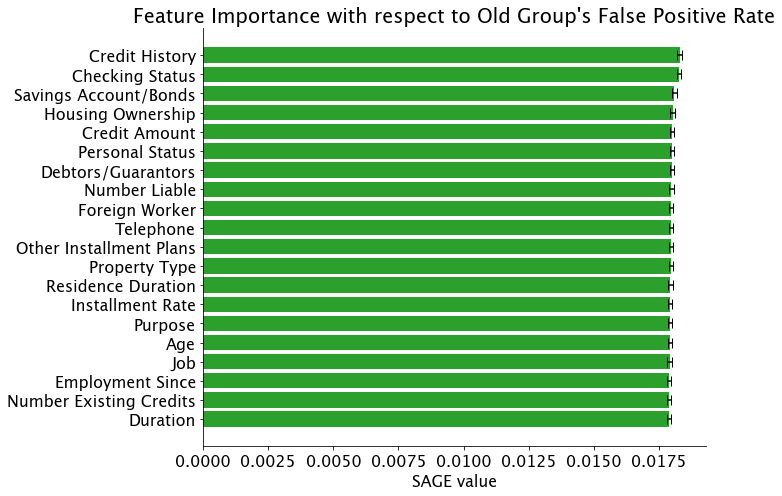

In [15]:
sage_values_old_fpr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Positive Rate')